In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.covariance import OAS


In [2]:
#generate time-stamp for filenames and allow pandas to display #### of rows
timestr = time.strftime("%Y%m%d-%H%M")
pd.set_option("display.max_rows", 1001)


In [3]:
#set working directory to fingerprints results directory
fppath='/Users/msandhu/Research/GPCR_Promiscuity/process_scripts/fingerprints'
os.chdir(fppath)


In [4]:
#Read fingerprint datasets into pandas dataframes
B2AR = pd.read_csv("B2AR_concat_fingerprints.tsv", sep='\t')
A2ARp = pd.read_csv("A2AR_concat_fingerprints.tsv", sep='\t')
A1AR =  pd.read_csv("A1R_concat_fingerprints.tsv", sep='\t')
HT1Bp = pd.read_csv("5HT1B_concat_fingerprints.tsv", sep='\t')
CHRM1 = pd.read_csv("CHRM1_concat_fingerprints.tsv", sep='\t')
HT2A = pd.read_csv("5HT2A_concat_fingerprints.tsv", sep='\t')
A2AR = A2ARp[::2] #reduce sampling of A2AR dataset to every 2nd frame b/c MD data was collected at more frequent intervals
HT1B = HT1Bp[::2] #reduce sampling of HT1B dataset to every 2nd frame b/c MD data was collected at more frequent intervals
B2TMs = pd.read_csv("B2AR-TM_Gs_contact_fingerprints.tsv", sep=',', index_col=0)
B2TMq = pd.read_csv("B2AR-TM_Gq_contact_fingerprints.tsv", sep=',', index_col=0)


In [5]:
#combine the individual pandas dataframes into one large dataframe for the LDA
cc = [ B2AR, A2AR, A1AR, HT1B, CHRM1, HT2A, B2TMs, B2TMq ]

bata = pd.concat(cc, sort=True, ignore_index=True)
bata.fillna(value=0, inplace=True)
bata = bata.astype(int)


In [6]:
#create new working directory to store results and cd into new directory
path = os.path.join(fppath, timestr)
os.makedirs(path)
os.chdir(path)


In [ ]:
#perform correlation analysis of each MD simulation to determine which contacts correlate with each other across different GPCR:G protein complexes
thresh = 0.5
counter=0
corrmatl = []
for name in ["B2ARcorr", "A2ARcorr", "A1ARcorr", "HT1Bcorr", "CHRM1corr", "HT2Acorr", "B2TMscorr", "B2TMqcorr"]:
    i=cc[counter].corr(method='spearman')
    corrmatl.append(i)
    i.to_csv(str(name)+"elation_matrix_spearman.txt", sep="\t")
    mask=np.zeros_like(i)
    mask[np.triu_indices_from(mask)]=True
    plt.figure(figsize=(10,10), dpi=300)
    sns.heatmap(i, mask=mask, square=True, linewidth=0.5, linecolor='white', cmap='plasma')
    plt.savefig(str(name)+"elation_matrix.png")
    np.fill_diagonal(i.values, 0)
    highcorr = i.abs().gt(thresh)
    print(i.where(highcorr).stack())
    i.where(highcorr).stack().to_csv(str(name)+"elation_high_pairs.txt", sep="\t")
    counter+=1


In [7]:
#Create target variables for the LDA model, scoring Gs:0, Gi:1, Gq:2
gstarg = np.full(B2AR.shape[0]+A2AR.shape[0], 0)
gitarg = np.full(A1AR.shape[0]+HT1B.shape[0], 1)
gqtarg = np.full(CHRM1.shape[0]+HT2A.shape[0], 2)
target = np.concatenate((gstarg, gitarg, gqtarg))

#Create "known scores" for triple-mutant B2AR simulations with Gs (TMs) and Gq (TMq) scored as "0" and "2"
TMs = np.full(B2TMs.shape[0], 0)
TMq = np.full(B2TMq.shape[0], 2)
#create "target" vector for the LDA models that includes triple mutant simulations
justarg = np.concatenate((TMs, TMq))
alltarg = np.concatenate((gstarg, gitarg, gqtarg, TMs, TMq))

#Create a pseudo scoring value for triple-mutant B2AR to use when plotting the frames in LDA space so they are distinguished from the Gs, Gi, and Gq systems 
TM3 = np.full(B2TMs.shape[0], 3)
TM4 = np.full(B2TMq.shape[0], 4)
plotall = np.concatenate((gstarg, gitarg, gqtarg, TM3, TM4))

#calculate shape of matrix distinguishing the original PDB simulations from triple mutant simulations within the large dataset
canon = B2AR.shape[0]+A2AR.shape[0]+A1AR.shape[0]+HT1B.shape[0]+CHRM1.shape[0]+HT2A.shape[0]

In [8]:
#Drop all contacts that are outside of the regions found commonly in GPCRs coupled across different G protein subfamilies. 
BminGprot = bata.drop([
 '5x78_G.H3.13',
 '5x78_G.H4.03',
 '5x78_G.H4.04',
 '5x78_G.H4.05',
 '5x78_G.H4.06',
 '5x78_G.H4.08',
 '5x78_G.H4.09',
 '5x78_G.H4.10',
 '5x78_G.H4.12',
 '5x78_G.H4.13',
 '5x78_G.H4.16',
 '5x78_G.H4.17',
 '5x78_G.H5.17',
 '5x78_G.H5.21',
 '5x78_G.H5.26',
 '5x78_G.S6.01',
 '5x78_G.S6.02',
 '5x78_G.S6.03',
 '5x78_G.S6.04',
 '5x78_G.S6.05',
 '5x78_G.h4s6.02',
 '5x78_G.h4s6.03',
 '5x78_G.h4s6.04',
 '5x78_G.h4s6.08',
 '5x78_G.h4s6.09',
 '5x78_G.h4s6.10',
 '5x78_G.h4s6.11',
 '5x78_G.h4s6.12',
 '5x78_G.h4s6.13',
 '5x78_G.h4s6.20',
 '5x78_G.hgh4.07',
 '5x78_G.hgh4.08',
 '5x78_G.hgh4.09',
 '5x78_G.hgh4.10',
 '5x78_G.hgh4.11',
 '5x78_G.hgh4.12',
 '5x78_G.hgh4.13',
 '5x78_G.hgh4.14',
 '5x78_G.hgh4.15',
 '5x78_G.hgh4.16',
 '5x78_G.hgh4.17',
 '5x78_G.hgh4.18',
 '6x24_G.H4.02',
 '6x24_G.H4.04',
 '6x24_G.H4.05',
 '6x24_G.H4.07',
 '6x24_G.H4.08',
 '6x24_G.H4.10',
 '6x24_G.H4.12',
 '6x24_G.H4.13',
 '6x24_G.H4.14',
 '6x24_G.H4.16',
 '6x24_G.H4.17',
 '6x24_G.H5.13',
 '6x24_G.H5.17',
 '6x24_G.S6.02',
 '6x24_G.S6.03',
 '6x24_G.h4s6.02',
 '6x24_G.h4s6.03',
 '6x24_G.h4s6.04',
 '6x24_G.h4s6.08',
 '6x24_G.h4s6.09',
 '6x24_G.h4s6.11',
 '6x24_G.h4s6.12',
 '6x24_G.hgh4.06',
 '6x24_G.hgh4.08',
 '6x25_G.H4.05',
 '6x25_G.H4.08',
 '6x25_G.H4.12',
 '6x25_G.H4.13',
 '6x25_G.H4.16',
 '6x25_G.H4.17',
 '6x25_G.H5.13',
 '6x25_G.S6.01',
 '6x25_G.S6.02',
 '6x25_G.S6.03',
 '6x25_G.S6.04',
 '6x25_G.h4s6.04',
 '6x25_G.h4s6.08',
 '6x25_G.h4s6.09',
 '6x25_G.h4s6.10',
 '6x25_G.h4s6.11',
 '6x25_G.h4s6.12',
 '6x25_G.hgh4.04',
 '6x25_G.hgh4.06',
 '6x25_G.hgh4.07',
 '6x26_G.H4.08',
 '6x26_G.H4.12',
 '6x26_G.H4.13',
 '6x26_G.H4.16',
 '6x26_G.H4.17',
 '6x26_G.H5.09',
 '6x26_G.H5.13',
 '6x26_G.H5.14',
 '6x26_G.H5.16',
 '6x26_G.H5.17',
 '6x26_G.H5.18',
 '6x26_G.H5.20',
 '6x26_G.H5.21',
 '6x26_G.H5.26',
 '6x26_G.HN.11',
 '6x26_G.HN.30',
 '6x26_G.S5.01',
 '6x26_G.S6.01',
 '6x26_G.S6.02',
 '6x26_G.S6.03',
 '6x26_G.S6.04',
 '6x26_G.h4s6.02',
 '6x26_G.h4s6.03',
 '6x26_G.h4s6.04',
 '6x26_G.h4s6.08',
 '6x26_G.h4s6.09',
 '6x26_G.h4s6.10',
 '6x26_G.h4s6.11',
 '6x26_G.h4s6.12',
 '6x26_G.h4s6.13',
 '6x26_G.h4s6.20',
 '6x26_G.hgh4.11',
 '6x26_G.hgh4.12',
 '6x26_G.hgh4.13',
 '6x26_G.hgh4.14',
 '6x26_G.hgh4.15',
 '6x26_G.hgh4.16',
 '6x26_G.hgh4.17',
 '6x27_G.H4.08',
 '6x27_G.H4.16',
 '6x27_G.H5.13',
 '6x27_G.H5.17',
 '6x27_G.H5.20',
 '6x27_G.H5.21',
 '6x27_G.H5.26',
 '6x27_G.HN.29',
 '6x27_G.S6.01',
 '6x27_G.S6.02',
 '6x27_G.h4s6.02',
 '6x27_G.h4s6.03',
 '6x27_G.h4s6.04',
 '6x27_G.h4s6.08',
 '6x27_G.h4s6.09',
 '6x27_G.h4s6.10',
 '6x27_G.h4s6.11',
 '6x27_G.h4s6.12',
 '6x27_G.h4s6.13',
 '6x27_G.h4s6.20',
 '6x27_G.hgh4.12',
 '6x27_G.hgh4.13',
 '6x27_G.hgh4.14',
 '6x27_G.hgh4.15',
 '6x28_G.H5.17',
 '6x28_G.H5.20',
 '6x28_G.H5.25',
 '6x28_G.H5.26',
 '6x28_G.h4s6.08',
 '6x28_G.h4s6.09',
 '6x28_G.h4s6.10',
 '6x28_G.h4s6.12',
 '6x28_G.hgh4.13',
 '6x28_G.hgh4.14',
 '6x28_G.hgh4.15',
 '6x28_G.hgh4.16',
 '6x29_G.H4.16',
 '6x29_G.H5.13',
 '6x29_G.H5.17',
 '6x29_G.H5.20',
 '6x29_G.H5.21',
 '6x29_G.H5.24',
 '6x29_G.H5.25',
 '6x29_G.H5.26',
 '6x29_G.S6.02',
 '6x29_G.h4s6.04',
 '6x29_G.h4s6.08',
 '6x29_G.h4s6.09',
 '6x29_G.h4s6.10',
 '6x29_G.h4s6.11',
 '6x29_G.h4s6.12',
 '6x29_G.h4s6.20',
 '8x64_G.H2.09',
 '8x64_G.H3.16',
 '8x64_G.H3.17',
 '8x65_G.H2.09',
 '8x65_G.H3.16',
 '8x65_G.H3.17',
 '8x66_G.H2.09',
 '8x67_G.H2.05',
 '8x67_G.H2.08',
 '8x67_G.H2.09',
 '8x67_G.H3.14',
 '8x67_G.H3.15',
 '8x67_G.H3.16',
 '8x67_G.H3.17',
 '8x67_G.h3s5.01',
 '8x68_G.H2.05',
 '8x68_G.H2.08',
 '8x68_G.H2.09',
 '8x68_G.H3.15',
 '8x68_G.H3.16',
 '8x68_G.H3.17',
 '8x68_G.h3s5.01',
 '8x68_G.h3s5.02',
 '8x69_G.H2.05',
 '8x69_G.H2.06',
 '8x69_G.H2.08',
 '8x69_G.H2.09',
 '8x69_G.H3.14',
 '8x69_G.H3.15',
 '8x69_G.H3.16',
 '8x69_G.H3.17',
 '8x69_G.h3s5.01',
 '8x69_G.h4s6.09',
 '8x70_G.H2.04',
 '8x70_G.H2.05',
 '8x70_G.H2.08',
 '8x70_G.H2.09',
 '8x70_G.H3.11',
 '8x70_G.H3.14',
 '8x70_G.H3.15',
 '8x70_G.H3.16',
 '8x70_G.H3.17',
 '8x71_G.H2.03',
 '8x71_G.H2.04',
 '8x71_G.H2.05',
 '8x71_G.H2.08',
 '8x71_G.H2.09',
 '8x71_G.H3.11',
 '8x71_G.H3.14',
 '8x71_G.H3.15',
 '8x71_G.H3.16',
 '8x71_G.H3.17',
 '8x71_G.h2s4.01',
 '8x71_G.h3s5.01',
 '8x71_G.h3s5.02',
 '8x71_G.h4s6.08',
 '8x71_G.h4s6.09',
 '8x71_G.h4s6.10',
 '8x71_G.h4s6.11',
 '8x71_G.h4s6.13'], 
 axis=1)

In [70]:
BminGprot[:canon].shape

(293757, 764)

In [10]:
#create a training dataset and holdout validation set from the original PDB simulation data
X_train, X_test = train_test_split(BminGprot[:canon], test_size=0.2, stratify=target, random_state=1)
print(X_test)

        12x48_G.H2.09  12x48_G.H3.16  12x48_G.H3.17  12x48_G.HN.41  \
71556               0              0              0              0   
243706              0              0              0              0   
239467              0              0              0              0   
210000              0              0              0              0   
32214               0              0              0              0   
...               ...            ...            ...            ...   
50092               0              0              0              0   
199732              0              0              0              0   
284576              0              0              0              0   
18671               0              0              0              0   
13488               0              0              0              0   

        12x48_G.HN.44  12x48_G.HN.45  12x48_G.HN.47  12x48_G.HN.48  \
71556               0              0              0              0   
243706             

In [12]:
#Create target vectors for the training subset and holdout validation subset
trnIndx = X_train.index.values
tstIndx = X_test.index.values
trnTarg = []
tstTarg = []
for i in trnIndx:
    trnTarg.append(target[i])
for i in tstIndx:
    tstTarg.append(target[i])


In [111]:
#create pseudo target vector for 20% holdout data that will allow plotting in different color
new_list = [x+3 for x in tstTarg]
new_list

[3,
 5,
 5,
 5,
 3,
 5,
 4,
 5,
 3,
 5,
 5,
 4,
 5,
 4,
 4,
 3,
 4,
 4,
 3,
 3,
 5,
 4,
 5,
 3,
 4,
 4,
 3,
 5,
 5,
 4,
 3,
 5,
 5,
 4,
 3,
 3,
 4,
 5,
 5,
 3,
 5,
 3,
 4,
 5,
 5,
 5,
 3,
 5,
 3,
 3,
 4,
 5,
 4,
 3,
 4,
 3,
 3,
 4,
 4,
 4,
 5,
 3,
 3,
 5,
 3,
 4,
 3,
 4,
 3,
 5,
 5,
 4,
 5,
 4,
 4,
 3,
 5,
 4,
 3,
 5,
 3,
 4,
 4,
 3,
 4,
 4,
 5,
 5,
 4,
 3,
 3,
 5,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 3,
 5,
 4,
 5,
 5,
 5,
 3,
 5,
 5,
 3,
 3,
 3,
 4,
 5,
 4,
 4,
 3,
 5,
 4,
 3,
 5,
 5,
 3,
 3,
 3,
 4,
 3,
 3,
 4,
 4,
 3,
 5,
 4,
 5,
 5,
 4,
 5,
 3,
 5,
 3,
 4,
 5,
 3,
 5,
 4,
 4,
 3,
 4,
 4,
 5,
 3,
 5,
 3,
 5,
 4,
 3,
 5,
 5,
 3,
 3,
 5,
 4,
 3,
 5,
 5,
 3,
 5,
 4,
 3,
 4,
 3,
 5,
 3,
 4,
 4,
 3,
 4,
 3,
 4,
 4,
 5,
 3,
 4,
 4,
 3,
 3,
 4,
 4,
 5,
 5,
 4,
 4,
 3,
 5,
 3,
 3,
 4,
 5,
 3,
 5,
 4,
 4,
 3,
 5,
 5,
 3,
 5,
 5,
 3,
 5,
 3,
 5,
 5,
 3,
 5,
 5,
 3,
 5,
 4,
 5,
 3,
 3,
 4,
 5,
 3,
 5,
 4,
 5,
 3,
 3,
 3,
 4,
 4,
 3,
 3,
 3,
 3,
 4,
 5,
 3,
 5,
 4,
 5,
 5,
 5,
 3,
 3,
 5,
 5,
 5,
 3,


In [124]:

tstplus3 = list(zip(tstIndx,new_list))
trn0 = list(zip(trnIndx,trnTarg))
newtarg = pd.DataFrame(tstplus3, columns=["ind","target"])
origtarg = pd.DataFrame(trn0, columns=["ind","target"])
snewtarg = newtarg.append(origtarg)
snewtarg.set_index("ind", drop=True, inplace=True)
snewtarg.sort_index(axis=0, inplace=True)

In [ ]:
#Plot the contact frequency densities of each GPCR:G protein simulation system
density = {}
names = ["B2AR","A2AR","A1AR","HT1B","CHRM1", "HT2A", "B2TMs", "B2TMq"]
for i in range(0,8):
    if names[i] not in density.keys():
        density[names[i]]=[]
    for col, val in cc[i].sum().iteritems():
        #density[names[i]].append(col)
        density[names[i]].append(val)

for i in names:
    plt.figure()
    plt.hist(density[i], bins=100, range=(100,52000))
    plt.title(str(i)+"_contact_frequency_density", size=20)
    plt.xlabel("frequency of contact", size=15)
    plt.ylabel("density", size=15)
    plt.ylim(0,65)
    plt.savefig(str(i)+"_density_hist.png")


In [71]:
#Perform an LDA on the the X_train dataset
trnLDA = LinearDiscriminantAnalysis(n_components=2, store_covariance=True)
trnL_f = trnLDA.fit(X_train, trnTarg)
trnL_t = trnL_f.transform(X_train)
trnL_t1 = trnL_f.transform(BminGprot[:canon])

In [72]:
#calculate the explained variance of the two linearly deconvolved component vectors
print('explained variance ratio of LDA: %s'
      % str(trnLDA.explained_variance_ratio_))

explained variance ratio of LDA: [0.6637716 0.3362284]


In [73]:
#Calculate the percentage of correctly predicted targets within the 20% holdout data
xtestsco = trnL_f.score(X_test, np.array(tstTarg))

print('score for X_test: %s'
      % str(xtestsco))

score for X_test: 0.9963575708061002


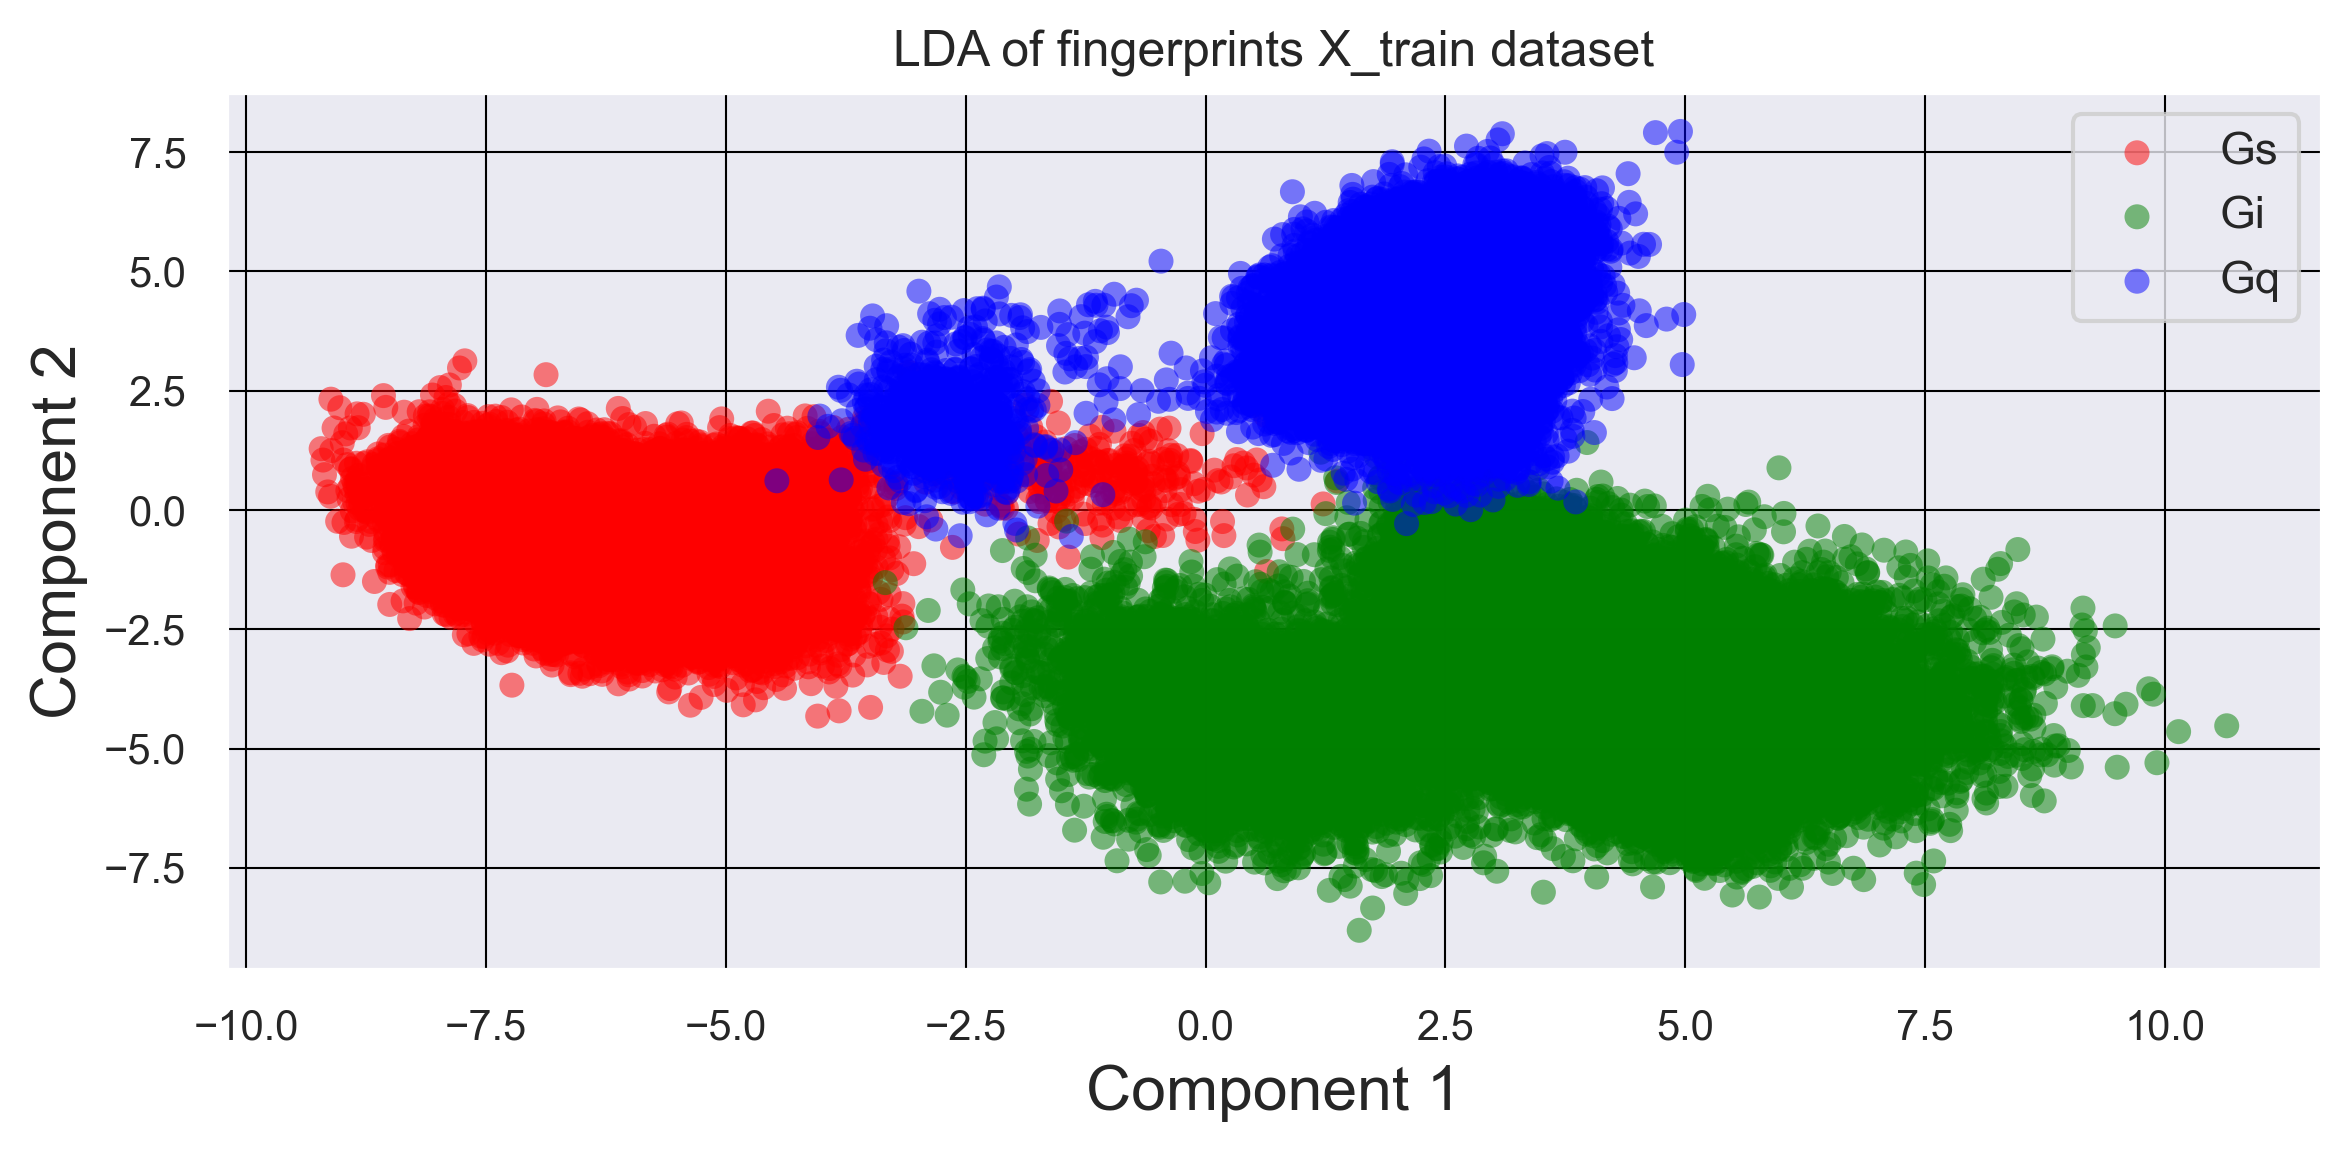

In [136]:
#Plot the mapping of training data onto the linear discriminant components (red, green, blue circles)
plt.figure(figsize=(8,4), dpi=300)
colors = ['red', 'green', 'blue']
target_names = ['Gs', 'Gi', 'Gq']
alphs = [0.5, 0.5, 0.5]
for color, i, target_name, alfa in zip(colors, [0, 1, 2], target_names, alphs):
    plt.scatter(trnL_t[np.array(trnTarg) == i, 0], trnL_t[np.array(trnTarg) == i, 1], facecolor=color, edgecolor="none", alpha=alfa, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("Component 1", size=15)
plt.ylabel("Component 2", size=15)
plt.yticks(size=10)
plt.xticks(size=10)
plt.title('LDA of fingerprints X_train dataset')
plt.grid(color="black", linewidth=0.5)
plt.tight_layout()
plt.savefig("LDA_2021_X_train"+timestr+".pdf", dpi=300, transparent=True)
plt.savefig("LDA_2021_X_train"+timestr+".png", dpi=300, transparent=True)

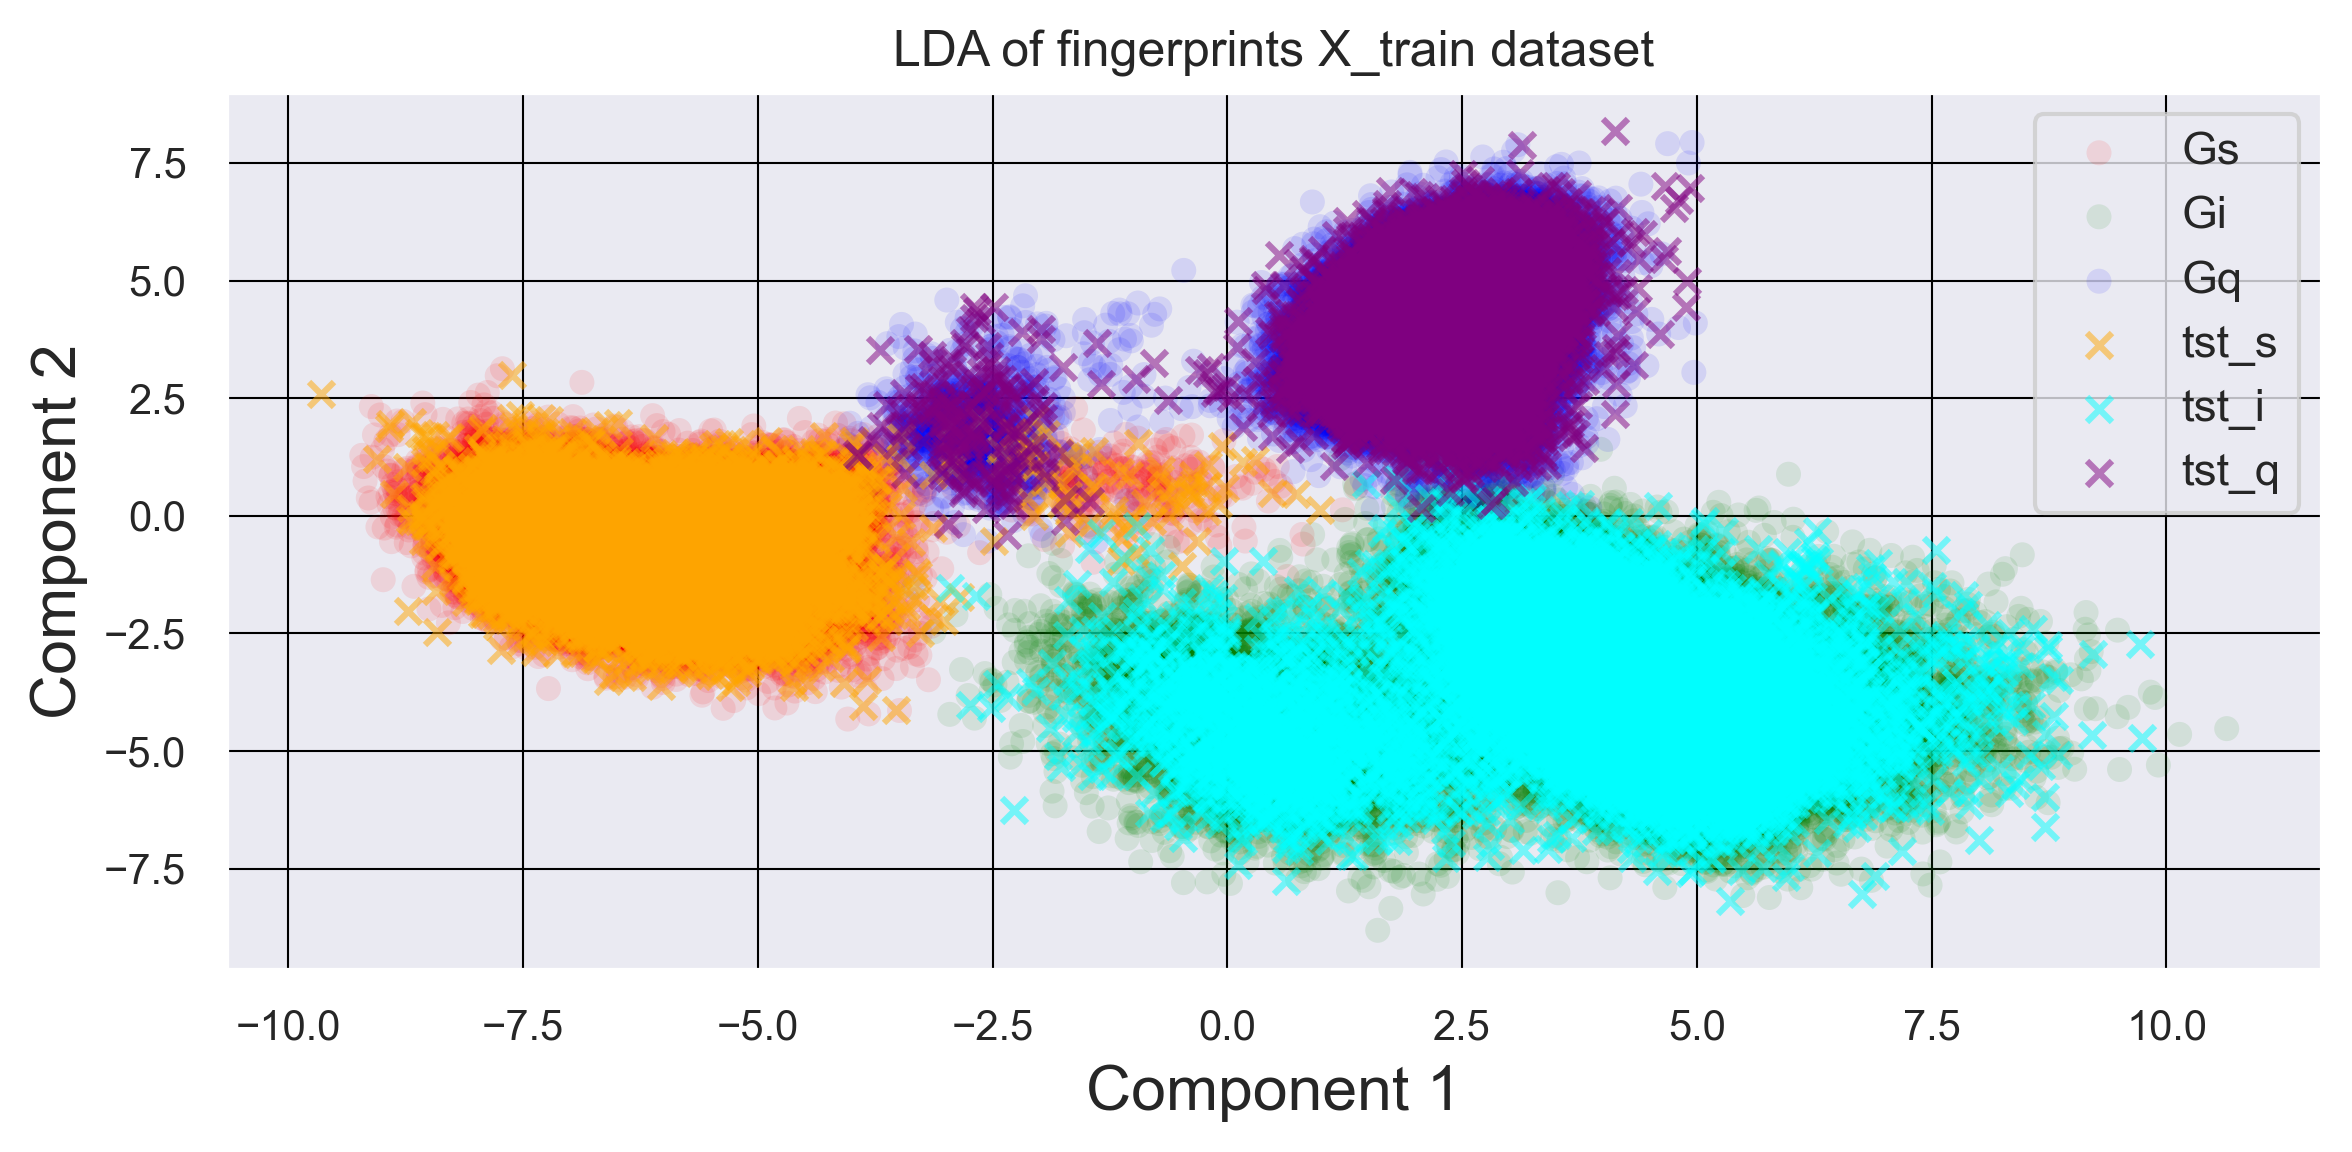

In [135]:
#Plot the mapping of holdout validation data onto the linear discriminant components (orange, cyan, magenta "x")
plt.figure(figsize=(8,4), dpi=300)
colors = ['red', 'green', 'blue', 'orange', 'cyan', 'purple']
target_names = ['Gs', 'Gi', 'Gq', 'tst_s', 'tst_i', 'tst_q']
alphs = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5]
markas = ['o','o','o','x','x','x']
for color, i, target_name, alfa, marks in zip(colors, [0, 1, 2, 3, 4, 5], target_names, alphs, markas):
    plt.scatter(trnL_t1[snewtarg['target'] == i, 0], trnL_t1[snewtarg['target'] == i, 1], marker=marks, facecolor=color, edgecolor="none", alpha=alfa, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("Component 1", size=15)
plt.ylabel("Component 2", size=15)
plt.yticks(size=10)
plt.xticks(size=10)
plt.title('LDA of fingerprints X_train dataset')
plt.grid(color="black", linewidth=0.5)
plt.tight_layout()
plt.savefig("LDA_2021_X_train-model_BminProjected_"+timestr+".pdf", dpi=300, transparent=True)
plt.savefig("LDA_2021_X_train-model_BminProjected_"+timestr+".png", dpi=300, transparent=True)

In [87]:
#Perform LDA on original structures
blda = LinearDiscriminantAnalysis(n_components=2, store_covariance=True)
bL_f = blda.fit(BminGprot[:canon], target)
bL_t = bL_f.transform(BminGprot[:canon])
bL_t1 = bL_f.transform(BminGprot)

In [88]:
#calculate the explained variance of the two linearly deconvolved component vectors
print('explained variance ratio of LDA: %s'
      % str(blda.explained_variance_ratio_))

explained variance ratio of LDA: [0.66361397 0.33638603]


In [89]:
#Score for predicting B2AR-TM with Gs as belonging to the Gs class 
bTMssco = bL_f.score(BminGprot[canon:-B2TMq.shape[0]], TMs)
print('score for TMs and TMq: %s'
     % str(bTMssco))

score for TMs and TMq: 0.5710485790284194


In [90]:
#Score for predicting B2AR-TM with Gq as belonging to the Gq class 
bTMqsco = bL_f.score(BminGprot[-B2TMq.shape[0]:], TMq)
print('score for TMs and TMq: %s'
     % str(bTMqsco))

score for TMs and TMq: 0.037819243615127694


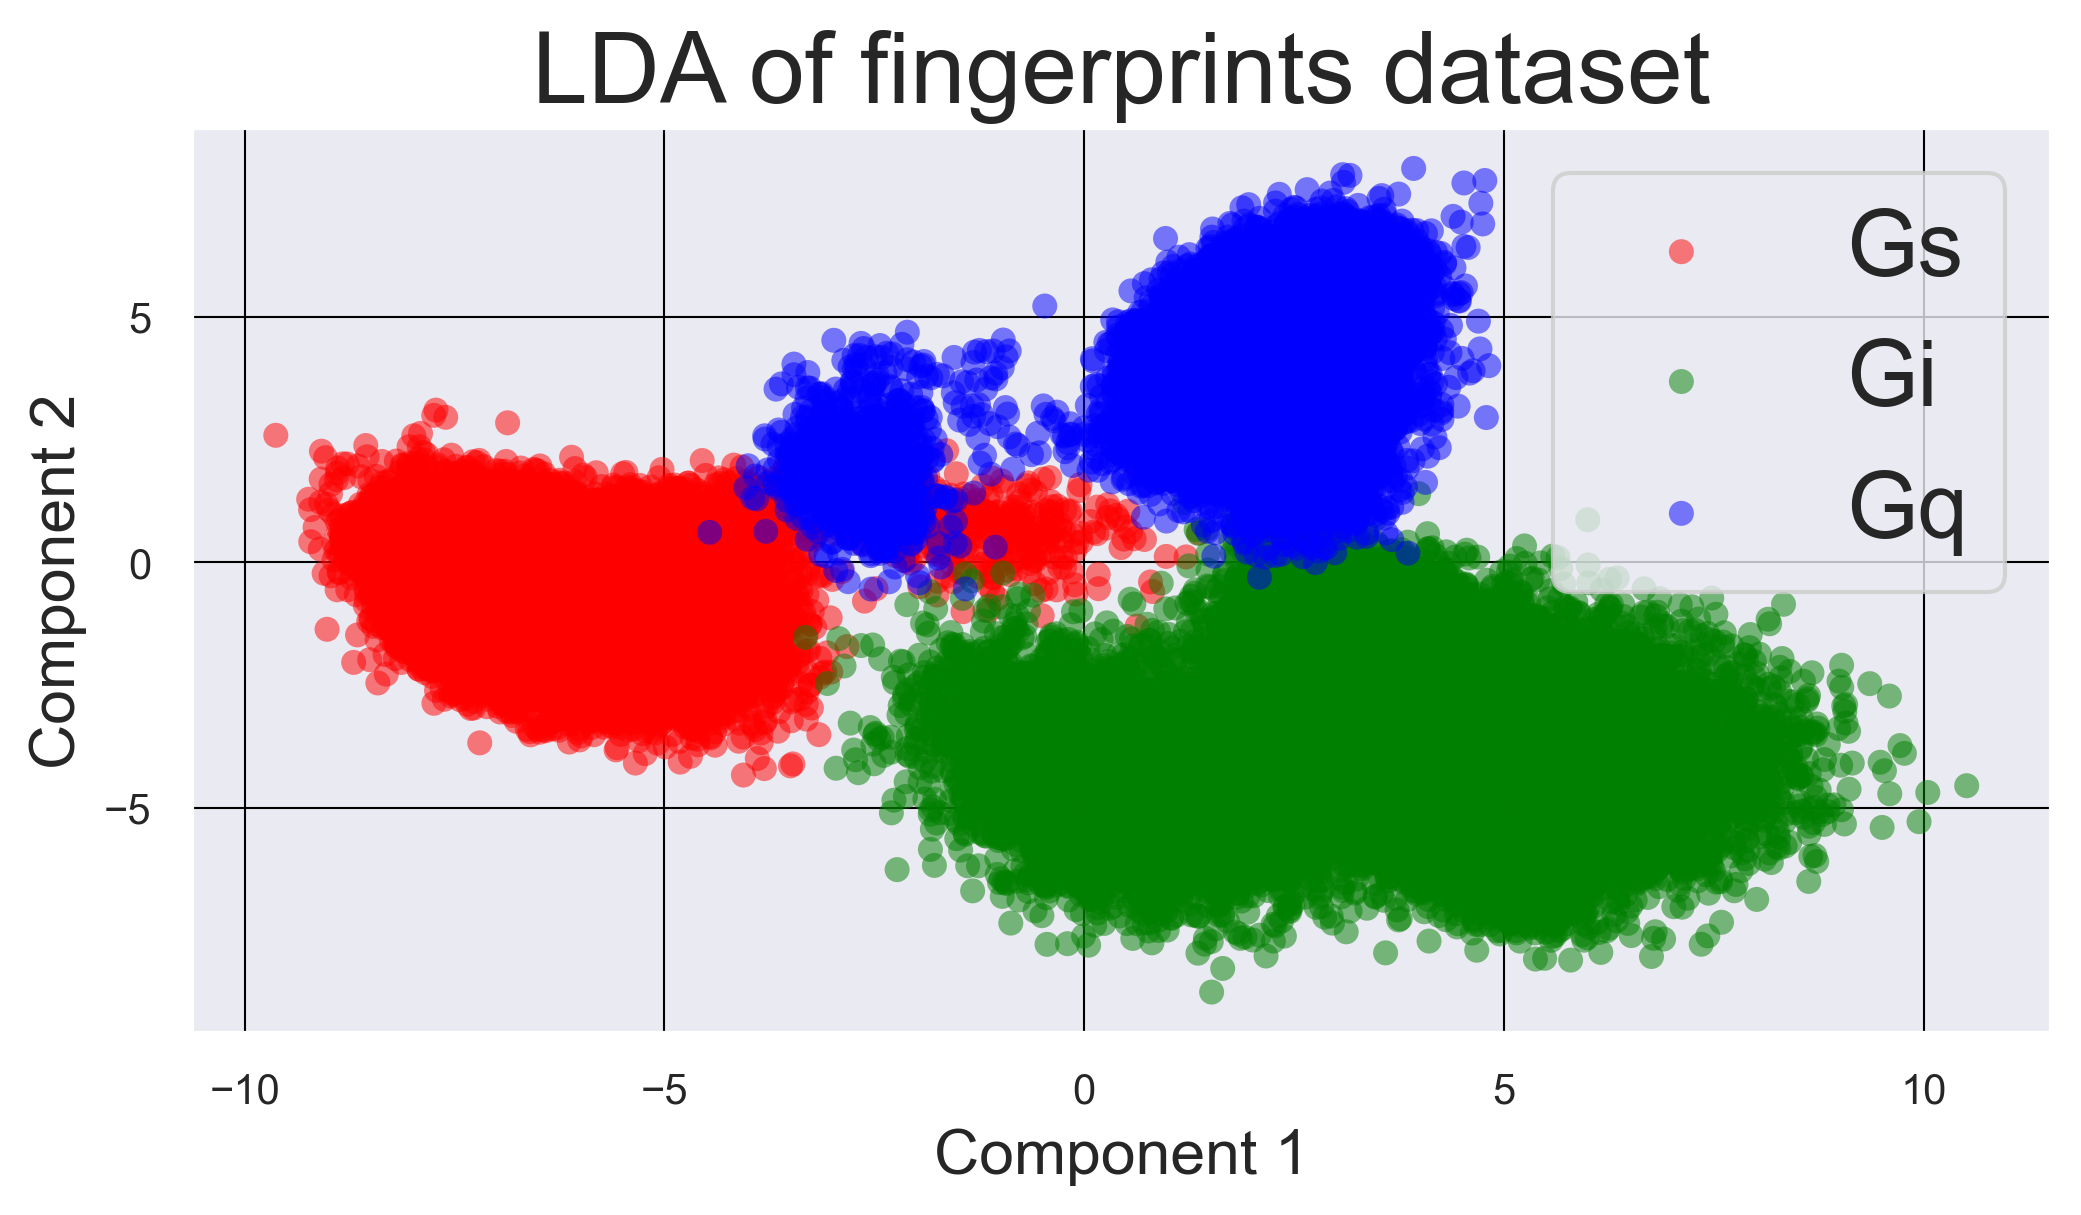

In [91]:
#Plotting the original PDB simulations data onto the linear discriminant space
plt.figure(figsize=(8,4), dpi=300)
colors = ['red', 'green', 'blue']
target_names = ['Gs', 'Gi', 'Gq']
alphs = [0.5, 0.5, 0.5]
for color, i, target_name, alfa in zip(colors, [0, 1, 2], target_names, alphs):
    plt.scatter(bL_t[target == i, 0], bL_t[target == i, 1], facecolor=color, edgecolor="none", alpha=alfa, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("Component 1", size=15)
plt.ylabel("Component 2", size=15)
plt.yticks(size=10)
plt.xticks(size=10)
plt.title('LDA of fingerprints dataset')
plt.grid(color="black", linewidth=0.5)
plt.savefig("LDA_2021_minimial_struc_"+timestr+".png", dpi=300, transparent=True)

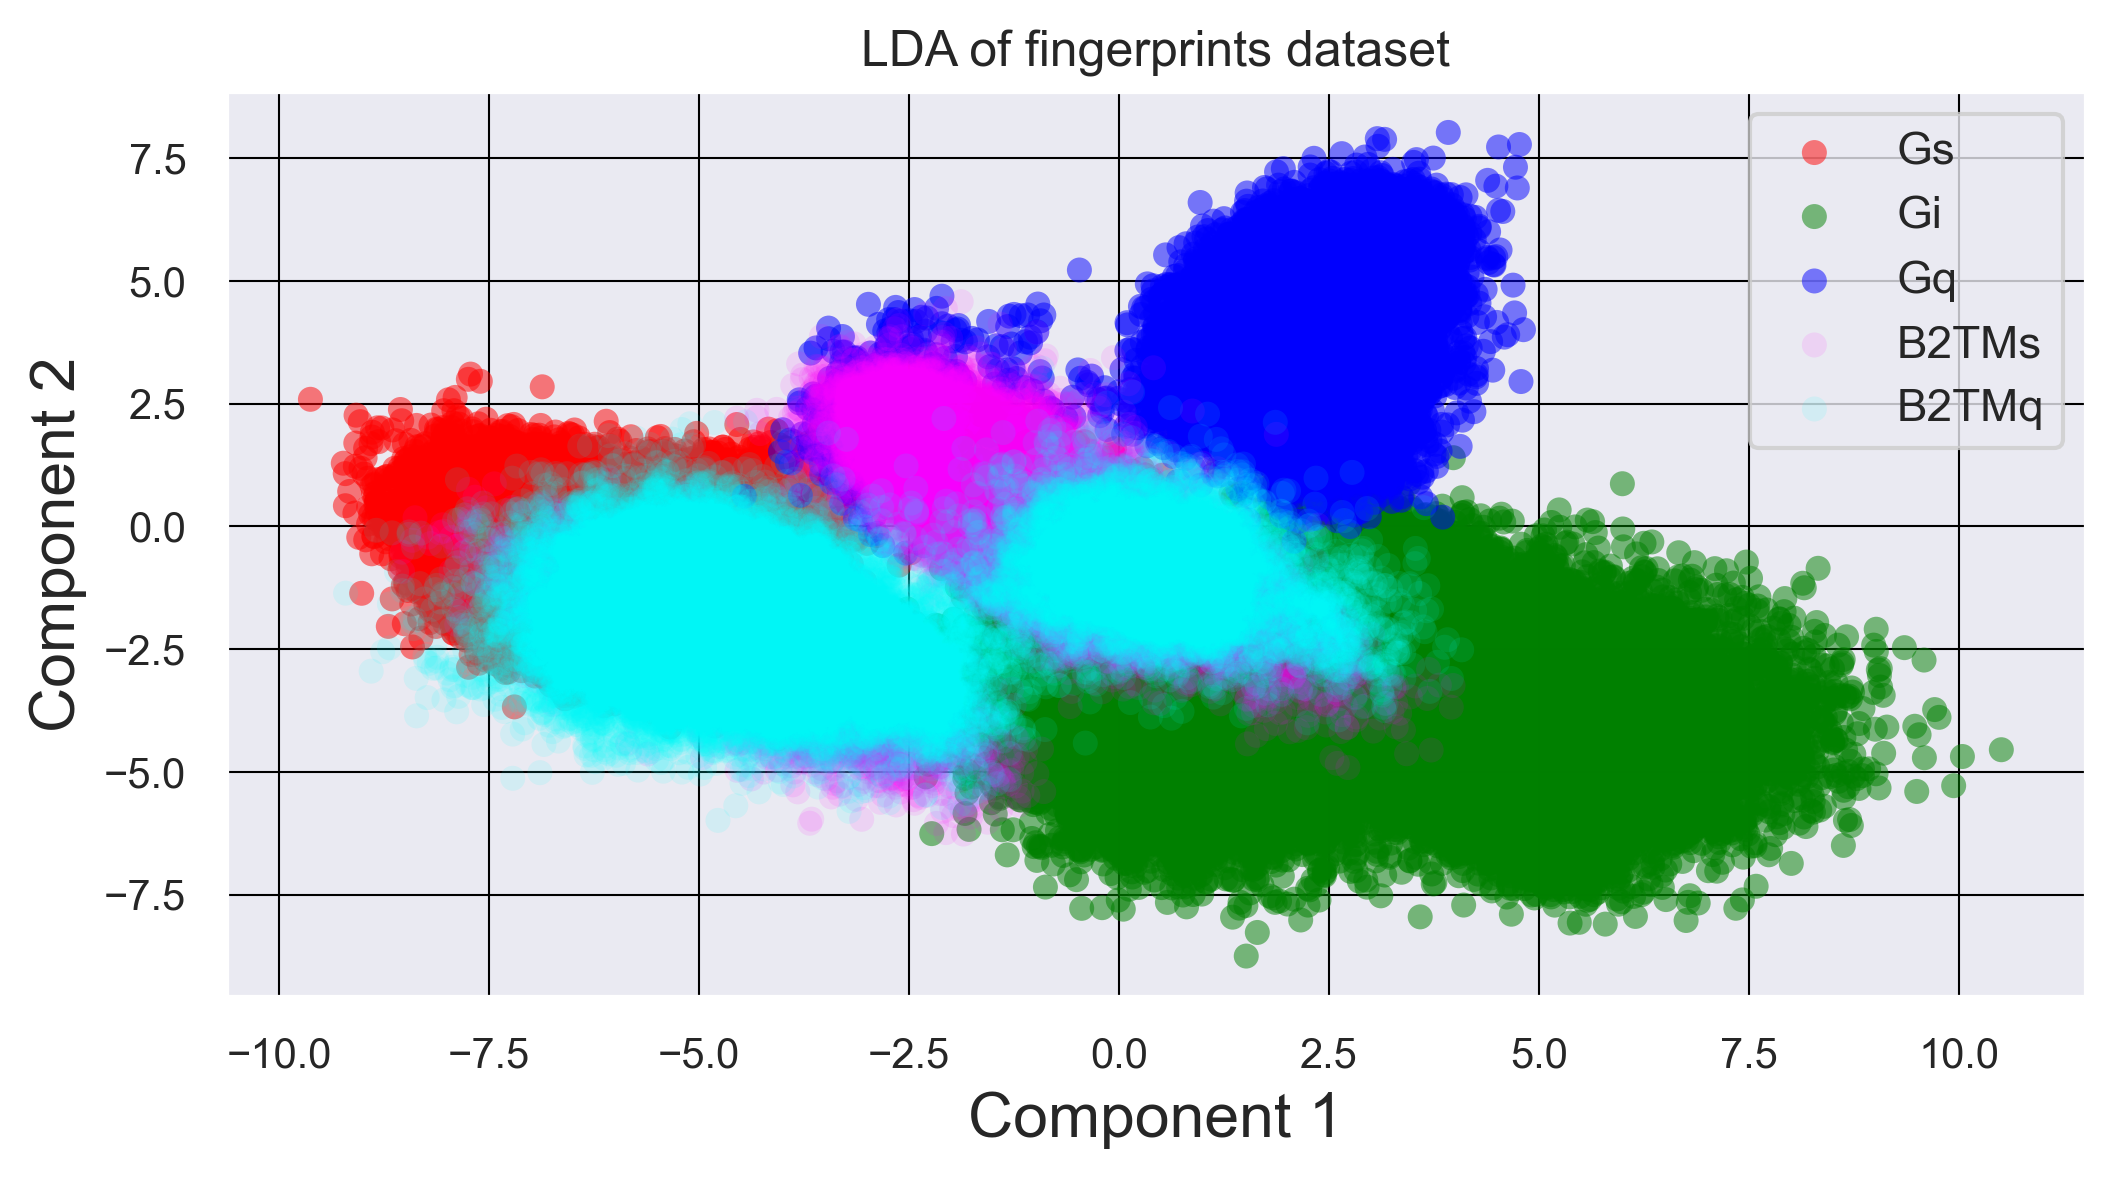

In [92]:
#Plotting the B2AR-TM data onto LDA space with original PDB simulations
sns.set(font_scale=1)
plt.figure(figsize=(8,4), dpi=300)
colors = ['red', 'green', 'blue','magenta','cyan']
target_names = ['Gs', 'Gi', 'Gq','B2TMs','B2TMq']
alphs = [0.5, 0.5, 0.5, 0.1, 0.1]
for color, i, target_name, alfa in zip(colors, [0, 1, 2, 3, 4], target_names, alphs):
    plt.scatter(bL_t1[plotall == i, 0], bL_t1[plotall == i, 1], facecolor=color, edgecolor="none", alpha=alfa, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("Component 1", size=15)
plt.ylabel("Component 2", size=15)
plt.yticks(size=10)
plt.xticks(size=10)
plt.title('LDA of fingerprints dataset')
plt.grid(color="black", linewidth=0.5)
plt.savefig("LDA_2021_minimial_struc_withPromGPCRs_"+timestr+".png", dpi=300, transparent=True)

In [98]:
#Save all components of the LDA model to csv files for SI documents
bmeans = pd.DataFrame(bL_f.means_, columns=list(BminGprot.columns.values)).T
bcoef = pd.DataFrame(bL_f.coef_, columns=list(BminGprot.columns.values)).T
bwtd_means = pd.DataFrame((bL_f.means_*bL_f.coef_), columns=list(BminGprot.columns.values)).T

bmeans.columns = ["mGs", "mGi", "mGq"]
bcoef.columns = ["cGs", "cGi", "cGq"]
bwtd_means.columns = ["wGs", "wGi", "wGq"]
ball = pd.concat([bwtd_means, bcoef, bmeans], axis=1, sort=True)

ball[["wGs","cGs","mGs","wGi","cGi","mGi","wGq","cGq","mGq"]].to_csv("weighted_coefficients_LDA_model"+timestr+".csv")

pd.DataFrame(bL_f.scalings_, index=list(BminGprot.columns.values), columns=["component1", "component2"]).to_csv("contact_scalings_LDA_model"+timestr+".csv")

pd.DataFrame(blda.covariance_, index=list(BminGprot.columns.values), columns=list(BminGprot.columns.values)).to_csv("covariance_matrix_LDA_model_"+timestr+".csv")

pd.DataFrame(bL_t1, columns=["component1_coord", "component2_coord"]).to_csv("frame_coordinates_LDA_model"+timestr+".csv")

In [13]:
#Compute the mean of each contact across all of the simulations
beta2 = np.full(B2AR.shape[0], "B2AR")
ade2a = np.full(A2AR.shape[0], "A2AR")
ade1r = np.full(A1AR.shape[0], "A1AR")
ht1br = np.full(HT1B.shape[0], "HT1B")
chrm1r = np.full(CHRM1.shape[0], "CHRM1")
ht2ar = np.full(HT2A.shape[0], "HT2A")
b2tmsr = np.full(B2TMs.shape[0], "B2TMs")
b2tmqr = np.full(B2TMq.shape[0], "B2TMq")

systems = np.concatenate((beta2, ade2a, ade1r, ht1br, chrm1r, ht2ar, b2tmsr, b2tmqr))

systs = pd.Categorical(systems)
labdf = BminGprot.join(pd.Series(systs, name="system"))
labdf.to_csv("GPCR_Gprotein_fingerprints_for_LDA"+timestr+".txt", sep="\t")

simulation_means = pd.DataFrame(columns=("B2AR", "A2AR", "A1AR", "HT1B", "CHRM1", "HT2A", "B2TMs", "B2TMq"))
for c, rows in labdf.groupby('system'):
    simulation_means[c] = np.mean(rows)
main_means = simulation_means[["B2AR","A2AR","A1AR","HT1B","CHRM1","HT2A"]]
simulation_means.to_csv("LDA_BminGprot_contact_frequencies.txt", sep="\t")

gst = np.full(B2AR.shape[0]+A2AR.shape[0], "Gs")
git = np.full(A1AR.shape[0]+HT1B.shape[0], "Gi")
gqt = np.full(CHRM1.shape[0]+HT2A.shape[0], "Gq")
b2s = np.full(B2TMs.shape[0], "B2TMs")
b2q = np.full(B2TMq.shape[0], "B2TMq")
targa = np.concatenate((gst, git, gqt))
classes = pd.Categorical(targa)
df = BminGprot[:canon].join(pd.Series(classes, name="class"))
class_feature_means = pd.DataFrame(columns=("Gs","Gi","Gq"))
for c, rows in df.groupby('class'):
    class_feature_means[c] = np.mean(rows)
class_feature_means.to_csv("LDA_mean_contact_frequencies_byGprotClass.txt", sep="\t")

common_gp = class_feature_means[(class_feature_means >= .2)].dropna()


In [25]:
gsLDA = ['34x50_G.H5.12','34x50_G.H5.19','34x51_G.H5.12','34x51_G.S3.01','34x53_G.H5.19','34x54_G.hns1.02','3x54_G.H5.16','5x68_G.H5.17','7x55_G.H5.24','8x48_G.H5.24']
giLDA = ['12x49_G.h3s5.02','3x53_G.H5.19','3x53_G.H5.22','5x61_G.H5.25','5x68_G.H5.13','5x71_G.H5.09','6x32_G.H5.26','7x56_G.H5.24','8x47_G.H5.22','8x49_G.H5.22']
gqLDA = ['2x39_G.H5.23','3x53_G.H5.19','34x53_G.H5.23','34x55_G.hns1.02','34x55_G.hns1.03','34x57_G.hns1.02','4x38_G.hns1.02','4x39_G.H5.22','6x33_G.H5.25','8x48_G.H5.26']

In [26]:
gs_conts = main_means[["B2AR","A2AR"]][(main_means >= 0.2)].dropna(how='all').index.values
gi_conts = main_means[["A1AR","HT1B"]][(main_means >= 0.2)].dropna(how='all').index.values
gq_conts = main_means[["CHRM1","HT2A"]][(main_means >= 0.2)].dropna(how='all').index.values

gsspec = set(gs_conts).difference(set(gi_conts),set(gq_conts))
print(gsspec)
gispec = set(gi_conts).difference(set(gs_conts),set(gq_conts))
print(gispec)
gqspec = set(gq_conts).difference(set(gi_conts),set(gs_conts))
print(gqspec)
commall = set(gs_conts).intersection(set(gi_conts),set(gq_conts))
print(commall)
print(len(commall))
print(len(gsspec))
print(len(gispec))
print(len(gqspec))

{'8x48_G.H5.24', '5x64_G.H5.16', '5x75_G.h4s6.20', '5x69_G.H5.26', '5x75_G.S6.02', '34x51_G.hns1.02', '5x75_G.S6.03', '5x77_G.H4.12', '34x51_G.H5.11', '5x71_G.H5.17', '5x74_G.hgh4.13', '5x77_G.H4.16', '5x72_G.H5.17', '34x54_G.hns1.03', '5x68_G.H5.17', '34x51_G.S1.02', '5x68_G.H5.20', '8x48_G.H5.22', '5x72_G.h4s6.20', '34x55_G.HN.52', '3x55_G.H5.12', '5x77_G.h4s6.03', '34x54_G.H5.19', '3x54_G.H5.23'}
{'12x49_G.h3s5.02', '2x40_G.H5.22', '7x56_G.H5.22', '3x50_G.H5.22', '6x32_G.H5.25', '5x71_G.H5.09', '34x52_G.s2s3.01', '8x47_G.H5.21', '34x55_G.S3.01', '3x50_G.H5.25', '8x49_G.H5.22', '7x56_G.H5.23', '3x53_G.H5.22'}
{'34x53_G.H5.23', '6x30_G.H5.17', '8x49_G.H5.24', '4x38_G.hns1.02', '2x39_G.H5.24', '34x56_G.hns1.02', '34x51_G.s2s3.02', '2x39_G.H5.22', '34x57_G.hns1.02', '4x39_G.H5.22', '2x37_G.H5.24', '2x37_G.H5.22', '2x40_G.H5.24', '2x39_G.H5.23', '34x55_G.s2s3.01', '6x33_G.H5.20', '8x48_G.H5.26', '3x49_G.H5.23'}
{'34x50_G.H5.19', '34x51_G.H5.08', '3x50_G.H5.23', '34x55_G.hns1.03', '6x33_G

In [27]:
#Identify which LDA contacts arise from common subset of contacts and which from G protein specific subset
print(set(gsLDA).intersection(set(commall)))
print(set(giLDA).intersection(set(commall)))
print(set(gqLDA).intersection(set(commall)))
print(set(gsLDA).intersection(set(gsspec)))
print(set(giLDA).intersection(set(gispec)))
print(set(gqLDA).intersection(set(gqspec)))




{'34x50_G.H5.19', '3x54_G.H5.16', '34x51_G.H5.12', '34x50_G.H5.12', '34x51_G.S3.01'}
{'3x53_G.H5.19', '8x47_G.H5.22', '6x32_G.H5.26', '7x56_G.H5.24'}
{'3x53_G.H5.19', '34x55_G.hns1.03', '6x33_G.H5.25', '34x55_G.hns1.02'}
{'5x68_G.H5.17', '8x48_G.H5.24'}
{'8x49_G.H5.22', '12x49_G.h3s5.02', '5x71_G.H5.09', '3x53_G.H5.22'}
{'34x57_G.hns1.02', '34x53_G.H5.23', '4x39_G.H5.22', '8x48_G.H5.26', '4x38_G.hns1.02', '2x39_G.H5.23'}


In [28]:
gpcrss = []
gprotss = []
for i in main_means.index.values:
    nam = str(i).split('_')
    SS = nam[0].split('x')
    TM = "TM"+str(SS[0])
    gp = nam[1].split(".")
    if TM not in gpcrss:
        gpcrss.append(TM)
    if gp[1] not in gprotss:
        gprotss.append(gp[1])
print(gpcrss)
print(gprotss)

['TM12', 'TM1', 'TM2', 'TM34', 'TM3', 'TM4', 'TM5', 'TM6', 'TM7', 'TM8']
['H2', 'H3', 'HN', 'S1', 'h2s4', 'h3s5', 'h4s6', 'hns1', 'H5', 'S3', 'S2', 's2s3', 'H4', 'S6', 'hgh4', 'HG', 's6h5']


In [29]:
main_means.loc[commall].sort_index()

B2AR      A2AR      A1AR      HT1B     CHRM1      HT2A
34x50_G.H5.12    0.455785  0.932022  0.085691  0.274493  0.517828  0.414619
34x50_G.H5.15    0.632300  0.893067  0.377522  0.473791  0.683792  0.762124
34x50_G.H5.16    0.208274  0.831832  0.476012  0.634402  0.667033  0.368063
34x50_G.H5.19    0.467108  0.692365  0.358704  0.108459  0.000040  0.513349
34x51_G.H5.08    0.609116  0.123627  0.394781  0.173788  0.016558  0.528747
34x51_G.H5.12    0.704621  0.958241  0.242776  0.517010  0.876432  0.610859
34x51_G.H5.15    0.467723  0.240491  0.434017  0.347021  0.349825  0.384422
34x51_G.S3.01    0.410108  0.878213  0.341106  0.440037  0.345245  0.000000
34x55_G.hns1.02  0.223942  0.385608  0.324228  0.270937  0.662614  0.902990
34x55_G.hns1.03  0.032950  0.292802  0.283632  0.260049  0.936926  0.463594
3x50_G.H5.23     0.957995  0.997603  0.926387  0.897896  0.990941  0.657354
3x53_G.H5.19     0.823388  0.784958  0.975422  0.944893  0.849395  0.932667
3x53_G.H5.23     0.723442  0.000000  0.645335  0.002778  0.000000  0.900810
3x54_G.H5.16     0.977988  0.885790  0.247435  0.567807  0.062594  0.624678
3x54_G.H5.20     0.685378  0.009589  0.241956  0.622159  0.002820  0.609499
5x65_G.H5.20     0.593602  0.084801  0.514349  0.369220  0.011099  0.200540
5x68_G.H5.16     0.841786  0.531988  0.537986  0.690021  0.239356  0.000000
6x32_G.H5.26     0.583010  0.110486  0.323228  0.868964  0.171503  0.502770
6x33_G.H5.25     0.618997  0.746538  0.414099  0.674377  0.963804  0.821178
6x36_G.H5.25     0.480199  0.107104  0.188701  0.427860  0.400580  0.448695
6x37_G.H5.25     0.460360  0.001092  0.249295  0.439748  0.008999  0.404920
7x56_G.H5.24     0.000000  0.275893  0.764984  0.867875  0.287931  0.289671
8x47_G.H5.22     0.091834  0.241733  0.695810  0.744617  0.385901  0.000000

In [32]:
gsspec2 = ['3x54_G.H5.23','3x55_G.H5.12','34x51_G.H5.11','34x51_G.S1.02','34x51_G.hns1.02','34x54_G.H5.19','34x54_G.hns1.03','34x55_G.HN.52','5x64_G.H5.16','5x68_G.H5.17','5x68_G.H5.20','5x69_G.H5.26','5x71_G.H5.17','5x72_G.H5.17','5x72_G.h4s6.20','5x74_G.hgh4.13','5x75_G.S6.02', '5x75_G.S6.03', '5x75_G.h4s6.20', '5x77_G.H4.12', '5x77_G.H4.16', '5x77_G.h4s6.03', '8x48_G.H5.22', '8x48_G.H5.24'] 

In [33]:
simulation_means.loc[gsspec2]

B2AR      A2AR      A1AR      HT1B     CHRM1      HT2A  \
3x54_G.H5.23     0.327002  0.000000  0.004060  0.163256  0.000000  0.005019   
3x55_G.H5.12     0.415395  0.000000  0.000000  0.000000  0.000000  0.000100   
34x51_G.H5.11    0.229497  0.086043  0.008419  0.062418  0.012519  0.051655   
34x51_G.S1.02    0.594314  0.144368  0.003140  0.018288  0.000280  0.140666   
34x51_G.hns1.02  0.248683  0.000000  0.021398  0.004822  0.000520  0.000000   
34x54_G.H5.19    0.254527  0.000000  0.003740  0.174899  0.000240  0.003820   
34x54_G.hns1.03  0.000692  0.283192  0.043516  0.039753  0.025957  0.012079   
34x55_G.HN.52    0.327906  0.031784  0.139786  0.012555  0.000000  0.046915   
5x64_G.H5.16     0.427564  0.004259  0.074853  0.001267  0.000360  0.000280   
5x68_G.H5.17     0.997462  0.995826  0.143246  0.000467  0.018378  0.000000   
5x68_G.H5.20     0.578261  0.025149  0.022838  0.152057  0.001760  0.000000   
5x69_G.H5.26     0.567688  0.103594  0.039796  0.097549  0.032117  0.000000   
5x71_G.H5.17     0.590296  0.000813  0.000820  0.000000  0.000040  0.000000   
5x72_G.H5.17     0.611865  0.000685  0.000000  0.000000  0.001920  0.000000   
5x72_G.h4s6.20   0.553539  0.030436  0.000000  0.000000  0.000380  0.000000   
5x74_G.hgh4.13   0.265812  0.000000  0.000000  0.000000  0.000000  0.000000   
5x75_G.S6.02     0.562094  0.000000  0.000000  0.000000  0.180162  0.000000   
5x75_G.S6.03     0.226037  0.000000  0.000000  0.000000  0.000440  0.000000   
5x75_G.h4s6.20   0.251105  0.000000  0.000000  0.000000  0.022318  0.000000   
5x77_G.H4.12     0.247126  0.000000  0.000000  0.000000  0.001460  0.000000   
5x77_G.H4.16     0.367853  0.000000  0.000000  0.000000  0.005719  0.000000   
5x77_G.h4s6.03   0.310892  0.000000  0.000000  0.000000  0.000000  0.000000   
8x48_G.H5.22     0.080953  0.411293  0.109229  0.000022  0.070933  0.000000   
8x48_G.H5.24     0.000384  0.505854  0.011599  0.000044  0.009259  0.035136   

                    B2TMs     B2TMq  
3x54_G.H5.23     0.216416  0.360853  
3x55_G.H5.12     0.115978  0.001920  
34x51_G.H5.11    0.253115  0.285794  
34x51_G.S1.02    0.000000  0.000000  
34x51_G.hns1.02  0.000000  0.000000  
34x54_G.H5.19    0.000000  0.008340  
34x54_G.hns1.03  0.000000  0.000000  
34x55_G.HN.52    0.000000  0.000000  
5x64_G.H5.16     0.000200  0.004600  
5x68_G.H5.17     0.162757  0.842843  
5x68_G.H5.20     0.389992  0.777984  
5x69_G.H5.26     0.416032  0.265655  
5x71_G.H5.17     0.048059  0.000020  
5x72_G.H5.17     0.578328  0.033079  
5x72_G.h4s6.20   0.045859  0.291454  
5x74_G.hgh4.13   0.398672  0.000000  
5x75_G.S6.02     0.151917  0.001140  
5x75_G.S6.03     0.003440  0.000040  
5x75_G.h4s6.20   0.167777  0.003720  
5x77_G.H4.12     0.224356  0.007780  
5x77_G.H4.16     0.040659  0.008980  
5x77_G.h4s6.03   0.000620  0.000000  
8x48_G.H5.22     0.321474  0.279394  
8x48_G.H5.24     0.119498  0.032299

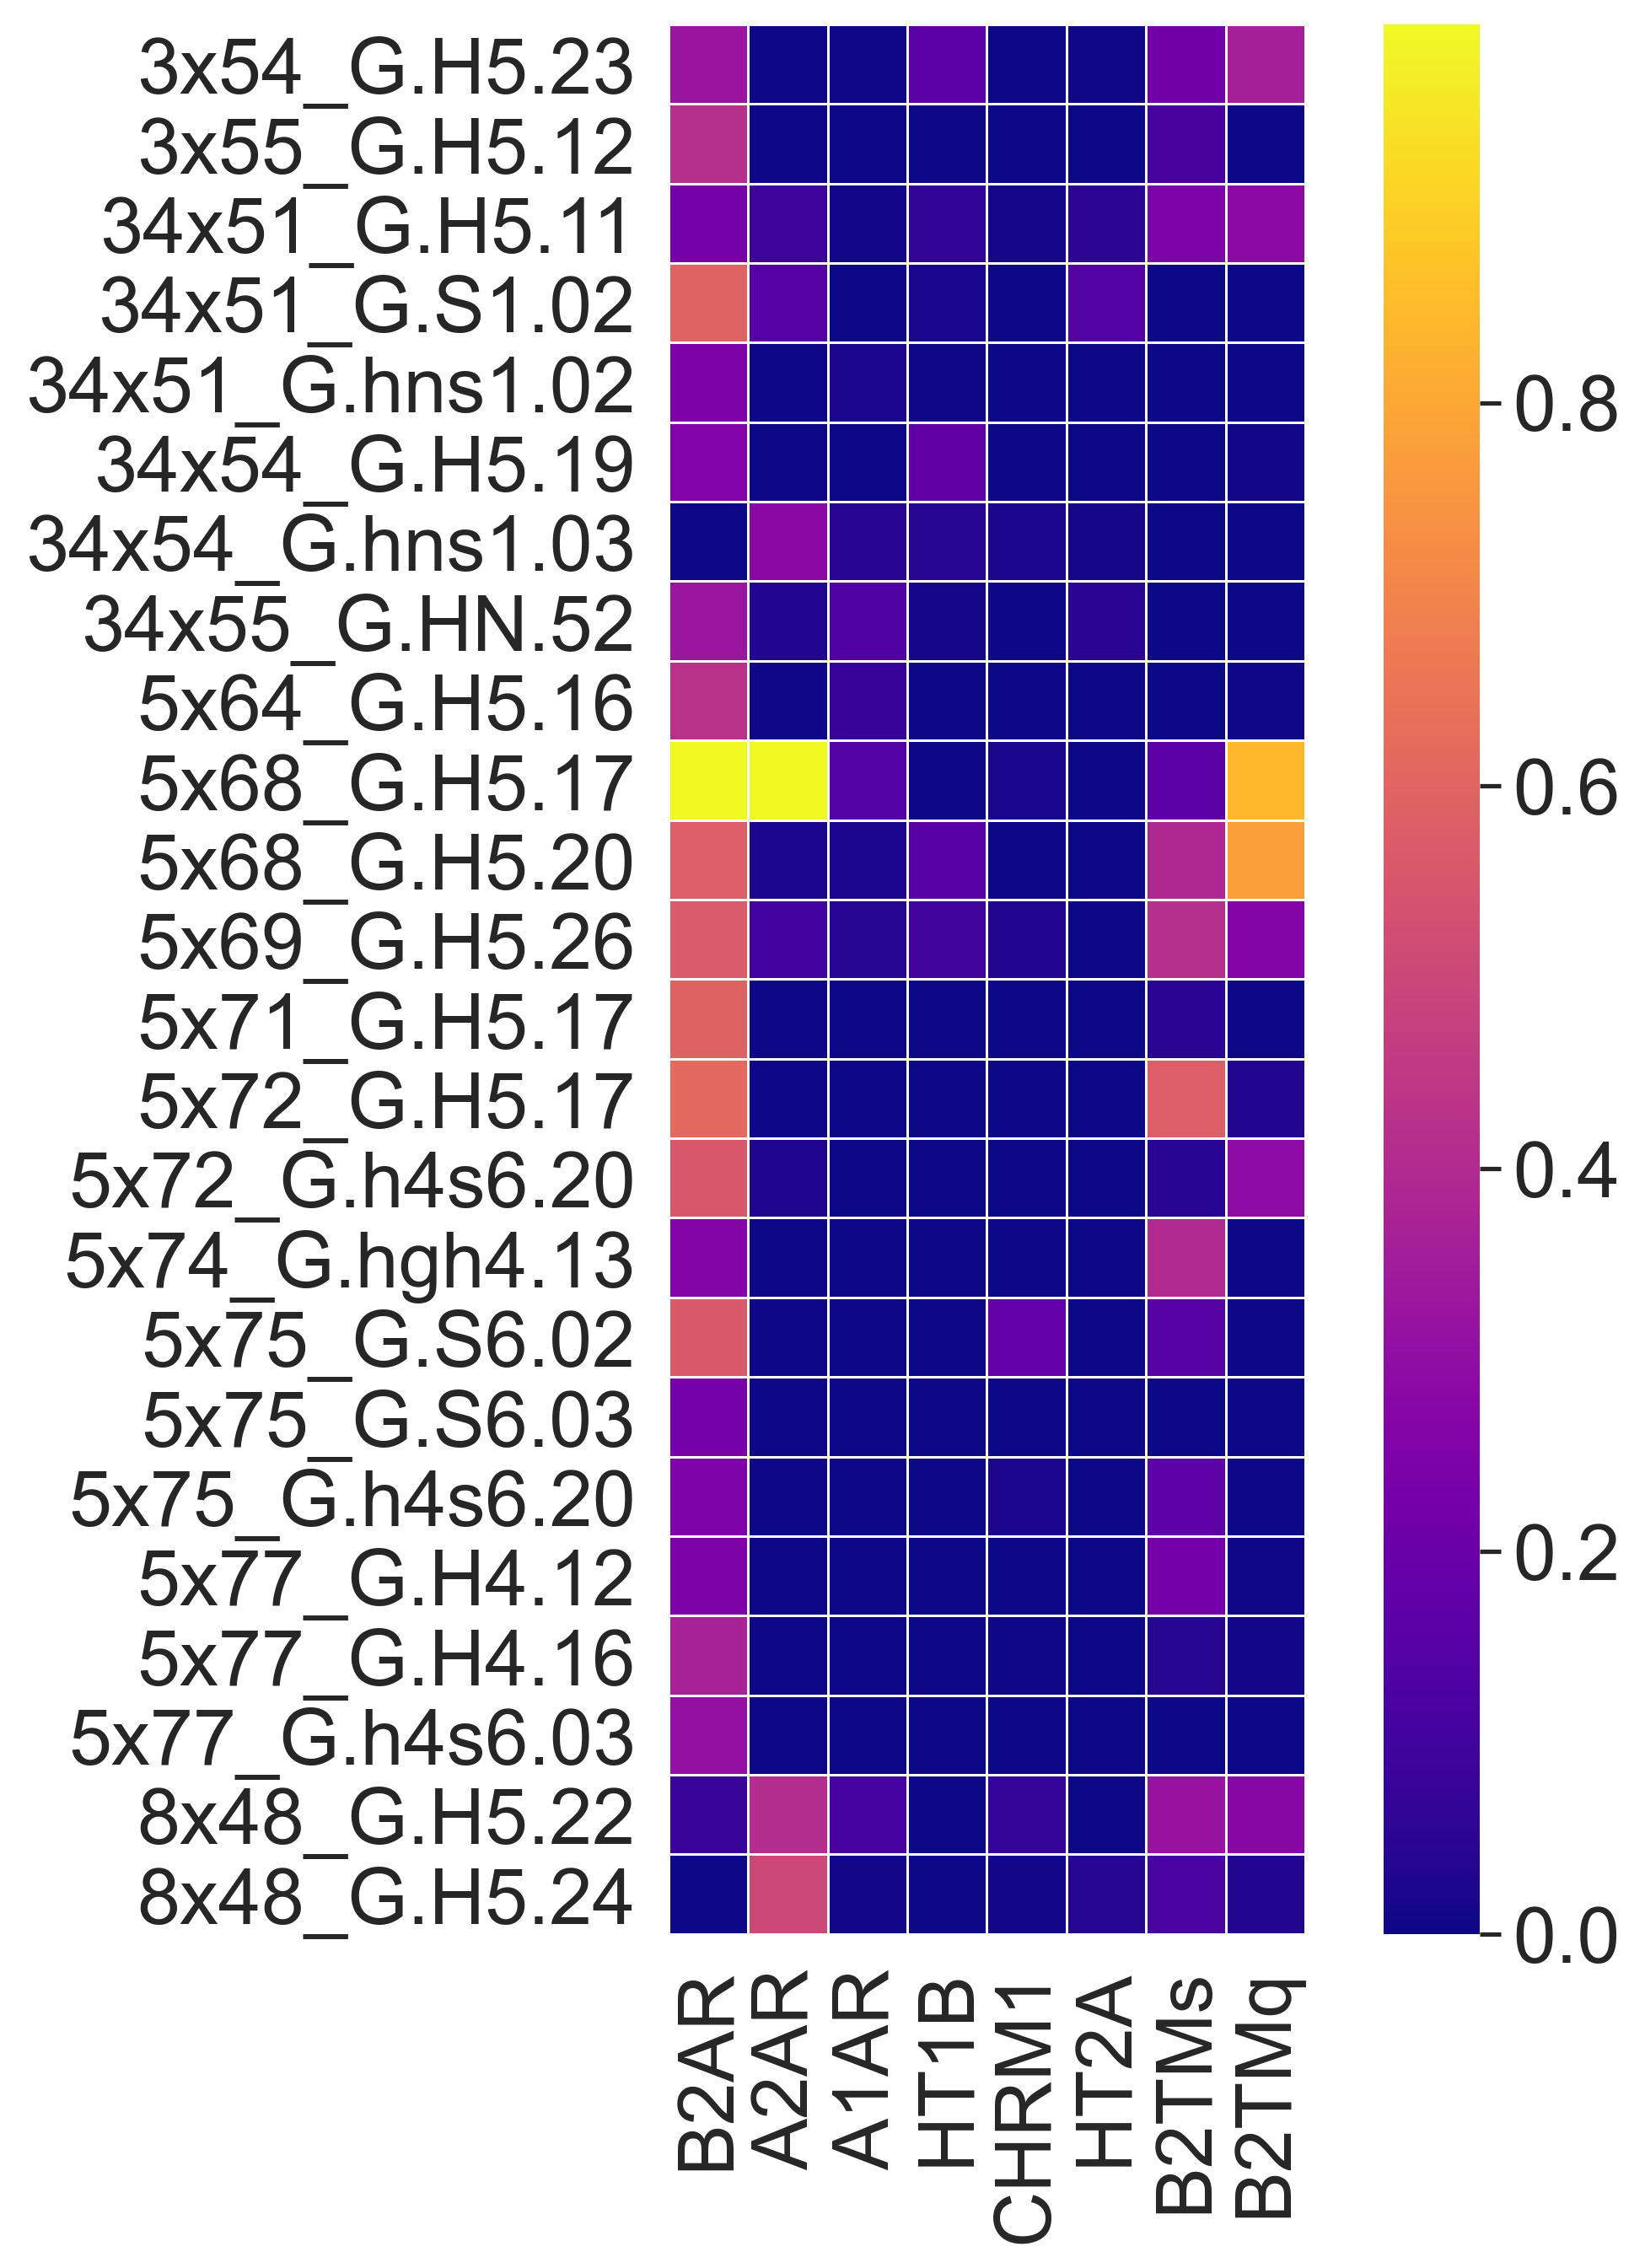

In [60]:
#Plot heatmap of Gs Specific contacts
sns.set(font_scale=2)
plt.figure(figsize=(8,10), dpi=300)
plt.tight_layout()
sns.heatmap(simulation_means.loc[gsspec2], yticklabels=gsspec2, square=True, cmap='plasma', linewidths=0.5, linecolor='white')
plt.savefig("Gs_specific_contacts_acrossGPCRs_heatmap_"+timestr+".eps", dpi=300, transparent=True)

In [38]:
gispec2 = ['12x49_G.h3s5.02', '2x40_G.H5.22','3x50_G.H5.22', '3x50_G.H5.25', '3x53_G.H5.22','34x52_G.s2s3.01', '34x55_G.S3.01','5x71_G.H5.09', '6x32_G.H5.25', '7x56_G.H5.22', '7x56_G.H5.23', '8x47_G.H5.21', '8x49_G.H5.22']

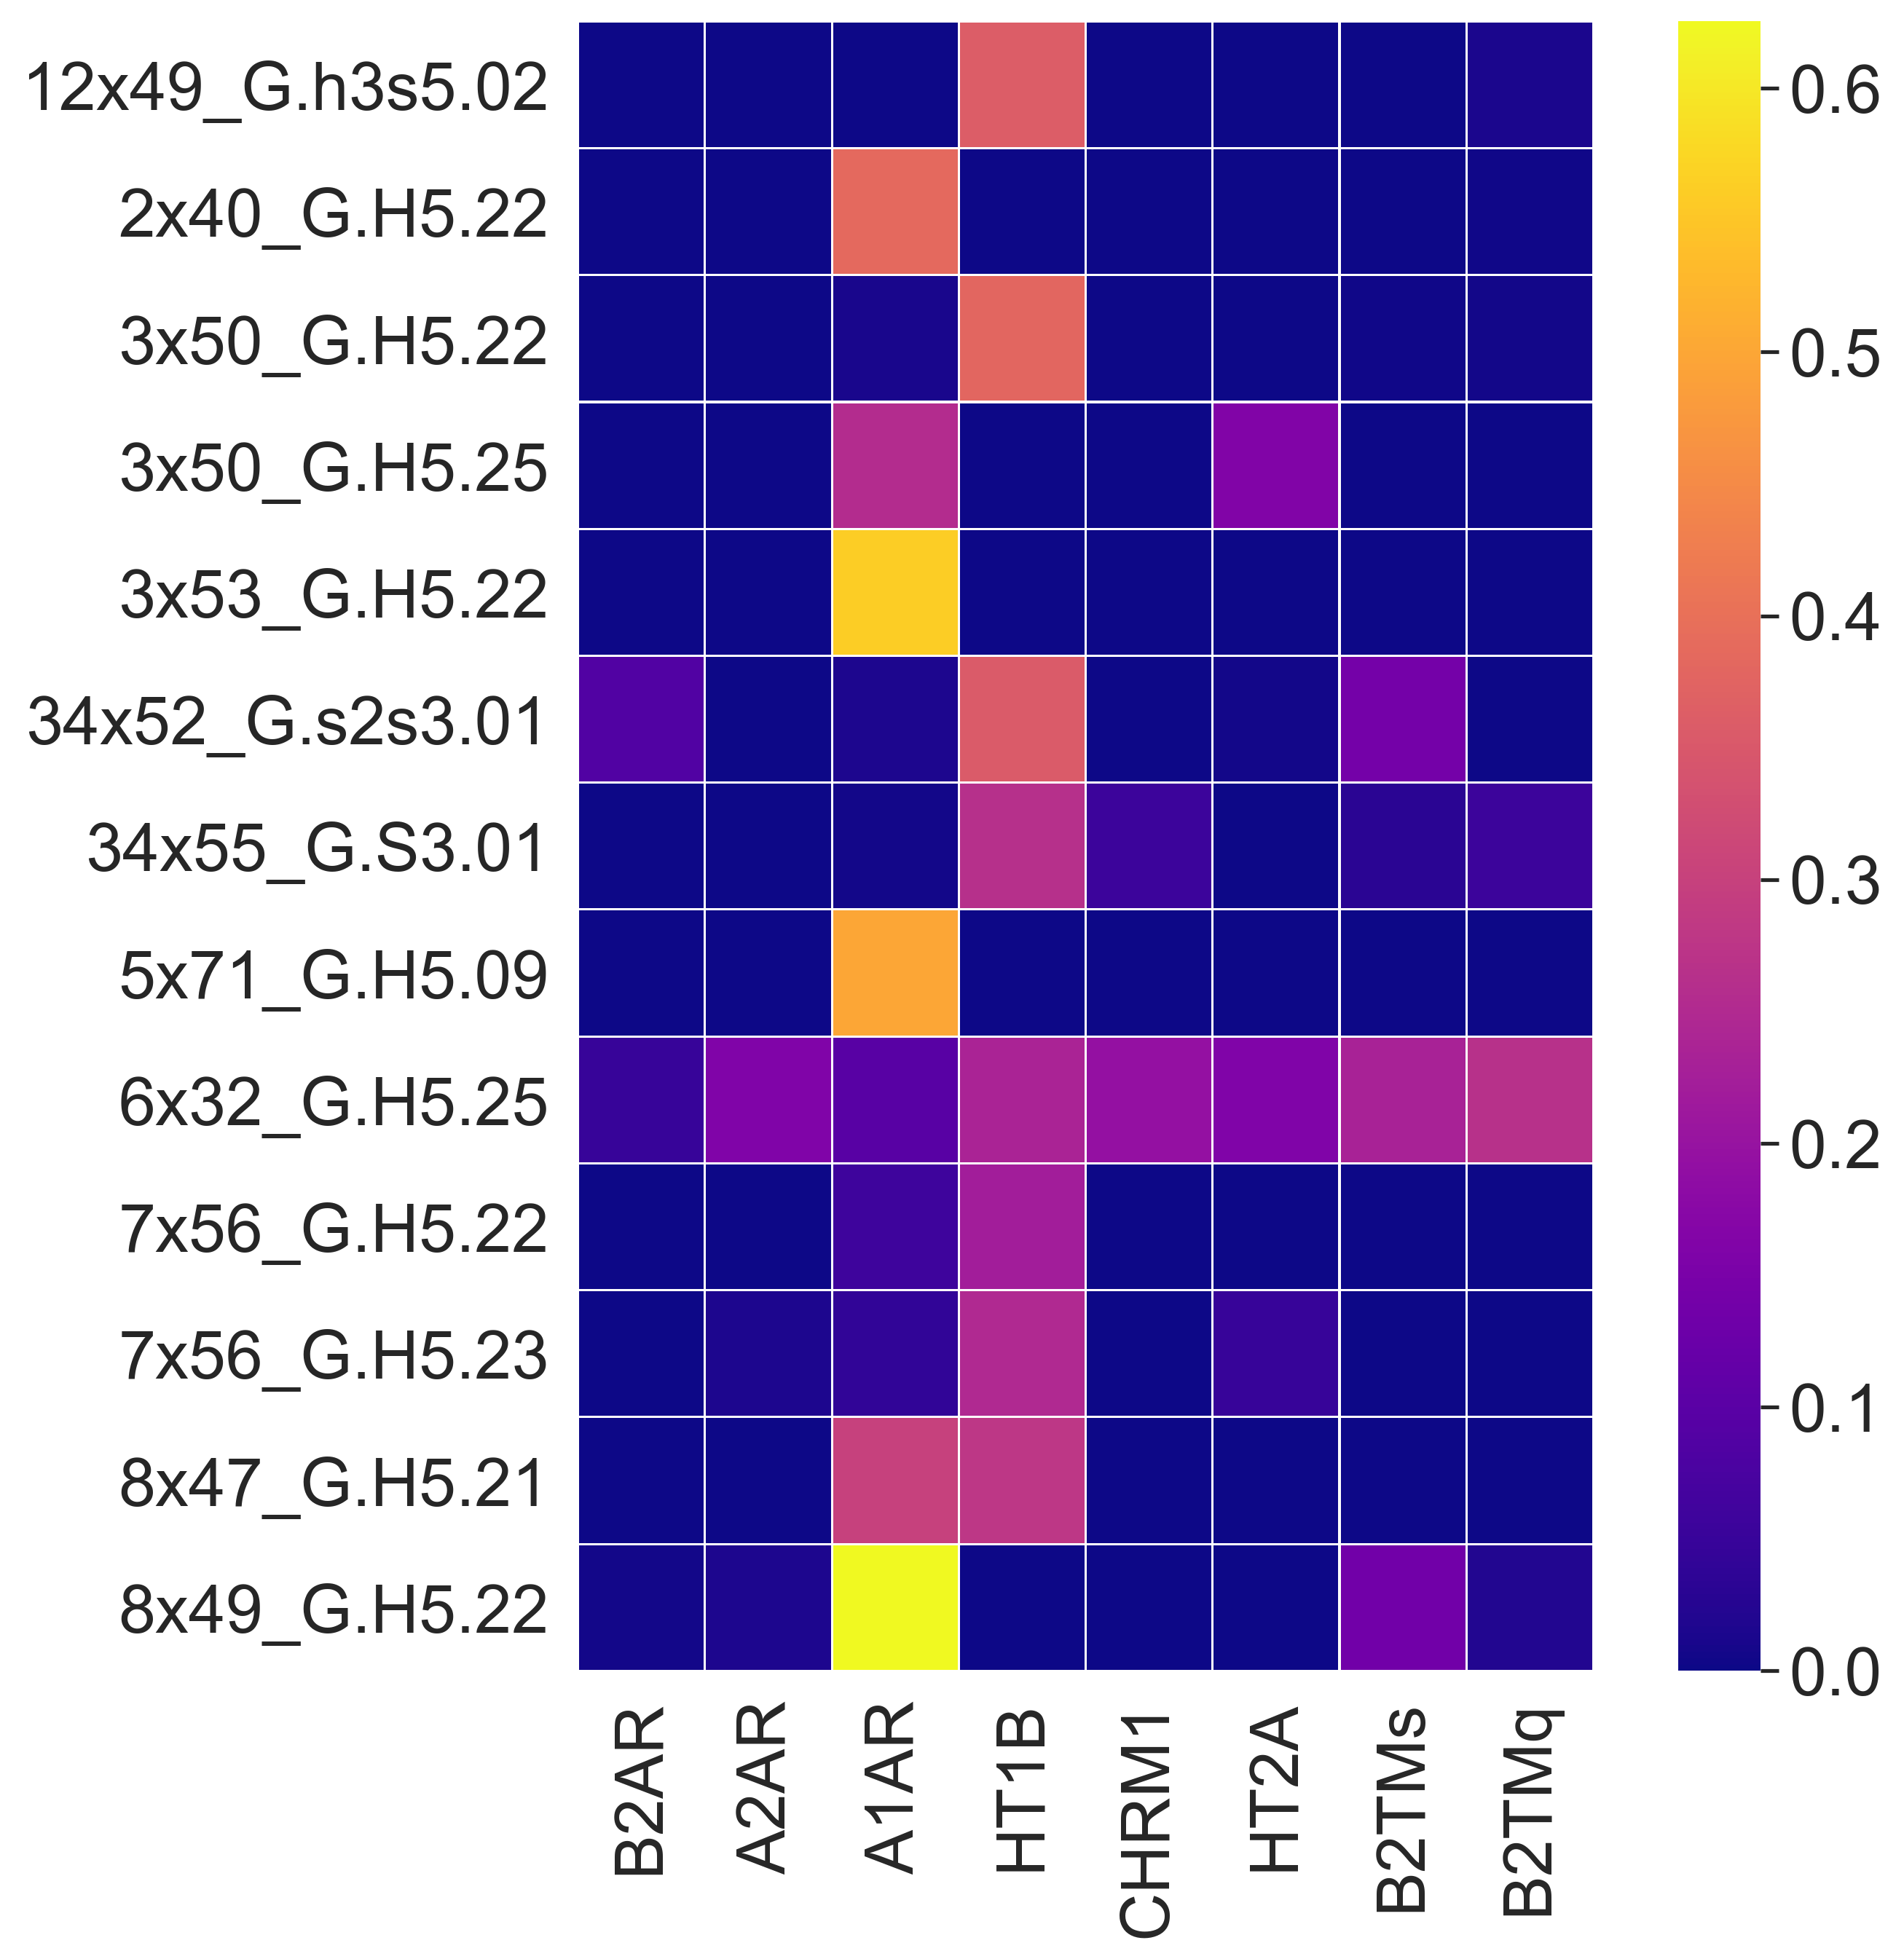

In [68]:
#Plot heatmap of Gi contacts
sns.set(font_scale=2)
plt.figure(figsize=(10,10), dpi=300)
plt.tight_layout()
sns.heatmap(simulation_means.loc[gispec2], yticklabels=gispec2, square=True, cmap='plasma', linewidths=0.5, linecolor='white')
plt.savefig("Gi_specific_contacts_acrossGPCRs_heatmap_"+timestr+".eps", dpi=300, transparent=True)

In [42]:
gqspec2 = ['2x37_G.H5.22', '2x37_G.H5.24', '2x39_G.H5.22', '2x39_G.H5.23', '2x39_G.H5.24', '2x40_G.H5.24','3x49_G.H5.23','34x51_G.s2s3.02', '34x53_G.H5.23', '34x55_G.s2s3.01', '34x56_G.hns1.02', '34x57_G.hns1.02','4x38_G.hns1.02', '4x39_G.H5.22', '6x30_G.H5.17', '6x33_G.H5.20', '8x48_G.H5.26', '8x49_G.H5.24']

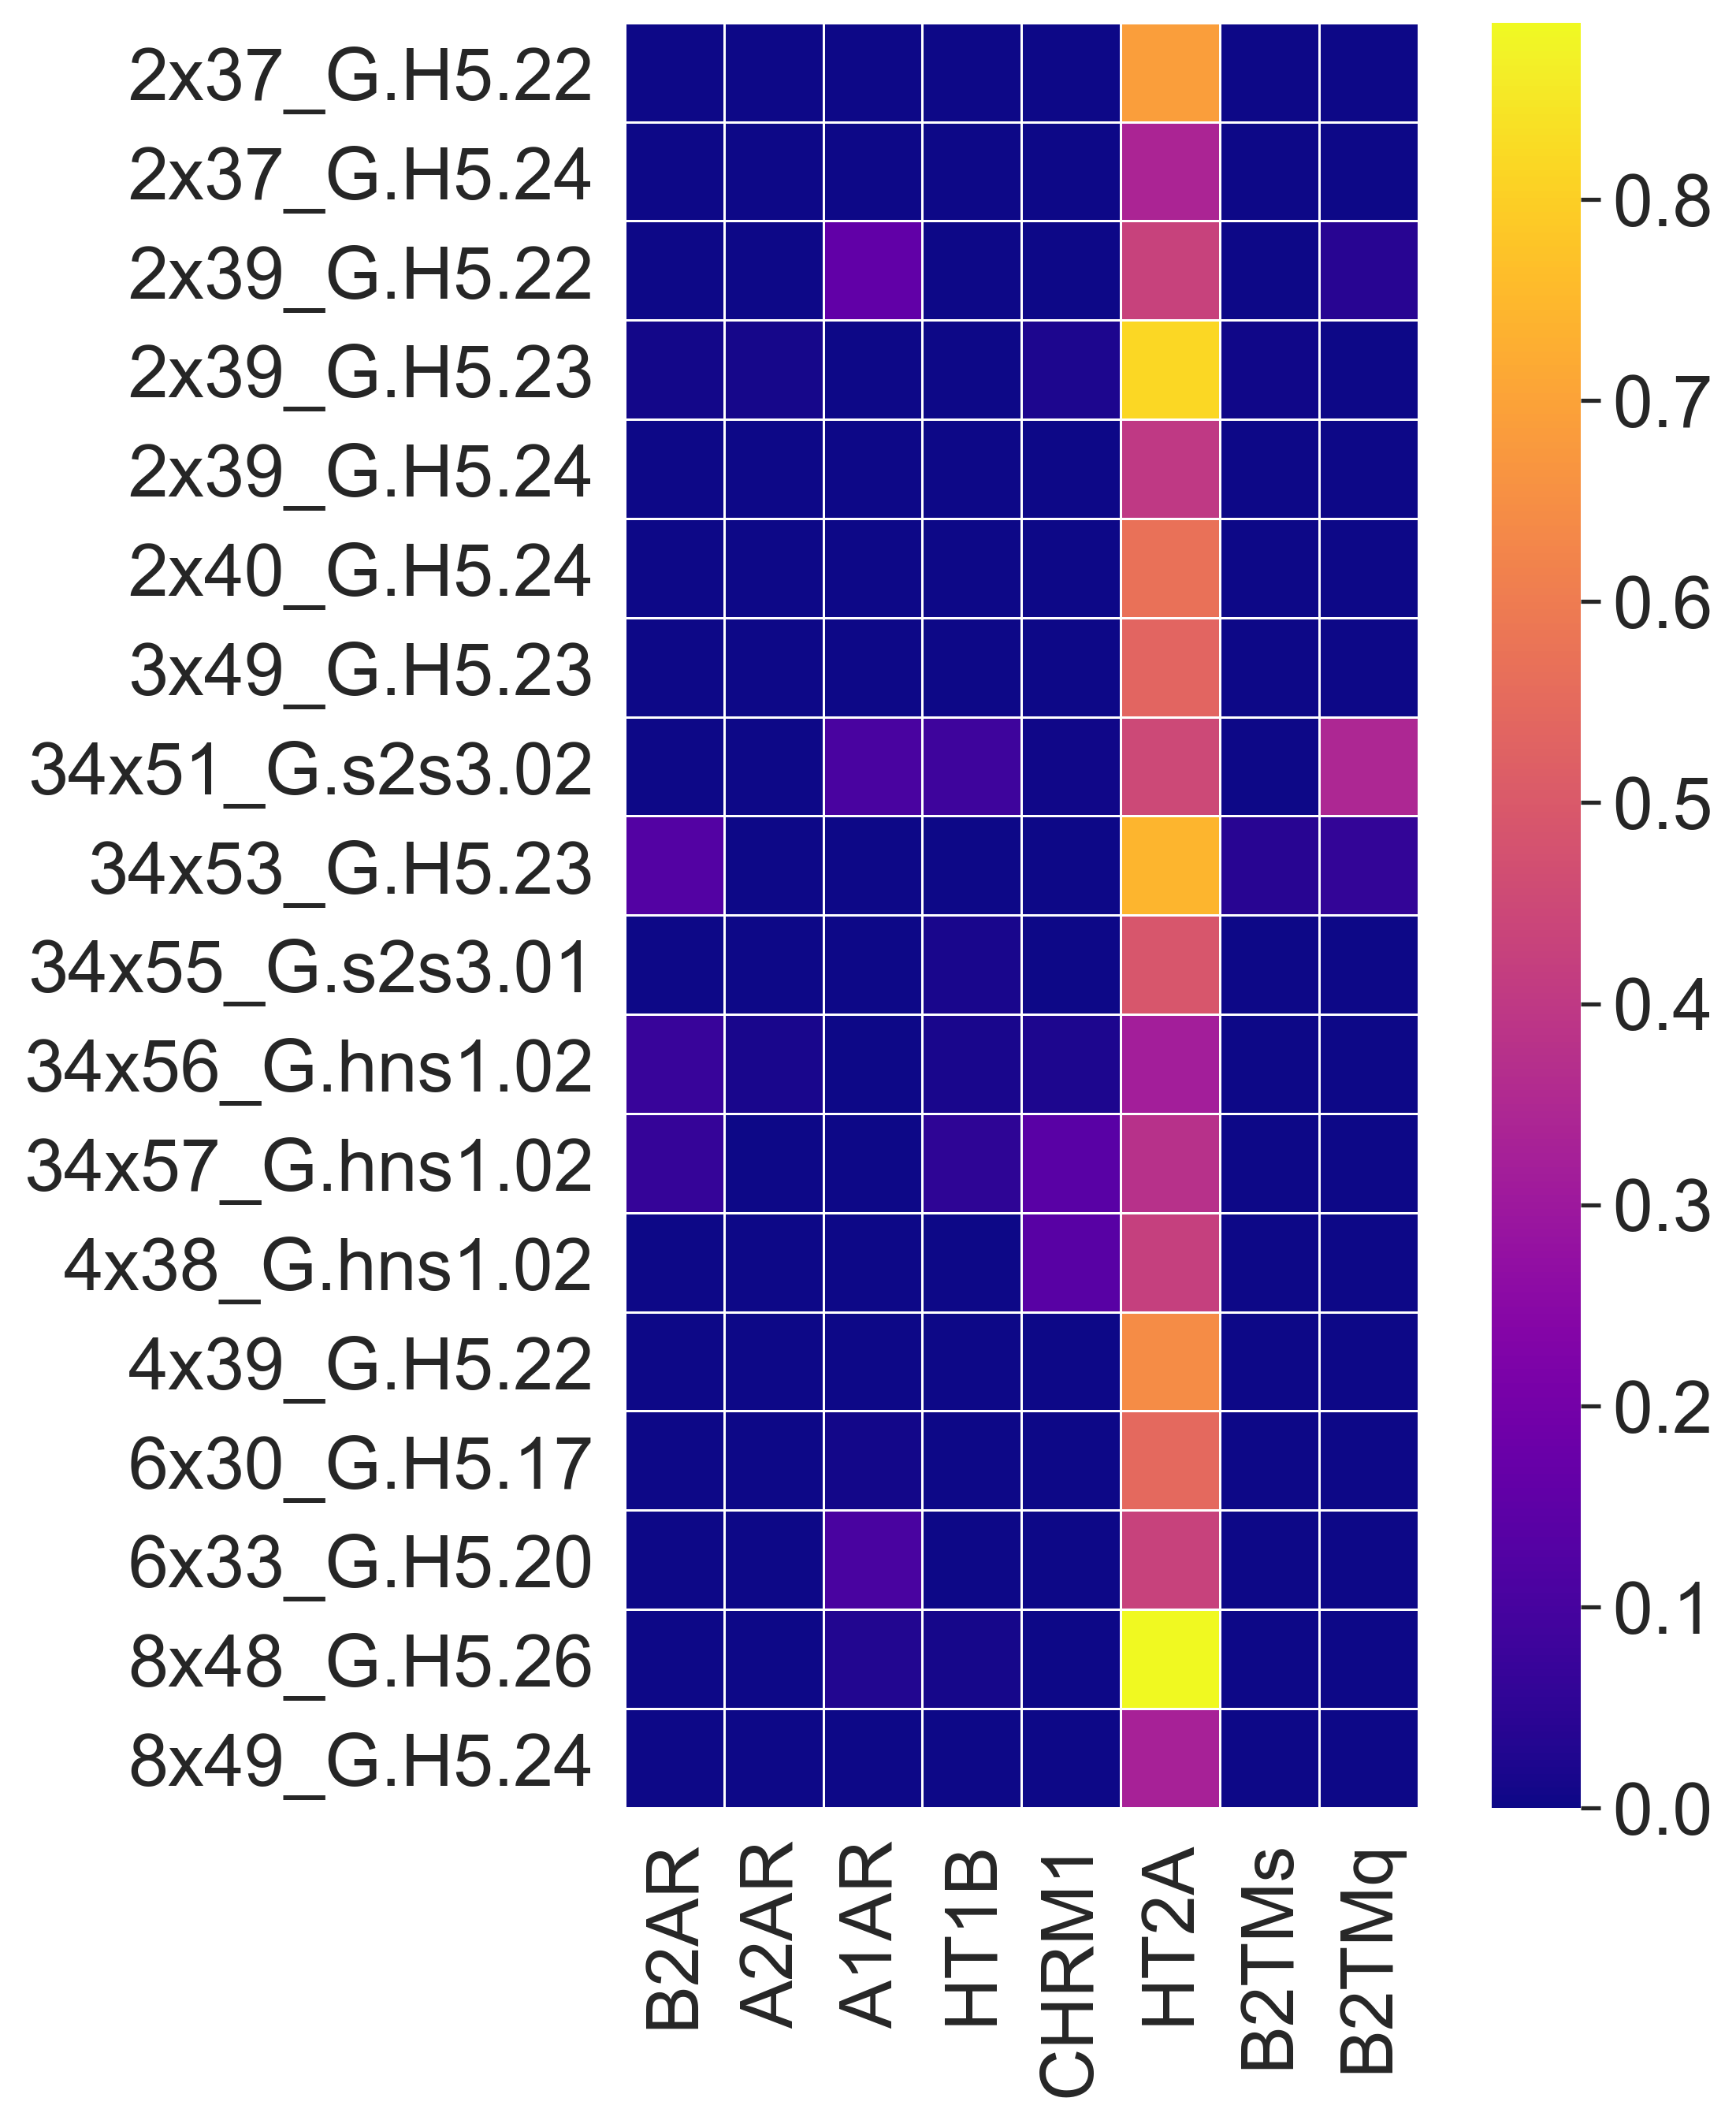

In [65]:
#Plot heatmap of Gq contacts
sns.set(font_scale=2)
plt.figure(figsize=(8,10), dpi=300)
plt.tight_layout()
sns.heatmap(simulation_means.loc[gqspec2], yticklabels=gqspec2, square=True, cmap='plasma', linewidths=0.5, linecolor='white')
plt.savefig("Gq_specific_contacts_acrossGPCRs_heatmap_"+timestr+".eps", dpi=300, transparent=True)

In [40]:
ordered_commall = ['3x50_G.H5.23', '3x53_G.H5.19', '3x53_G.H5.23', '3x54_G.H5.16', '3x54_G.H5.20', '34x50_G.H5.12', '34x50_G.H5.15', '34x50_G.H5.16', '34x50_G.H5.19', '34x51_G.H5.08', '34x51_G.H5.12', '34x51_G.H5.15', '34x51_G.S3.01', '34x55_G.hns1.02', '34x55_G.hns1.03', '5x65_G.H5.20', '5x68_G.H5.16', '6x32_G.H5.26', '6x33_G.H5.25', '6x36_G.H5.25', '6x37_G.H5.25', '7x56_G.H5.24', '8x47_G.H5.22']

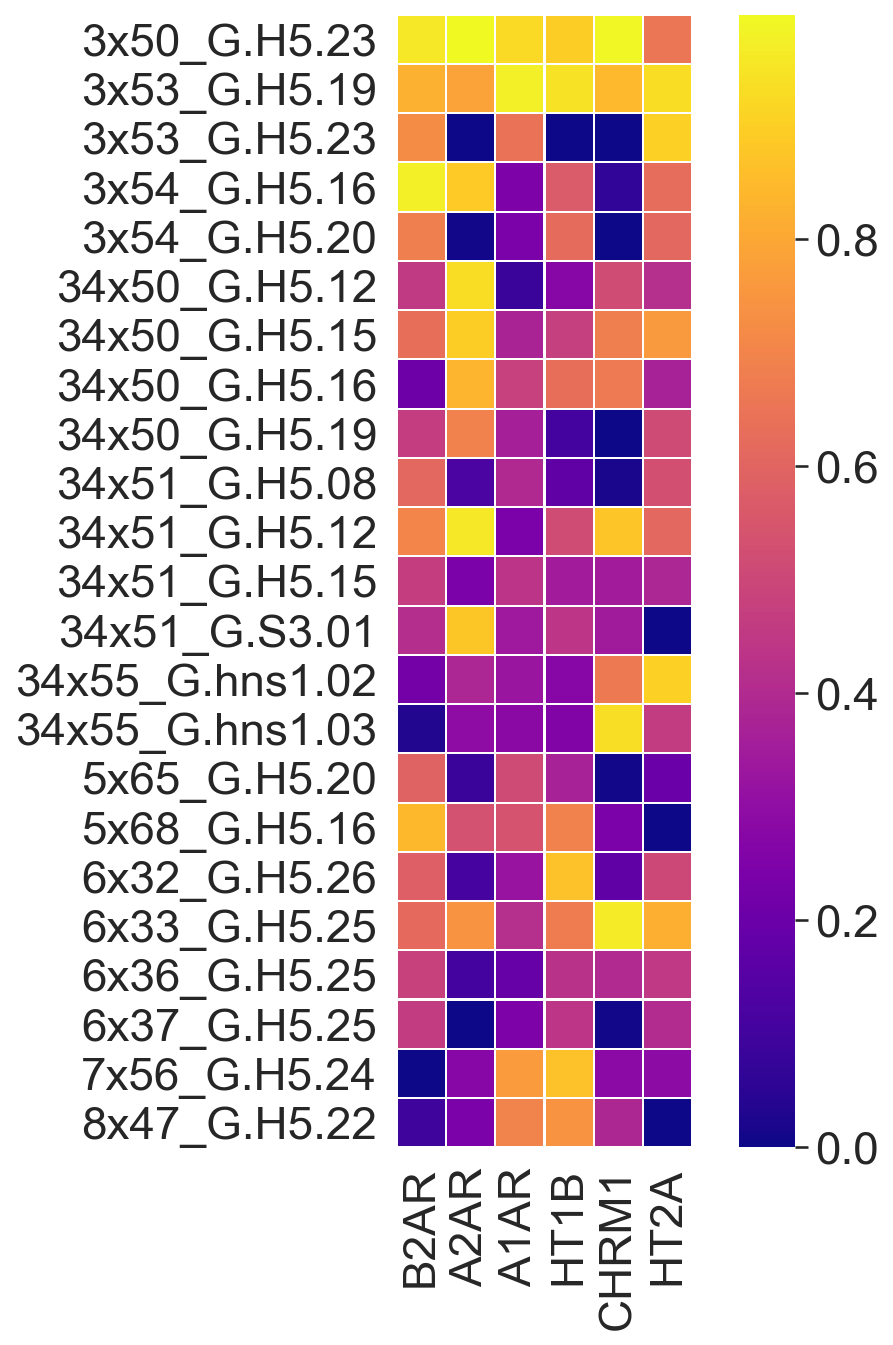

In [139]:
#Plot heatmap of common contacts from original 6 simulations
sns.set(font_scale=2)
plt.figure(figsize=(8,10), dpi=150)
sns.heatmap(main_means.loc[ordered_commall], yticklabels=ordered_commall, square=True, cmap='plasma', linewidths=0.5, linecolor='white')
plt.savefig("common_class_contacts_acrossGPCRs_heatmap_"+timestr+".png", dpi=300, transparent=True)

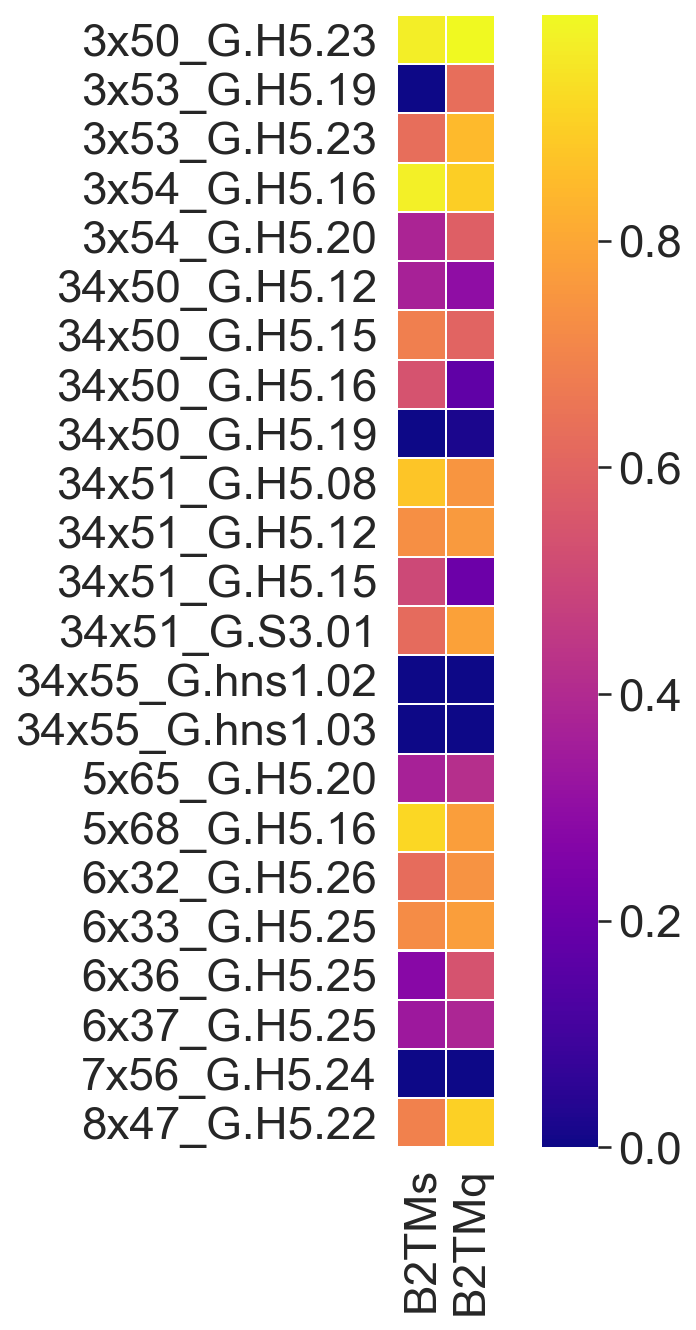

In [140]:
#Plot heatmap of common contacts from ADRB2-TM simulations
sns.set(font_scale=2)
plt.figure(figsize=(8,10), dpi=150)
sns.heatmap(simulation_means[["B2TMs","B2TMq"]].loc[ordered_commall], yticklabels=ordered_commall, square=True, cmap='plasma', linewidths=0.5, linecolor='white')
plt.savefig("common_class_contacts_inPromGPCRs_heatmap_"+timestr+".png", dpi=300, transparent=True)

In [141]:
col=plt.get_cmap("Greys")

In [142]:
#function to count number of contacts from different secondary structural elements from GPCR and G proteins
def cont_counter(list1):
    df1 = pd.DataFrame(0, index=gpcrss, columns=["contacts"])
    df2 = pd.DataFrame(0, index=gprotss, columns=["contacts"])
    
    for i in list1:
        nam=str(i).split('_')
        SS=nam[0].split('x')
        TM="TM"+str(SS[0])
        gp=nam[1].split(".")
        df1.loc[TM,'contacts']+=1
        df2.loc[gp[1],'contacts']+=1
    df1=df1[(df1!=0)].dropna()
    df2=df2[(df2!=0)].dropna()
    print(df1)
    print(df2)
    return df1, df2

      contacts
TM34      10.0
TM3        5.0
TM5        2.0
TM6        4.0
TM7        1.0
TM8        1.0
      contacts
hns1       2.0
H5        20.0
S3         1.0


<ipython-input-143-df159b1a376c>:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(commcontdfs[0], labels=['ICL2','TM3','TM5','TM6','TM7','TM8'], labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,50)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1,'edgecolor':'black'})
<ipython-input-143-df159b1a376c>:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(commcontdfs[1], labels=commcontdfs[1].index.values, labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,50)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1, 'edgecolor':'black'})


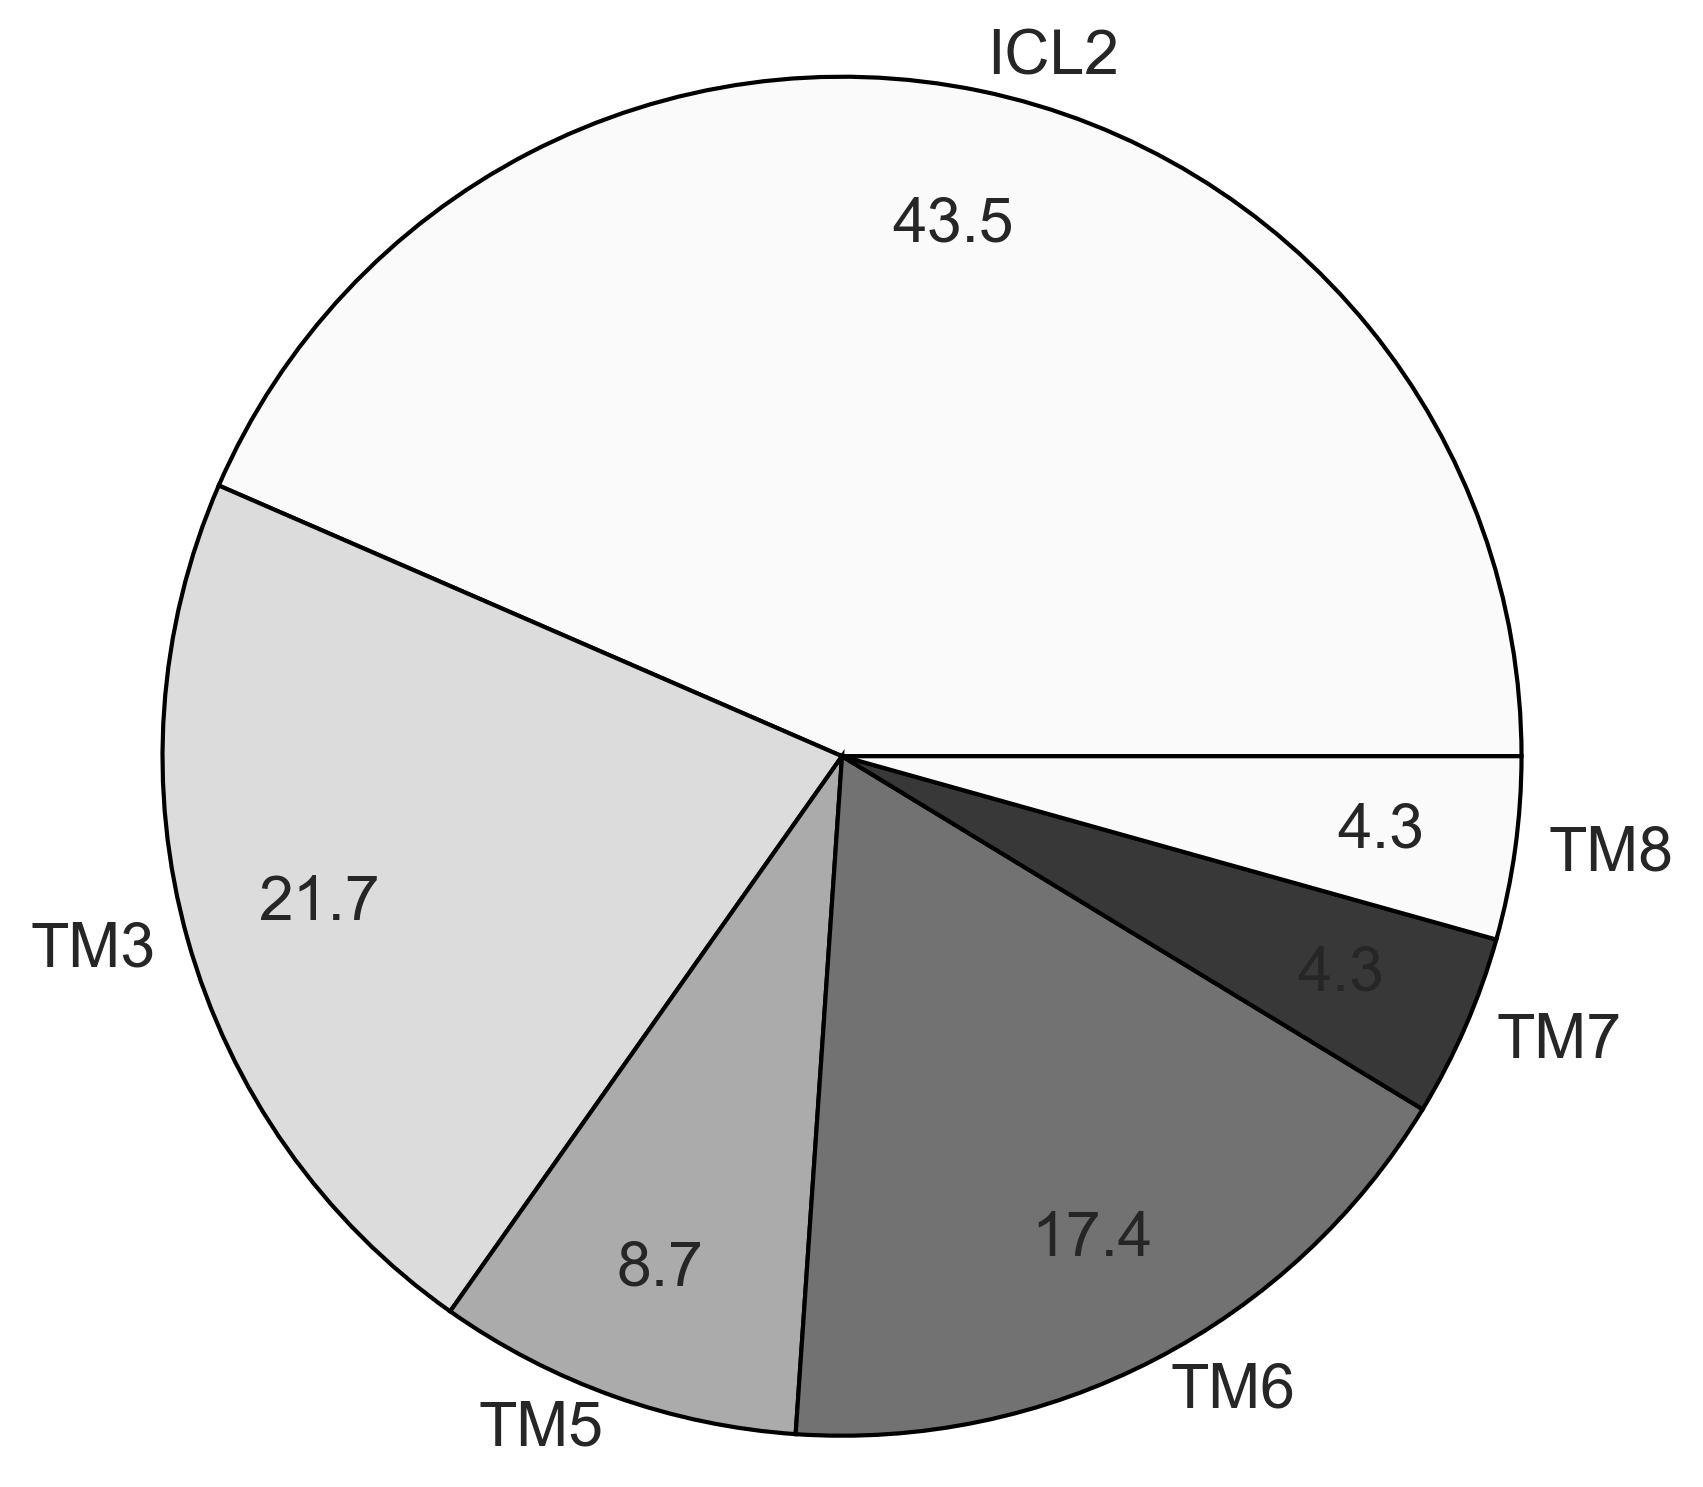

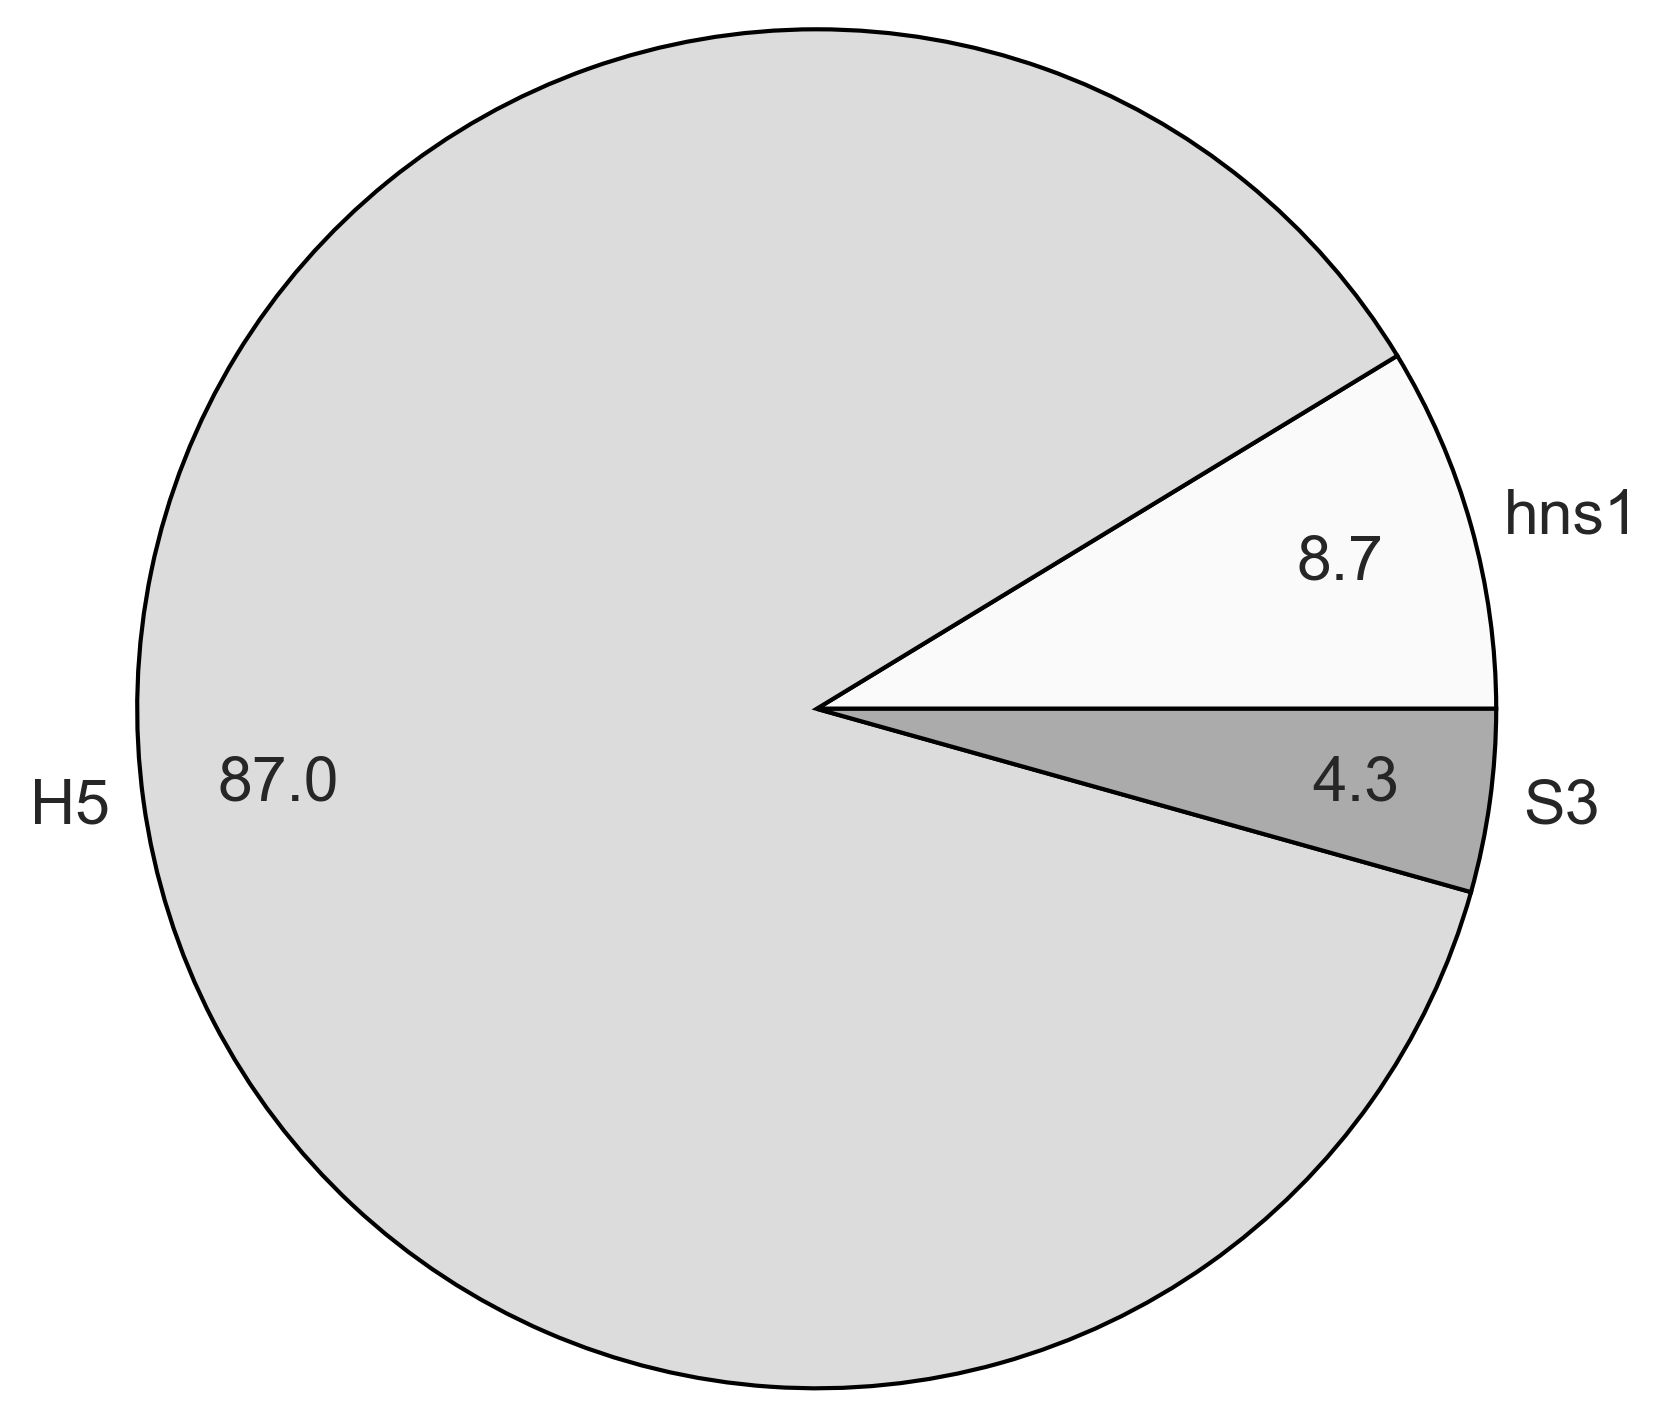

In [143]:
#calculate the number of common contacts from different secondary structural elements of GPCR and G protein
commcontdfs = cont_counter(commall)
commcontdfs[0].to_csv("common_gpcrSS_cont_count.txt", sep='\t')
commcontdfs[1].to_csv("common_gprotSS_cont_count.txt", sep='\t')

plt.figure(figsize=(6,6), dpi=300)
plt.pie(commcontdfs[0], labels=['ICL2','TM3','TM5','TM6','TM7','TM8'], labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,50)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1,'edgecolor':'black'})
plt.savefig("comm_gpcrSS_cont_pie.eps", transparent=True, dpi=300)

plt.figure(figsize=(6,6), dpi=300)
plt.pie(commcontdfs[1], labels=commcontdfs[1].index.values, labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,50)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1, 'edgecolor':'black'})
plt.savefig("comm_gprotSS_cont_pie.eps", transparent=True, dpi=300)

      contacts
TM34       6.0
TM3        2.0
TM5       14.0
TM8        2.0
      contacts
HN         1.0
S1         1.0
h4s6       3.0
hns1       2.0
H5        12.0
H4         2.0
S6         2.0
hgh4       1.0


<ipython-input-144-1cb56e8f40ef>:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(gscontdfs[0], labels=['ICL2','TM3','TM5','H8'], labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,30)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1,'edgecolor':'black'})
<ipython-input-144-1cb56e8f40ef>:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(gscontdfs[1], labels=gscontdfs[1].index.values, labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,20)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1, 'edgecolor':'black'})


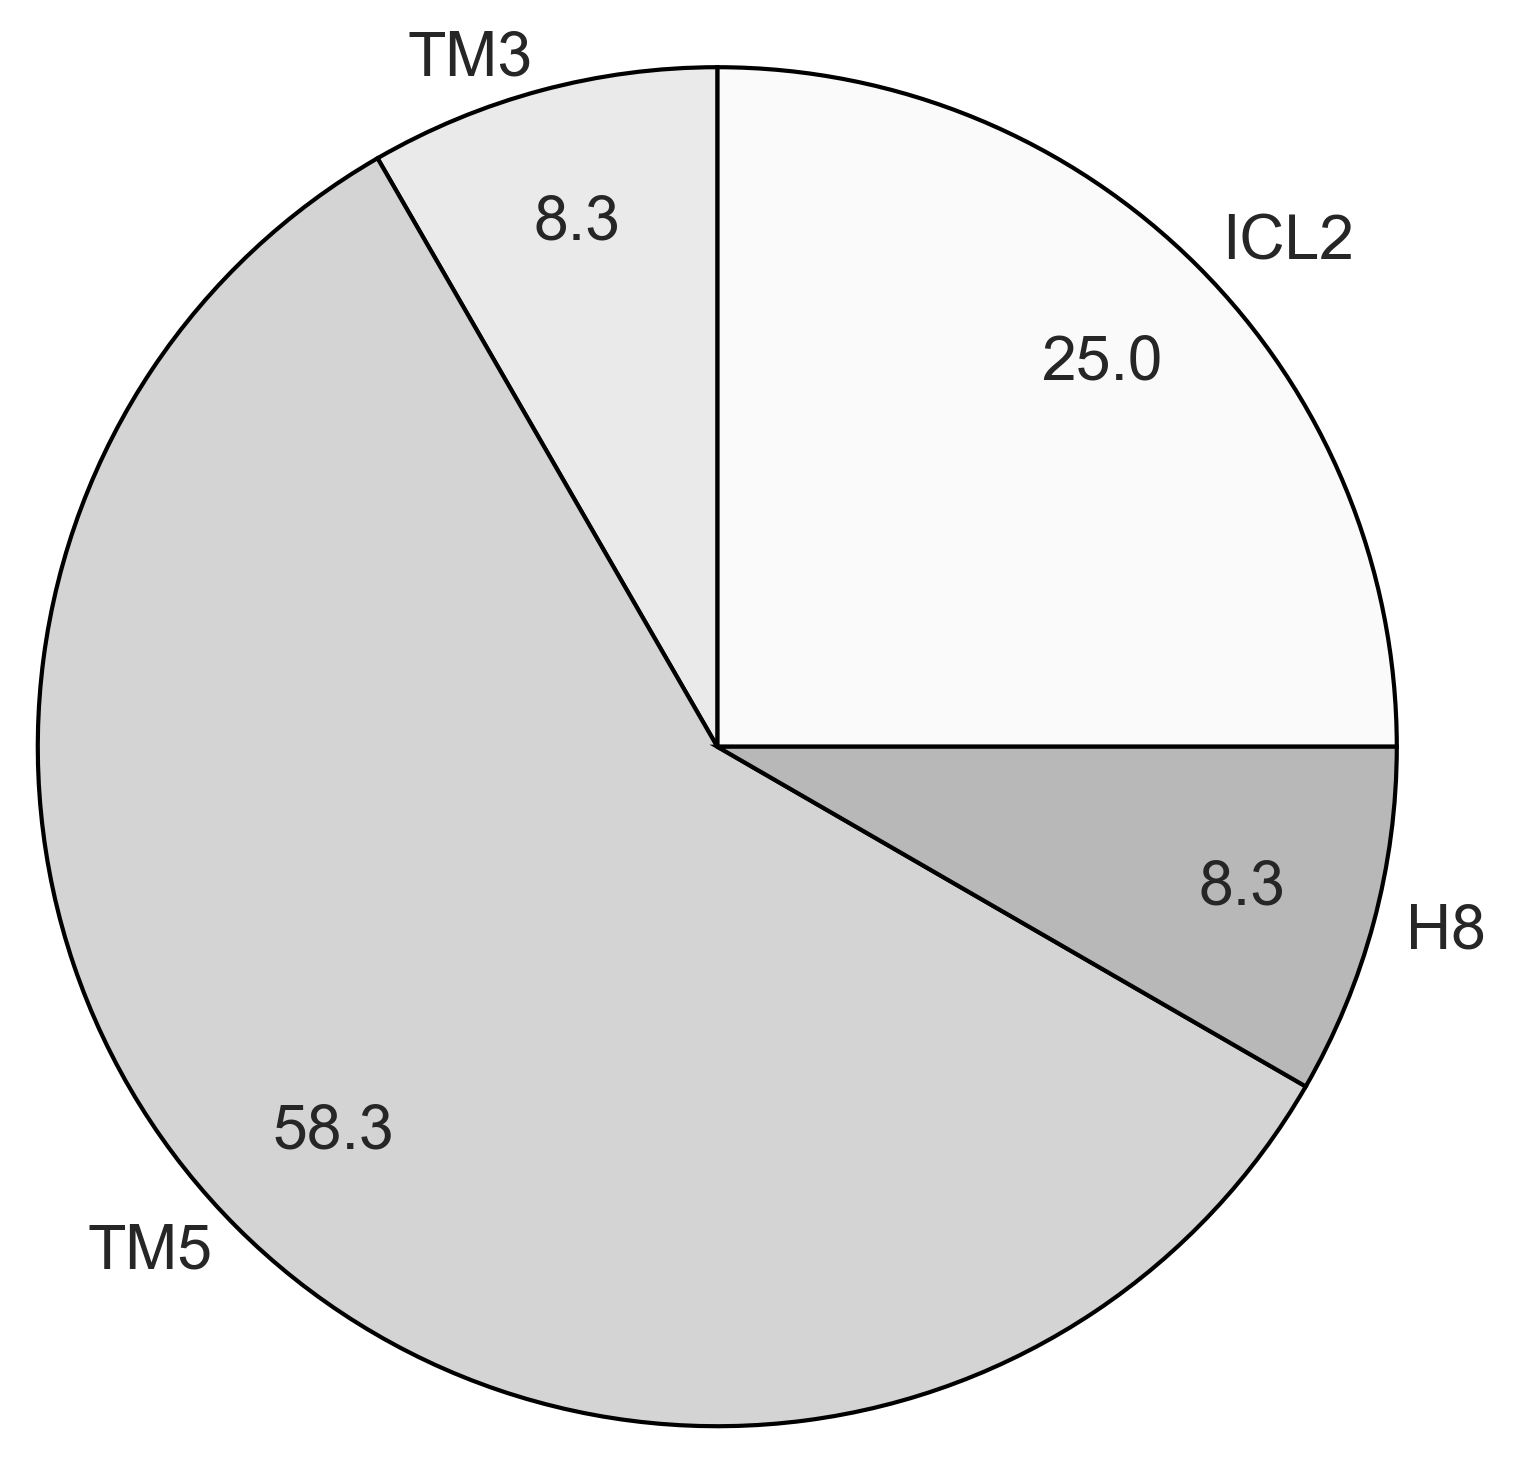

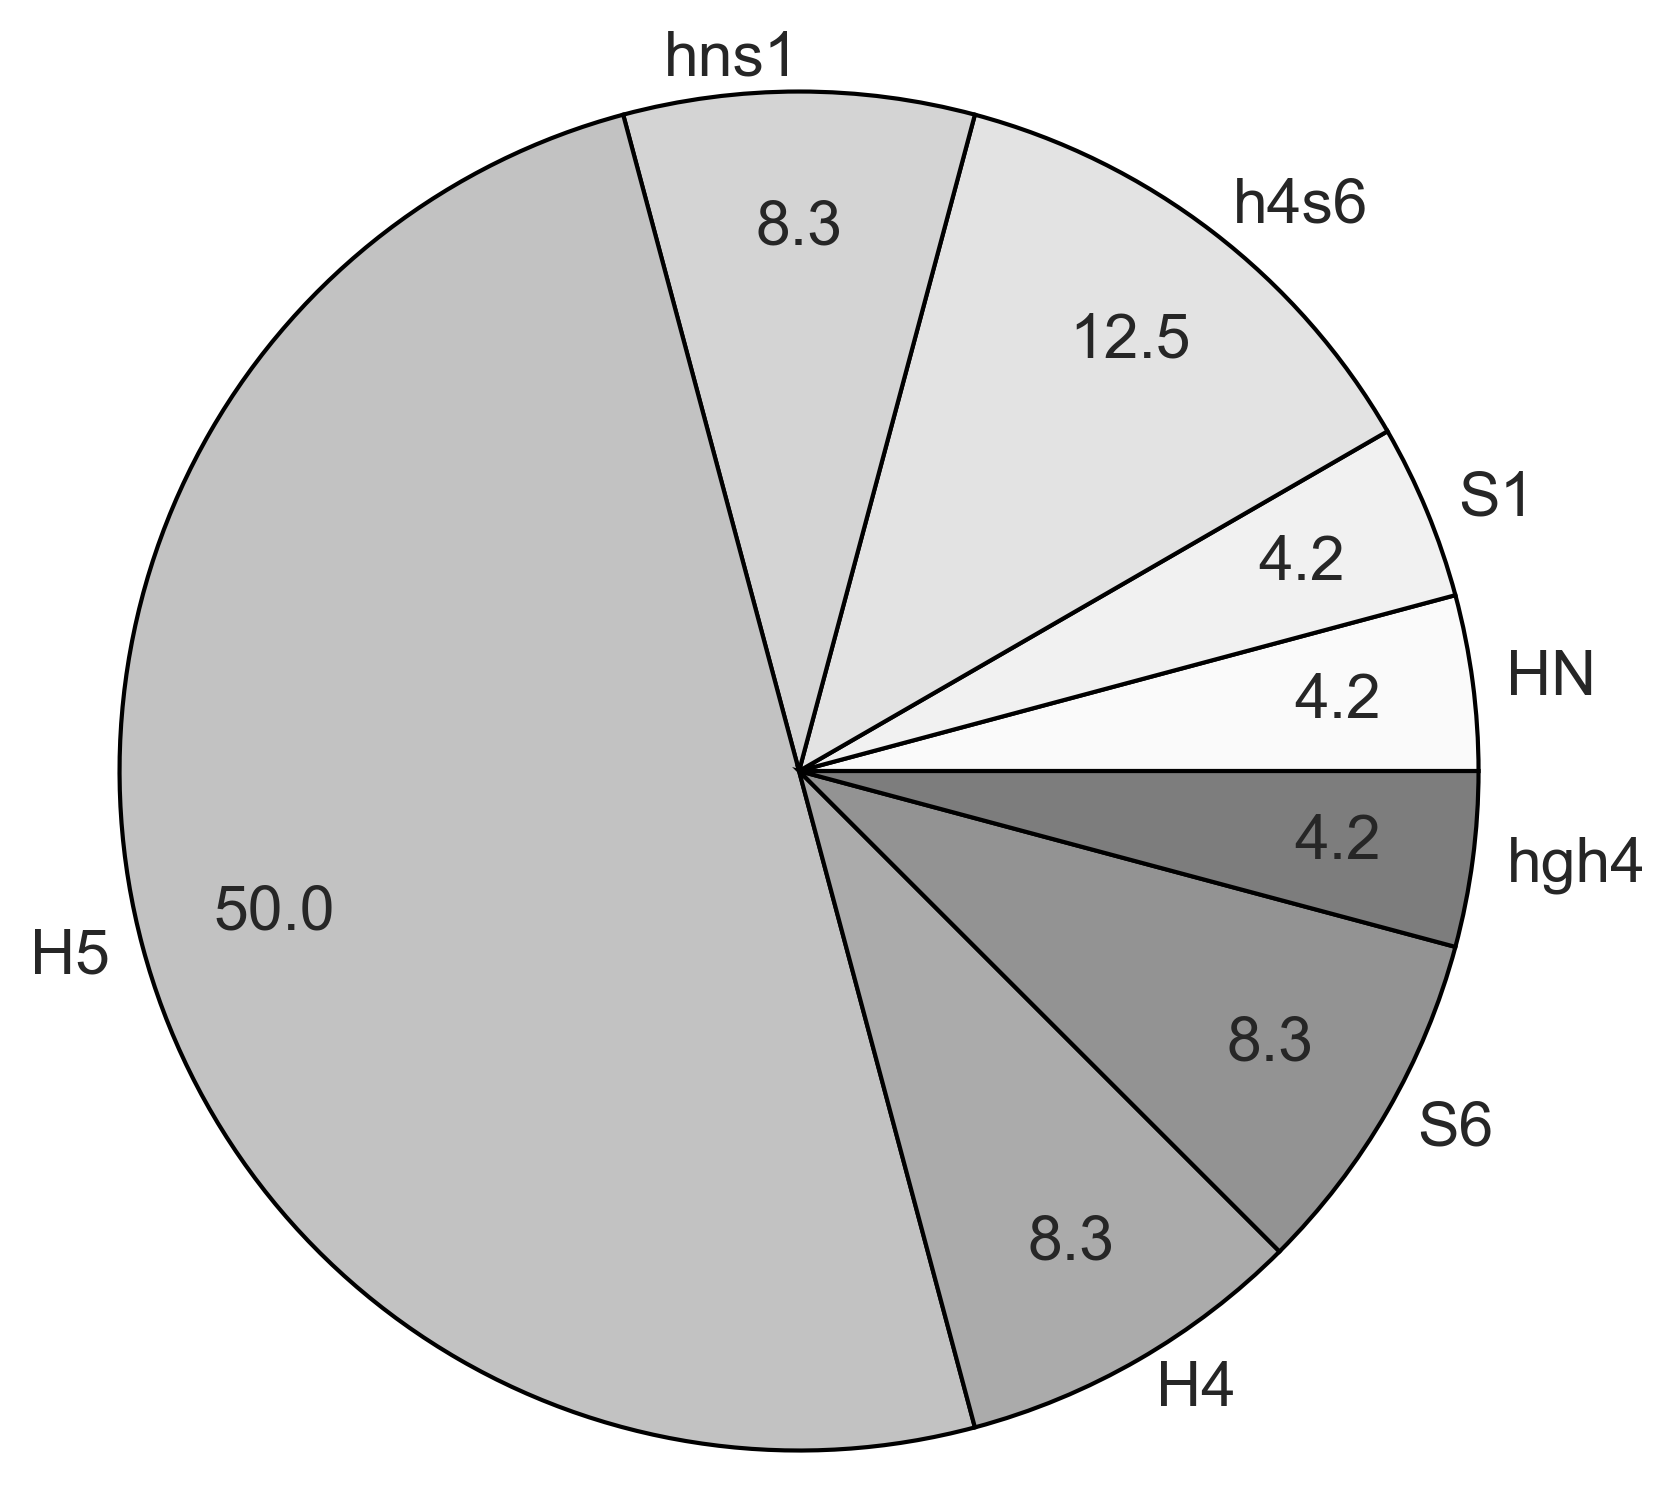

In [144]:
#calculate the number of Gs contacts from different secondary structural elements of GPCR and G protein
gscontdfs = cont_counter(gsspec)
gscontdfs[0].to_csv("Gs_gpcrSS_cont_count.txt", sep='\t')
gscontdfs[1].to_csv("Gs_gprotSS_cont_count.txt", sep='\t')

plt.figure(figsize=(6,6), dpi=300)
plt.pie(gscontdfs[0], labels=['ICL2','TM3','TM5','H8'], labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,30)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1,'edgecolor':'black'})
plt.savefig("Gs_gpcrSS_cont_pie.eps", transparent=True, dpi=300)

plt.figure(figsize=(6,6), dpi=300)
plt.pie(gscontdfs[1], labels=gscontdfs[1].index.values, labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,20)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1, 'edgecolor':'black'})
plt.savefig("Gs_gprotSS_cont_pie.eps", transparent=True, dpi=300)

      contacts
TM12       1.0
TM2        1.0
TM34       2.0
TM3        3.0
TM5        1.0
TM6        1.0
TM7        2.0
TM8        2.0
      contacts
h3s5       1.0
H5        10.0
S3         1.0
s2s3       1.0


<ipython-input-145-c970b1d5e662>:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(gicontdfs[0], labels=['ICL1','TM2','ICL2','TM3','TM5','TM6','TM7','H8'], labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,25)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1,'edgecolor':'black'})
<ipython-input-145-c970b1d5e662>:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(gicontdfs[1], labels=gicontdfs[1].index.values, labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,30)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1, 'edgecolor':'black'})


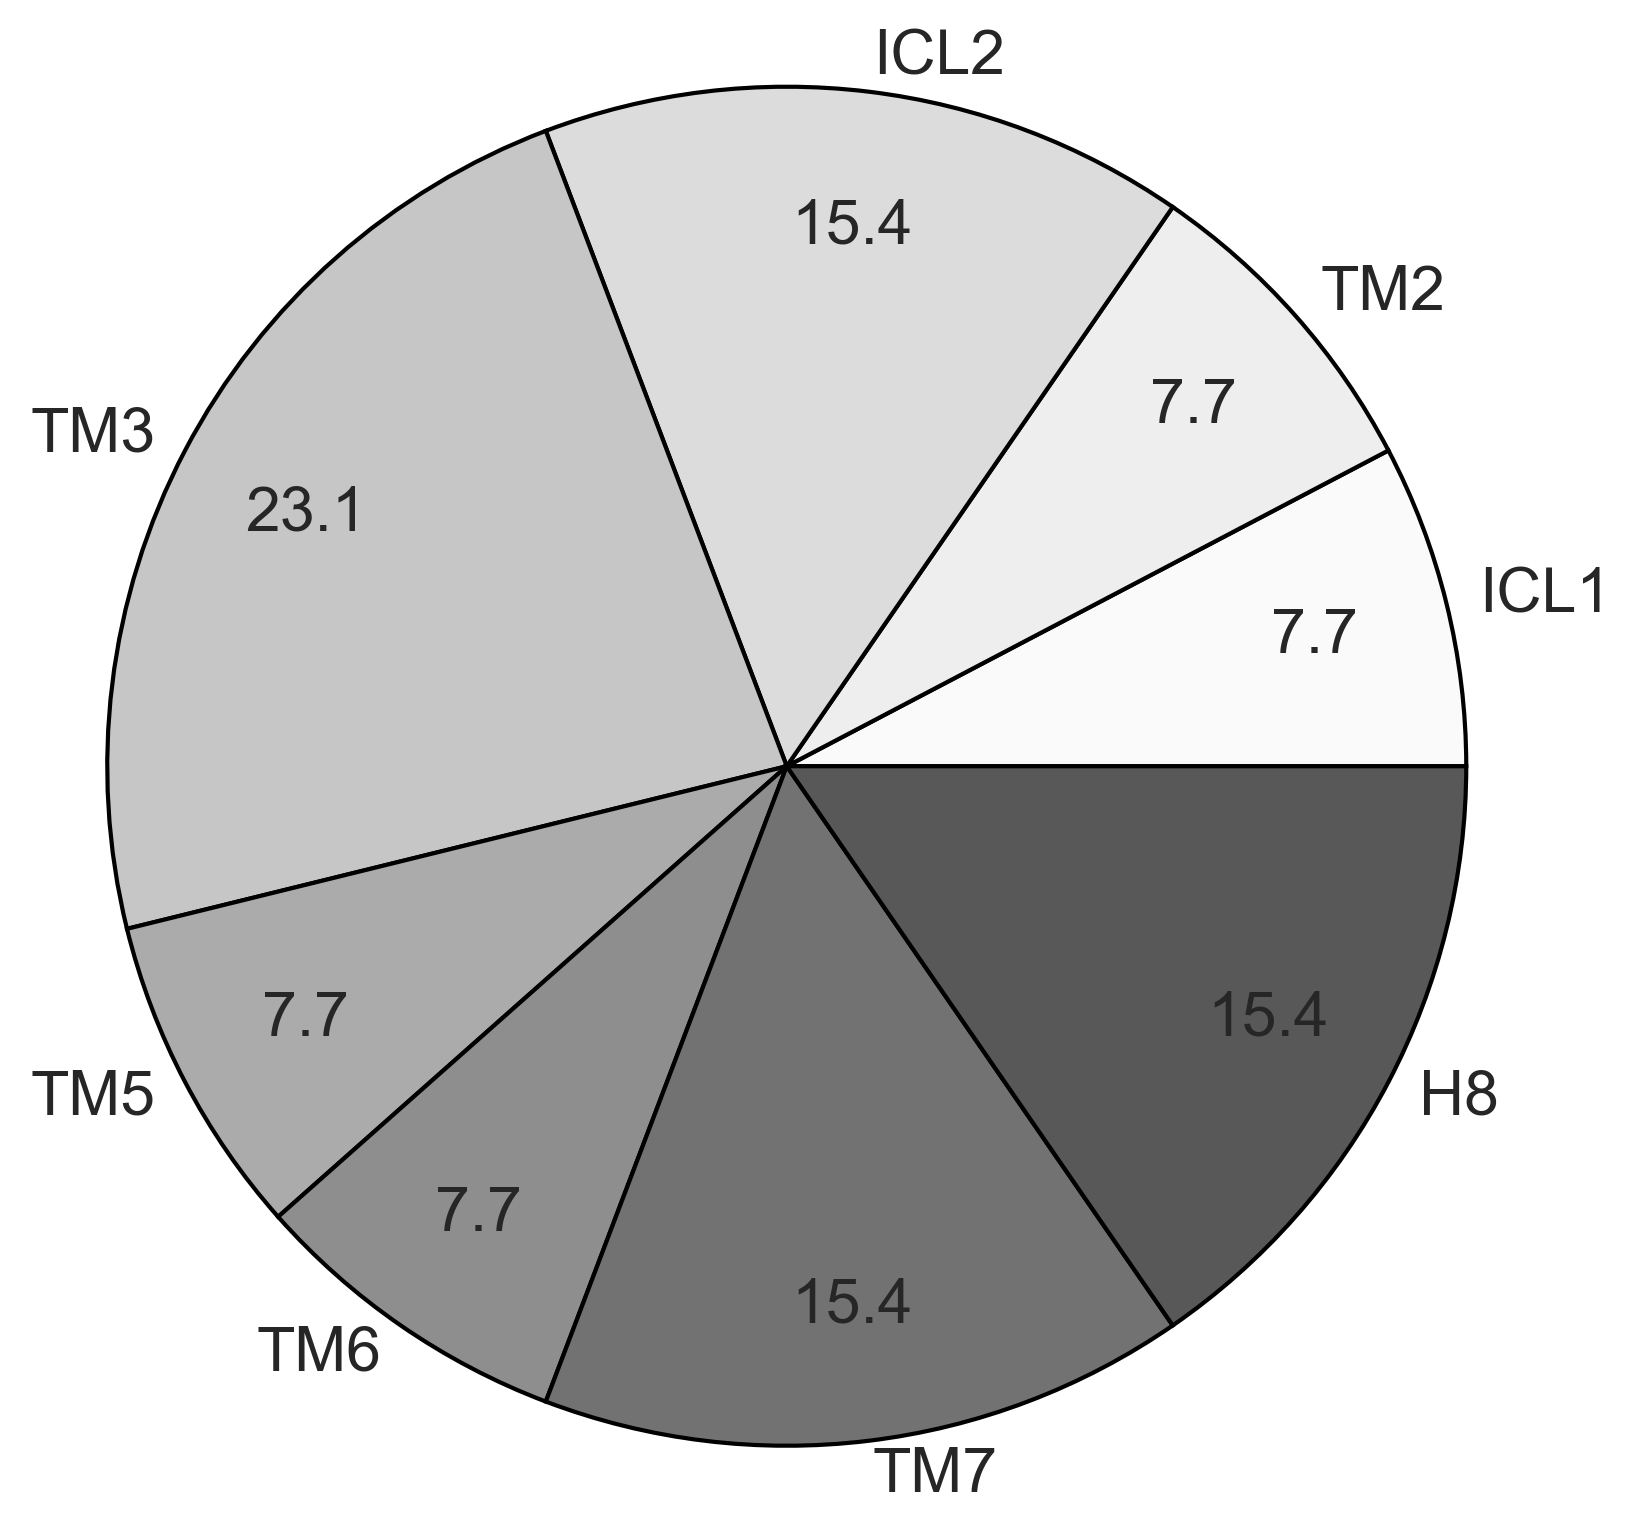

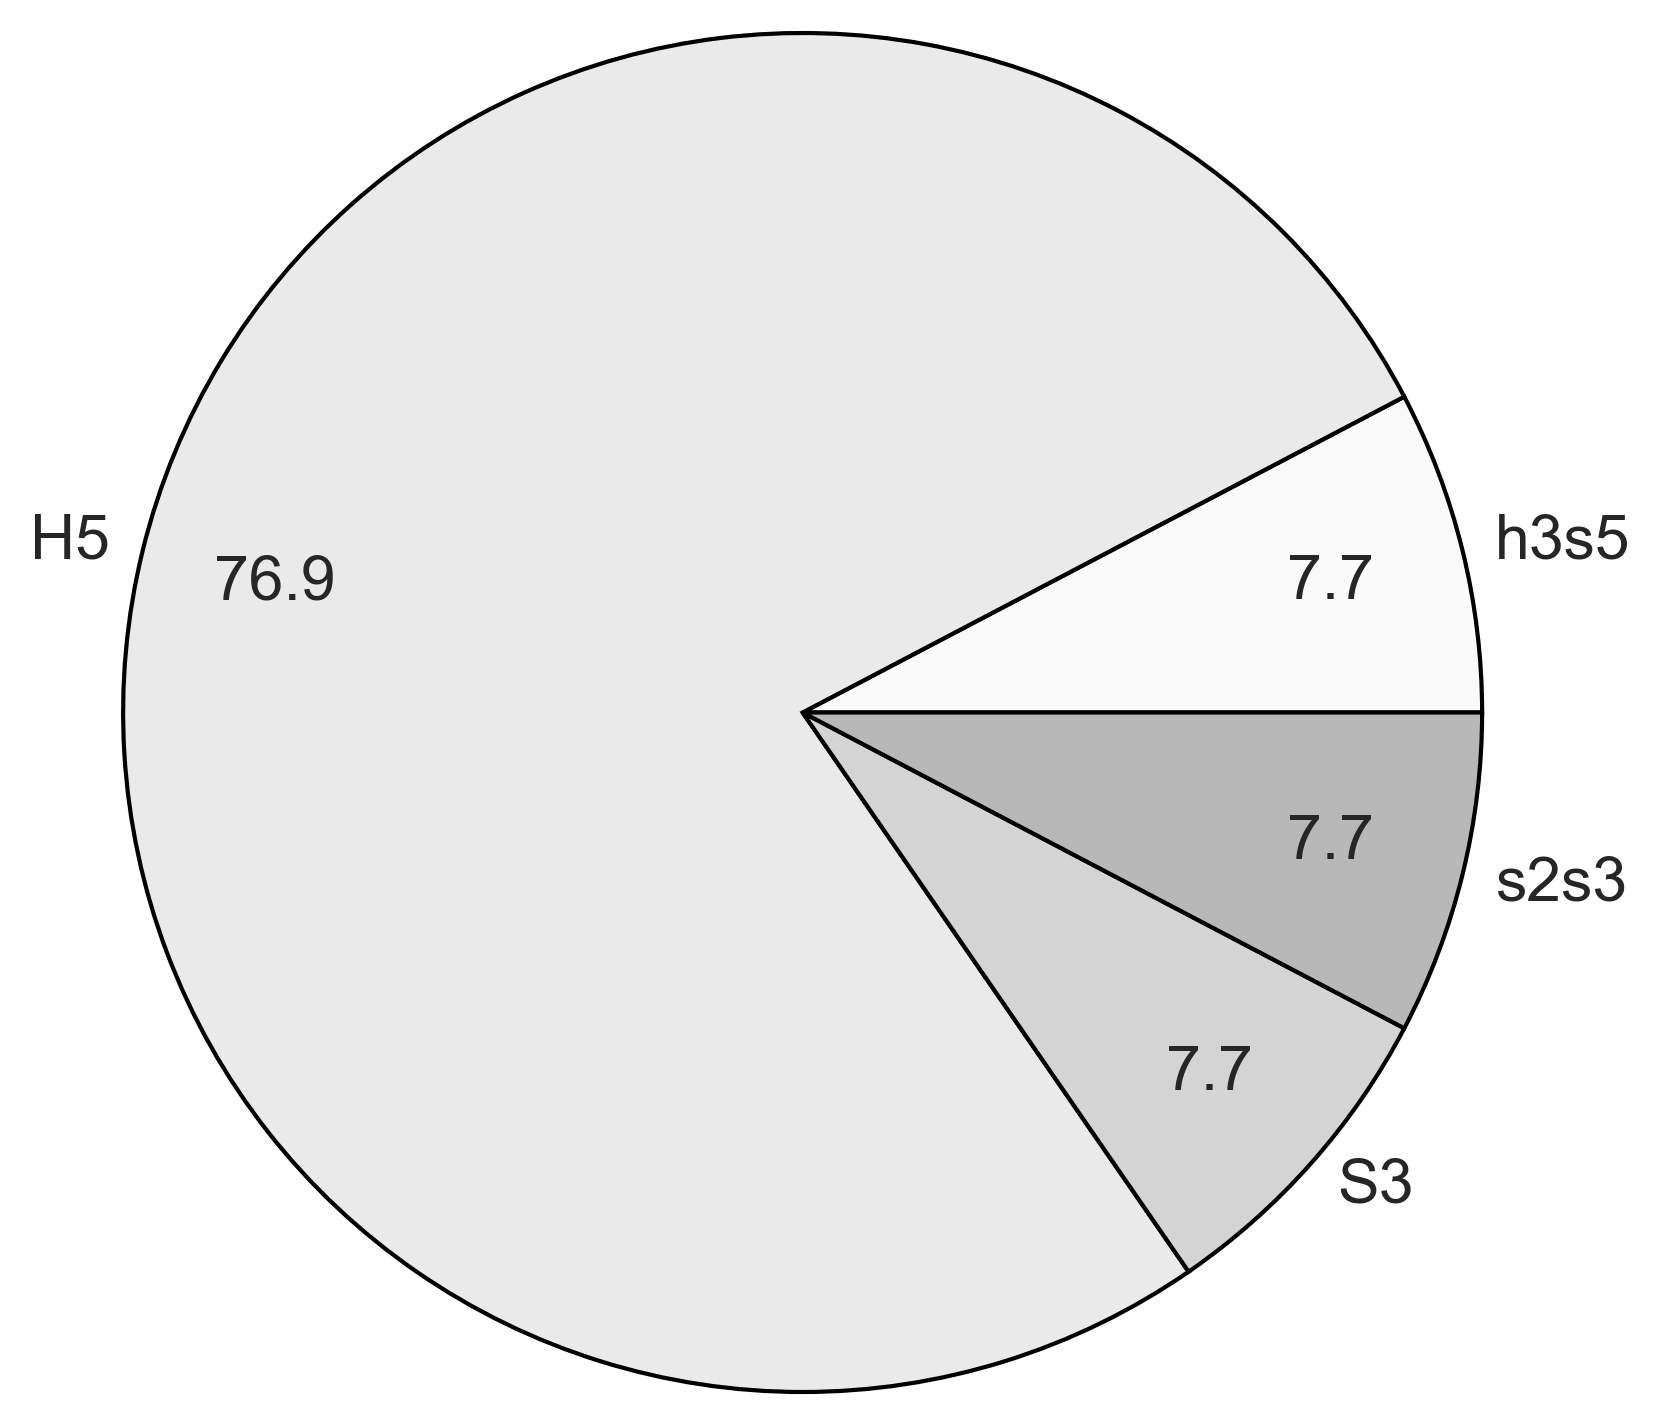

In [145]:
#calculate the number of Gi contacts from different secondary structural elements of GPCR and G protein
gicontdfs = cont_counter(gispec)
gicontdfs[0].to_csv("Gi_gpcrSS_cont_count.txt", sep='\t')
gicontdfs[1].to_csv("Gi_gprotSS_cont_count.txt", sep='\t')

plt.figure(figsize=(6,6), dpi=300)
plt.pie(gicontdfs[0], labels=['ICL1','TM2','ICL2','TM3','TM5','TM6','TM7','H8'], labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,25)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1,'edgecolor':'black'})
plt.savefig("Gi_gpcrSS_cont_pie.eps", transparent=True, dpi=300)

plt.figure(figsize=(6,6), dpi=300)
plt.pie(gicontdfs[1], labels=gicontdfs[1].index.values, labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,30)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1, 'edgecolor':'black'})
plt.savefig("Gi_gprotSS_cont_pie.eps", transparent=True, dpi=300)

      contacts
TM2        6.0
TM34       5.0
TM3        1.0
TM4        2.0
TM6        2.0
TM8        2.0
      contacts
hns1       3.0
H5        13.0
s2s3       2.0


<ipython-input-146-2612073315ed>:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(gqcontdfs[0], labels=['TM2','ICL2','TM3','TM4','TM6','H8'], labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,25)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1,'edgecolor':'black'})
<ipython-input-146-2612073315ed>:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(gqcontdfs[1], labels=gqcontdfs[1].index.values, labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,30)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1, 'edgecolor':'black'})


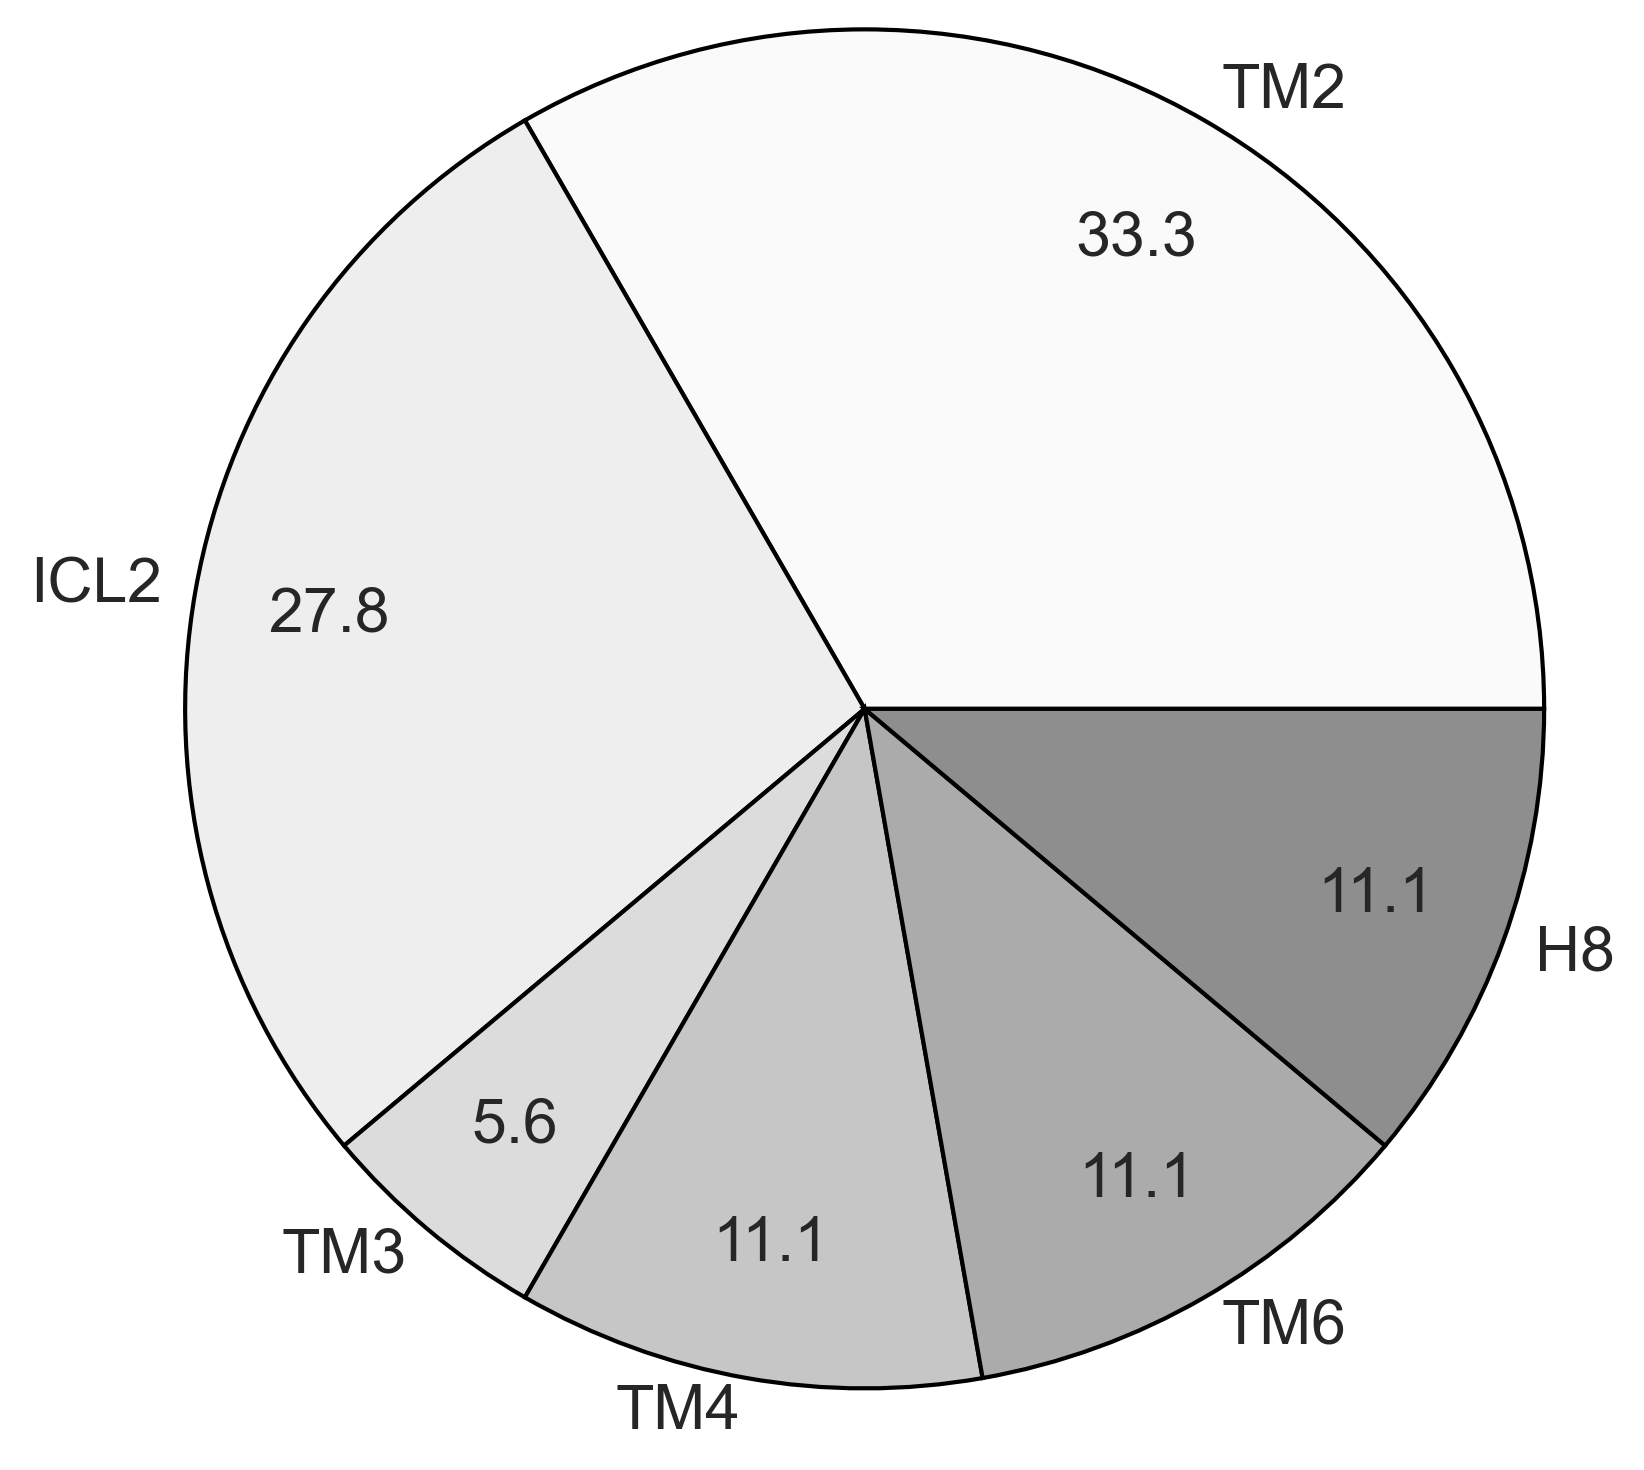

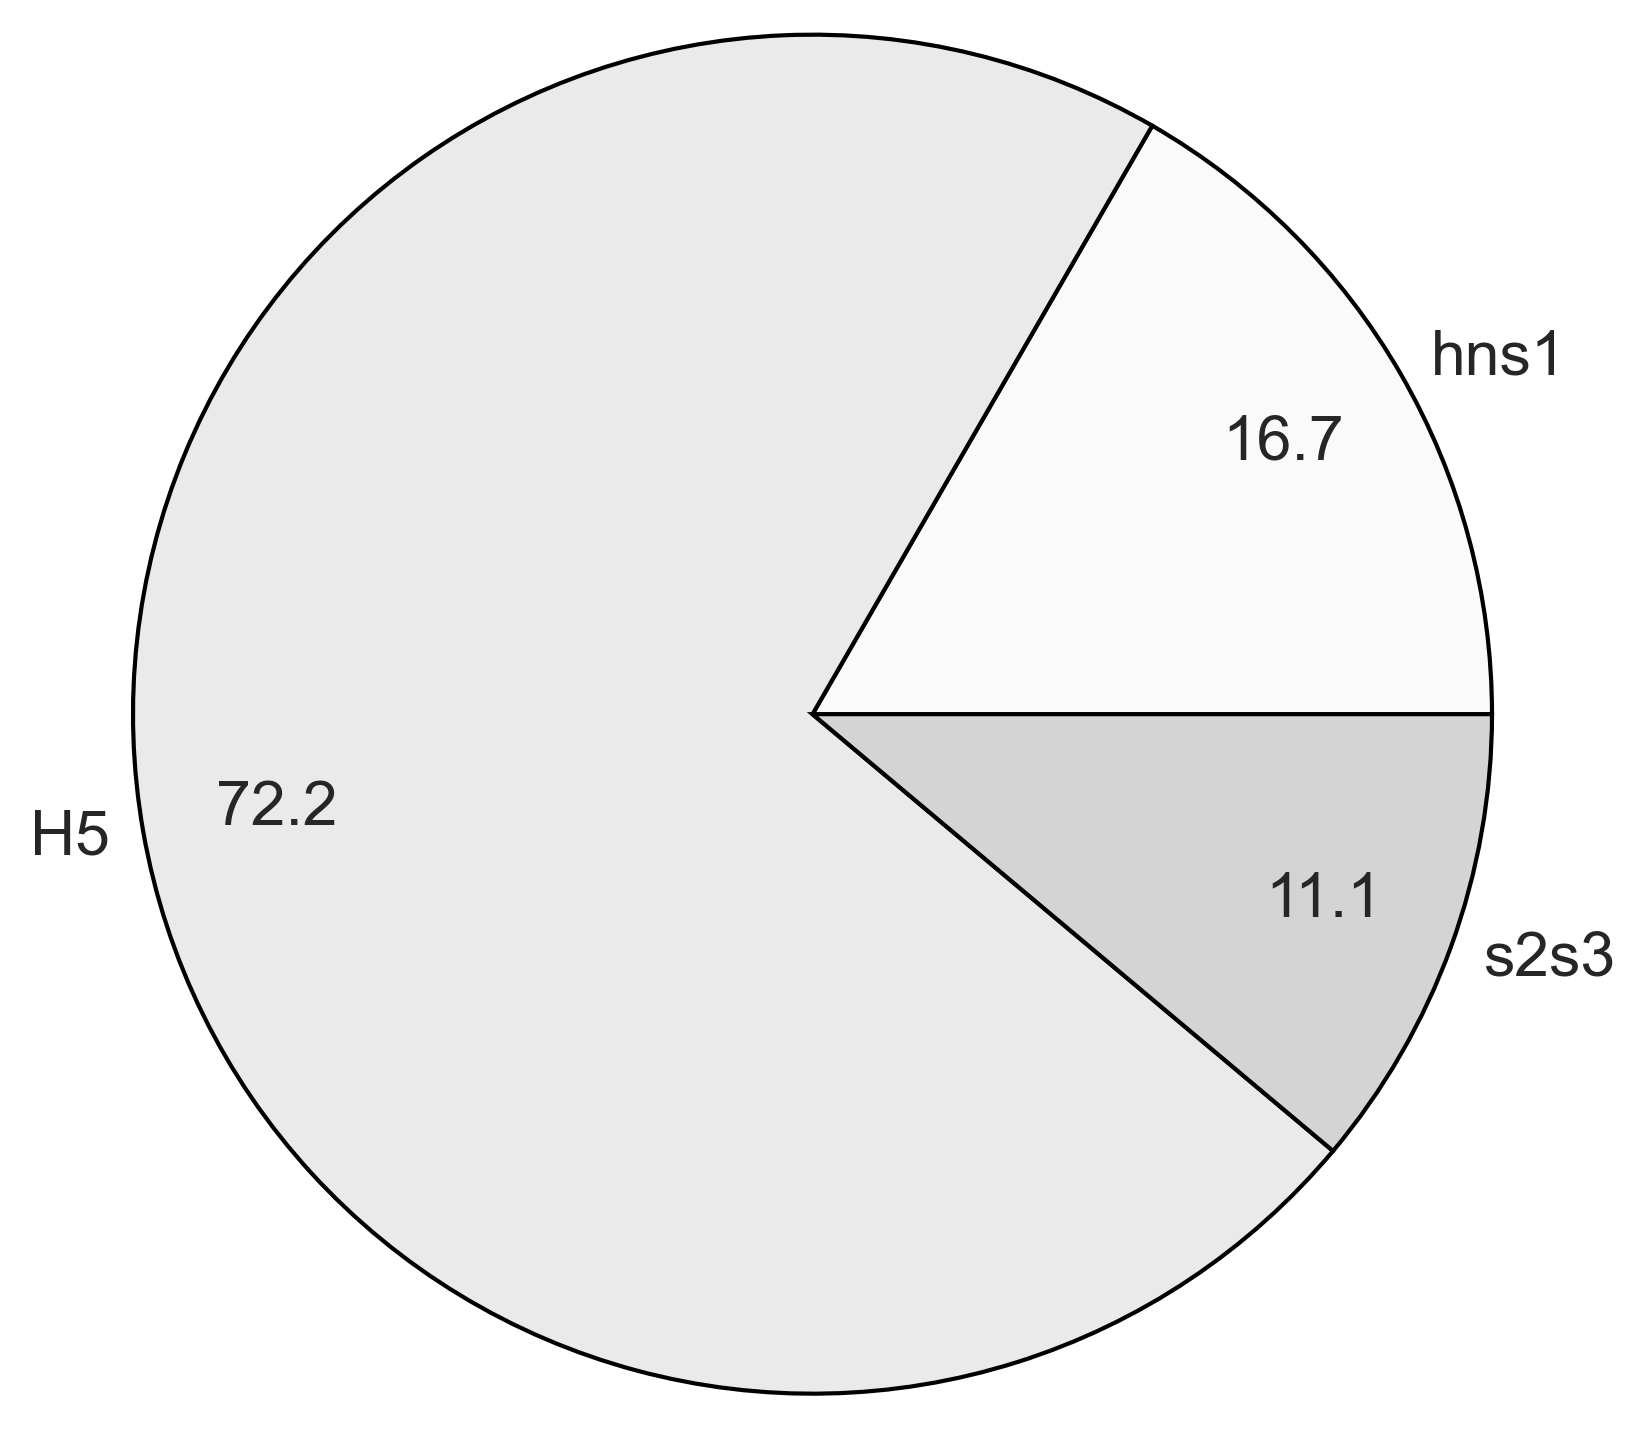

In [146]:
#calculate the number of Gq contacts from different secondary structural elements of GPCR and G protein
gqcontdfs = cont_counter(gqspec)
gqcontdfs[0].to_csv("Gq_gpcrSS_cont_count.txt", sep='\t')
gqcontdfs[1].to_csv("Gq_gprotSS_cont_count.txt", sep='\t')

plt.figure(figsize=(6,6), dpi=300)
plt.pie(gqcontdfs[0], labels=['TM2','ICL2','TM3','TM4','TM6','H8'], labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,25)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1,'edgecolor':'black'})
plt.savefig("Gq_gpcrSS_cont_pie.eps", transparent=True, dpi=300)

plt.figure(figsize=(6,6), dpi=300)
plt.pie(gqcontdfs[1], labels=gqcontdfs[1].index.values, labeldistance=1.05, textprops={'fontsize':15}, colors=col(range(10,255,30)), radius=1.25, autopct='%.1f', pctdistance=0.8, wedgeprops={'linewidth':1, 'edgecolor':'black'})
plt.savefig("Gq_gprotSS_cont_pie.eps", transparent=True, dpi=300)

In [154]:
srecint = []
sgprtint = []
for v in [B2AR, A2AR]:
    s = v.columns.values.tolist()
    #print(s)
    for i in s:
        ii = i.split('_')
        srecint.append(ii[0])
        sgprtint.append(ii[1])
#list(set(srecint)).to_csv("Gs_receptor_interface_positions.txt", sep="\t")
#list(set(sgprtint)).to_csv("Gs_gprot_interface_positions.txt", sep="\t")
print(set(srecint))
print(set(sgprtint))

{'2x37', '5x62', '34x56', '5x78', '6x36', '5x68', '6x33', '5x74', '34x57', '34x52', '4x39', '5x58', '5x75', '6x40', '8x48', '3x55', '6x32', '3x56', '4x38', '5x61', '5x71', '34x51', '8x52', '5x77', '5x72', '3x53', '7x53', '8x51', '12x51', '3x49', '34x50', '5x65', '7x55', '34x55', '5x69', '7x56', '34x53', '12x48', '6x28', '5x64', '8x47', '5x76', '6x27', '6x37', '6x35', '6x26', '3x50', '8x49', '34x54', '12x49', '4x40', '6x29', '5x70', '3x54', '2x39', '5x67', '2x38'}
{'G.hgh4.16', 'G.H5.24', 'G.HN.44', 'G.H3.13', 'G.hgh4.10', 'G.hgh4.12', 'G.S1.02', 'G.hns1.03', 'G.S6.05', 'G.HN.29', 'G.hgh4.08', 'G.h4s6.11', 'G.HN.47', 'G.h4s6.12', 'G.h4s6.08', 'G.hgh4.09', 'G.H5.25', 'G.H5.20', 'G.H5.10', 'G.HN.49', 'G.H5.16', 'G.H5.11', 'G.h2s4.05', 'G.H5.17', 'G.h4s6.10', 'G.S6.03', 'G.HN.51', 'G.H5.18', 'G.H4.04', 'G.h4s6.04', 'G.S3.02', 'G.h4s6.20', 'G.S3.01', 'G.h4s6.03', 'G.H4.17', 'G.hgh4.13', 'G.hns1.01', 'G.h4s6.13', 'G.H4.08', 'G.H5.15', 'G.h4s6.09', 'G.S6.04', 'G.hgh4.14', 'G.S6.02', 'G.H5.26'

In [155]:
irecint = []
igprtint = []
for v in [A1AR, HT1B]:
    s = v.columns.values.tolist()
    #print(s)
    for i in s:
        ii = i.split('_')
        irecint.append(ii[0])
        igprtint.append(ii[1])
#list(set(srecint)).to_csv("Gs_receptor_interface_positions.txt", sep="\t")
#list(set(sgprtint)).to_csv("Gs_gprot_interface_positions.txt", sep="\t")
print(set(irecint))
print(set(igprtint))

{'2x37', '5x62', '34x56', '1x58', '6x36', '5x68', '6x33', '6x25', '4x39', '34x52', '5x58', '6x40', '34x57', '8x48', '8x55', '3x55', '6x32', '3x56', '4x38', '5x61', '5x71', '34x51', '8x52', '3x53', '7x53', '8x51', '2x40', '4x41', '12x51', '3x49', '34x50', '5x65', '6x24', '34x55', '5x69', '7x52', '8x56', '7x56', '5x66', '34x53', '12x48', '6x30', '6x28', '5x64', '8x47', '6x27', '6x37', '6x26', '3x50', '8x50', '8x49', '5x57', '34x54', '12x49', '4x40', '5x70', '6x29', '8x59', '3x54', '2x39', '5x67', '2x38'}
{'G.H5.24', 'G.HN.50', 'G.H4.10', 'G.H4.07', 'G.H4.02', 'G.H5.16', 'G.h2s4.03', 'G.S3.02', 'G.S3.01', 'G.h4s6.03', 'G.HN.11', 'G.H5.26', 'G.hns1.02', 'G.H5.05', 'G.HN.45', 'G.H5.08', 'G.h4s6.02', 'G.H4.16', 'G.H2.09', 'G.h2s4.02', 'G.H5.22', 'G.HN.44', 'G.H5.02', 'G.hns1.03', 'G.h4s6.11', 'G.hgh4.06', 'G.h4s6.08', 'G.S1.01', 'G.hgh4.07', 'G.h3s5.01', 'G.HN.49', 'G.h3s5.03', 'G.HN.51', 'G.H5.09', 'G.H4.17', 'G.hns1.01', 'G.HN.41', 'G.H5.15', 'G.S6.04', 'G.H5.21', 'G.HN.52', 'G.h3s5.02', '

In [156]:
qrecint = []
qgprtint = []
for v in [CHRM1, HT2A]:
    s = v.columns.values.tolist()
    #print(s)
    for i in s:
        ii = i.split('_')
        qrecint.append(ii[0])
        qgprtint.append(ii[1])
#list(set(srecint)).to_csv("Gs_receptor_interface_positions.txt", sep="\t")
#list(set(sgprtint)).to_csv("Gs_gprot_interface_positions.txt", sep="\t")
print(set(qrecint))
print(set(qgprtint))

{'12x50', '6x31', '2x37', '5x62', '34x56', '6x36', '5x68', '6x33', '5x74', '4x39', '34x57', '34x52', '5x73', '5x75', '8x65', '8x48', '2x42', '3x55', '3x56', '4x38', '5x61', '5x71', '34x51', '8x71', '5x77', '3x46', '8x52', '5x72', '3x53', '7x53', '8x51', '2x40', '4x41', '3x49', '34x50', '5x65', '8x70', '34x55', '5x69', '7x56', '5x66', '8x68', '34x53', '2x43', '6x30', '8x69', '6x28', '5x64', '8x47', '5x76', '8x66', '6x37', '4x45', '6x27', '6x34', '3x50', '8x50', '8x64', '8x49', '34x54', '12x49', '4x40', '5x70', '8x67', '6x29', '3x54', '2x39', '6x32', '2x38'}
{'G.H5.24', 'G.H3.15', 'G.S6.05', 'G.H5.16', 'G.h2s4.03', 'G.S3.02', 'G.h4s6.20', 'G.S3.01', 'G.h4s6.03', 'G.H5.26', 'G.hns1.02', 'G.H5.05', 'G.H4.01', 'G.H5.08', 'G.H4.03', 'G.h4s6.02', 'G.HN.42', 'G.H4.16', 'G.H2.09', 'G.h2s4.02', 'G.s6h5.02', 'G.H3.14', 'G.H5.22', 'G.s6h5.01', 'G.H5.02', 'G.hns1.03', 'G.h4s6.11', 'G.hgh4.06', 'G.h4s6.08', 'G.hgh4.07', 'G.h3s5.01', 'G.h2s4.01', 'G.HN.46', 'G.HN.51', 'G.H5.09', 'G.H3.11', 'G.h4s6.13

In [207]:
allcont_avgmeans = []
commallrat = []
#Calculate the avg frequency per contact for contacts in the common subset and Gs sampled contacts across the Gs receptors
for i in ['B2AR', 'A2AR', 'B2TMs']:#, 'A1AR', 'HT1B', 'CHRM1', 'HT2A', 'B2TMs', 'B2TMq']:
    c = simulation_means[[i]].loc[commall]
    r = simulation_means[[i]].loc[gs_conts]
    c = c[(c.T != 0).any()]
    r = r[(r.T != 0).any()]
    c.to_csv(str(i)+"common_conts.txt", sep="\t")
    r.to_csv(str(i)+"Gs_spec_conts.txt",sep="\t")
    allcont_avgmeans.append([i,"common",c.mean()[0],c.std()[0]])
    allcont_avgmeans.append([i,"class_sampled",r.mean()[0], r.std()[0]])
    commallrat.append([i,c.mean()[0]/r.mean()[0]])
    print(i+" mean comm freq: "+str(c.mean()[0]))
    print(i+" comm std: "+str(c.std()[0]))
    print(i+" comm length: "+str(c.shape[0]))
    print(i+" mean uni freq: "+str(r.mean()[0]))
    print(i+" uni std: "+str(r.std()[0]))
    print(i+" uni length: "+str(r.shape[0]))
    
#Calculate the avg frequency per contact for contacts in the common subset and Gi sampled contacts across the Gi receptors
for i in ['A1AR', 'HT1B']:#, 'A1AR', 'HT1B', 'CHRM1', 'HT2A', 'B2TMs', 'B2TMq']:
    c = simulation_means[[i]].loc[commall]
    r = simulation_means[[i]].loc[gi_conts]
    c = c[(c.T != 0).any()]
    r = r[(r.T != 0).any()]
    c.to_csv(str(i)+"common_conts.txt", sep="\t")
    r.to_csv(str(i)+"Gi_spec_conts.txt",sep="\t")
    allcont_avgmeans.append([i,"common",c.mean()[0],c.std()[0]])
    allcont_avgmeans.append([i,"class_sampled",r.mean()[0], r.std()[0]])
    commallrat.append([i,c.mean()[0]/r.mean()[0]])
    print(i+" mean comm freq: "+str(c.mean()[0]))
    print(i+" comm std: "+str(c.std()[0]))
    print(i+" comm length: "+str(c.shape[0]))
    print(i+" mean uni freq: "+str(r.mean()[0]))
    print(i+" uni std: "+str(r.std()[0]))
    print(i+" uni length: "+str(r.shape[0]))
    
#Calculate the avg frequency per contact for contacts in the common subset and Gq sampled contacts across the Gq receptors
for i in ['CHRM1', 'HT2A', 'B2TMq']:#, 'A1AR', 'HT1B', 'CHRM1', 'HT2A', 'B2TMs', 'B2TMq']:
    c = simulation_means[[i]].loc[commall]
    r = simulation_means[[i]].loc[gq_conts]
    c = c[(c.T != 0).any()]
    r = r[(r.T != 0).any()]
    c.to_csv(str(i)+"common_conts.txt", sep="\t")
    r.to_csv(str(i)+"Gq_spec_conts.txt",sep="\t")
    allcont_avgmeans.append([i,"common",c.mean()[0],c.std()[0]])
    allcont_avgmeans.append([i,"class_sampled",r.mean()[0], r.std()[0]])
    commallrat.append([i,c.mean()[0]/r.mean()[0]])
    print(i+" mean comm freq: "+str(c.mean()[0]))
    print(i+" comm std: "+str(c.std()[0]))
    print(i+" comm length: "+str(c.shape[0]))
    print(i+" mean uni freq: "+str(r.mean()[0]))
    print(i+" uni std: "+str(r.std()[0]))
    print(i+" uni length: "+str(r.shape[0]))

#Calculate the avg frequency per contact for contacts in the common subset and Gq sampled contacts across the ADRB2-TM:Gs complex
for i in ['B2TMs']:#, 'A1AR', 'HT1B', 'CHRM1', 'HT2A', 'B2TMs', 'B2TMq']:
    c = simulation_means[[i]].loc[commall]
    r = simulation_means[[i]].loc[gq_conts]
    c = c[(c.T != 0).any()]
    r = r[(r.T != 0).any()]
    c.to_csv(str(i)+"common_conts.txt", sep="\t")
    r.to_csv(str(i)+"alt_Gq_spec_conts.txt",sep="\t")
    allcont_avgmeans.append(["B2TMs_alt","common",c.mean()[0],c.std()[0]])
    allcont_avgmeans.append(["B2TMs_alt","class_sampled",r.mean()[0], r.std()[0]])
    commallrat.append(["B2TMs_alt",c.mean()[0]/r.mean()[0]])
    print(i+" mean comm freq: "+str(c.mean()[0]))
    print(i+" comm std: "+str(c.std()[0]))
    print(i+" comm length: "+str(c.shape[0]))
    print(i+" mean uni freq: "+str(r.mean()[0]))
    print(i+" uni std: "+str(r.std()[0]))
    print(i+" uni length: "+str(r.shape[0]))
    
#Calculate the avg frequency per contact for contacts in the common subset and Gs sampled contacts across the ADRB2-TM:Gq complex
for i in ['B2TMq']:#, 'A1AR', 'HT1B', 'CHRM1', 'HT2A', 'B2TMs', 'B2TMq']:
    c = simulation_means[[i]].loc[commall]
    r = simulation_means[[i]].loc[gs_conts]
    c = c[(c.T != 0).any()]
    r = r[(r.T != 0).any()]
    c.to_csv(str(i)+"common_conts.txt", sep="\t")
    r.to_csv(str(i)+"alt_Gs_spec_conts.txt",sep="\t")
    allcont_avgmeans.append(["B2TMq_alt","common",c.mean()[0],c.std()[0]])
    allcont_avgmeans.append(["B2TMq_alt","class_sampled",r.mean()[0], r.std()[0]])
    commallrat.append(["B2TMq_alt",c.mean()[0]/r.mean()[0]])
    print(i+" mean comm freq: "+str(c.mean()[0]))
    print(i+" comm std: "+str(c.std()[0]))
    print(i+" comm length: "+str(c.shape[0]))
    print(i+" mean uni freq: "+str(r.mean()[0]))
    print(i+" uni std: "+str(r.std()[0]))
    print(i+" uni length: "+str(r.shape[0]))

B2AR mean comm freq: 0.5477229909926282
B2AR comm std: 0.2540227571700388
B2AR comm length: 22
B2AR mean uni freq: 0.4493261947787304
B2AR uni std: 0.2646422045172361
B2AR uni length: 60
A2AR mean comm freq: 0.5002655998567902
A2AR comm std: 0.3605929515092088
A2AR comm length: 22
A2AR mean uni freq: 0.3520066815065317
A2AR uni std: 0.3423813453994619
A2AR uni length: 48
B2TMs mean comm freq: 0.6243819568053084
B2TMs comm std: 0.2223168491745093
B2TMs comm length: 18
B2TMs mean uni freq: 0.3857481183709659
B2TMs uni std: 0.27877497502811827
B2TMs uni length: 48
A1AR mean comm freq: 0.43667198497541565
A1AR comm std: 0.230357942583773
A1AR comm length: 23
A1AR mean uni freq: 0.3372858458834968
A1AR uni std: 0.24888075856609834
A1AR uni length: 47
HT1B mean comm freq: 0.5051392709085095
HT1B comm std: 0.2622287986881699
HT1B comm length: 23
HT1B mean uni freq: 0.4019174030373285
HT1B uni std: 0.2611706403709082
HT1B uni length: 45
CHRM1 mean comm freq: 0.42869167628691685
CHRM1 comm std:

In [208]:
avgmeans = []
commspecrat = []
#Calculate the avg frequency per contact for contacts in the common subset and Gs protein specific across the Gs receptors
for i in ['B2AR', 'A2AR', 'B2TMs']:#, 'A1AR', 'HT1B', 'CHRM1', 'HT2A', 'B2TMs', 'B2TMq']:
    c = simulation_means[[i]].loc[commall]
    r = simulation_means[[i]].loc[gsspec]
    c = c[(c.T != 0).any()]
    r = r[(r.T != 0).any()]
    c.to_csv(str(i)+"common_conts.txt", sep="\t")
    r.to_csv(str(i)+"Gs_spec_conts.txt",sep="\t")
    avgmeans.append([i,"common",c.mean()[0],c.std()[0]])
    avgmeans.append([i,"specific",r.mean()[0], r.std()[0]])
    commspecrat.append([i,c.mean()[0]/r.mean()[0]])
    print(i+" mean comm freq: "+str(c.mean()[0]))
    print(i+" comm std: "+str(c.std()[0]))
    print(i+" comm length: "+str(c.shape[0]))
    print(i+" mean uni freq: "+str(r.mean()[0]))
    print(i+" uni std: "+str(r.std()[0]))
    print(i+" uni length: "+str(r.shape[0]))
#Calculate the avg frequency per contact for contacts in the common subset and Gi protein specific across the Gi receptors
for i in ['A1AR', 'HT1B']:#, 'A1AR', 'HT1B', 'CHRM1', 'HT2A', 'B2TMs', 'B2TMq']:
    c = simulation_means[[i]].loc[commall]
    r = simulation_means[[i]].loc[gispec]
    c = c[(c.T != 0).any()]
    r = r[(r.T != 0).any()]
    c.to_csv(str(i)+"common_conts.txt", sep="\t")
    r.to_csv(str(i)+"Gi_spec_conts.txt",sep="\t")
    commspecrat.append([i,c.mean()[0]/r.mean()[0]])
    avgmeans.append([i,"common",c.mean()[0],c.std()[0]])
    avgmeans.append([i,"specific",r.mean()[0], r.std()[0]])
    print(i+" mean comm freq: "+str(c.mean()[0]))
    print(i+" comm std: "+str(c.std()[0]))
    print(i+" comm length: "+str(c.shape[0]))
    print(i+" mean uni freq: "+str(r.mean()[0]))
    print(i+" uni std: "+str(r.std()[0]))
    print(i+" uni length: "+str(r.shape[0]))
#Calculate the avg frequency per contact for contacts in the common subset and Gq protein specific across the Gq receptors
for i in ['CHRM1', 'HT2A', 'B2TMq']:#, 'A1AR', 'HT1B', 'CHRM1', 'HT2A', 'B2TMs', 'B2TMq']:
    c = simulation_means[[i]].loc[commall]
    r = simulation_means[[i]].loc[gqspec]
    c = c[(c.T != 0).any()]
    r = r[(r.T != 0).any()]
    c.to_csv(str(i)+"common_conts.txt", sep="\t")
    r.to_csv(str(i)+"Gq_spec_conts.txt",sep="\t")
    avgmeans.append([i,"common",c.mean()[0],c.std()[0]])
    avgmeans.append([i,"specific",r.mean()[0], r.std()[0]])
    commspecrat.append([i,c.mean()[0]/r.mean()[0]])
    print(i+" mean comm freq: "+str(c.mean()[0]))
    print(i+" comm std: "+str(c.std()[0]))
    print(i+" comm length: "+str(c.shape[0]))
    print(i+" mean uni freq: "+str(r.mean()[0]))
    print(i+" uni std: "+str(r.std()[0]))
    print(i+" uni length: "+str(r.shape[0]))

#Calculate the avg frequency per contact for contacts in the common subset and Gq protein specific contacts across the ADRB2-TM:Gs complex    
for i in ['B2TMs']:#, 'A1AR', 'HT1B', 'CHRM1', 'HT2A', 'B2TMs', 'B2TMq']:
    c = simulation_means[[i]].loc[commall]
    r = simulation_means[[i]].loc[gqspec]
    c = c[(c.T != 0).any()]
    r = r[(r.T != 0).any()]
    c.to_csv(str(i)+"common_conts.txt", sep="\t")
    r.to_csv(str(i)+"alt_Gq_spec_conts.txt",sep="\t")
    avgmeans.append(["B2TMs_alt","common",c.mean()[0],c.std()[0]])
    avgmeans.append(["B2TMs_alt","specific",r.mean()[0], r.std()[0]])
    commspecrat.append(["B2TMs_alt",c.mean()[0]/r.mean()[0]])
    print(i+" mean comm freq: "+str(c.mean()[0]))
    print(i+" comm std: "+str(c.std()[0]))
    print(i+" comm length: "+str(c.shape[0]))
    print(i+" mean uni freq: "+str(r.mean()[0]))
    print(i+" uni std: "+str(r.std()[0]))
    print(i+" uni length: "+str(r.shape[0]))

#Calculate the avg frequency per contact for contacts in the common subset and Gs protein specific contacts across the ADRB2-TM:Gq complex        
for i in ['B2TMq']:#, 'A1AR', 'HT1B', 'CHRM1', 'HT2A', 'B2TMs', 'B2TMq']:
    c = simulation_means[[i]].loc[commall]
    r = simulation_means[[i]].loc[gsspec]
    c = c[(c.T != 0).any()]
    r = r[(r.T != 0).any()]
    c.to_csv(str(i)+"common_conts.txt", sep="\t")
    r.to_csv(str(i)+"alt_Gs_spec_conts.txt",sep="\t")
    avgmeans.append(["B2TMq_alt","common",c.mean()[0],c.std()[0]])
    avgmeans.append(["B2TMq_alt","specific",r.mean()[0], r.std()[0]])
    commspecrat.append(["B2TMq_alt",c.mean()[0]/r.mean()[0]])
    print(i+" mean comm freq: "+str(c.mean()[0]))
    print(i+" comm std: "+str(c.std()[0]))
    print(i+" comm length: "+str(c.shape[0]))
    print(i+" mean uni freq: "+str(r.mean()[0]))
    print(i+" uni std: "+str(r.std()[0]))
    print(i+" uni length: "+str(r.shape[0]))

B2AR mean comm freq: 0.5477229909926282
B2AR comm std: 0.2540227571700388
B2AR comm length: 22
B2AR mean uni freq: 0.37653953118792205
B2AR uni std: 0.22657381528608517
B2AR uni length: 24
A2AR mean comm freq: 0.5002655998567902
A2AR comm std: 0.3605929515092088
A2AR comm length: 22
A2AR mean uni freq: 0.20179197955786643
A2AR uni std: 0.28998888013175633
A2AR uni length: 13
B2TMs mean comm freq: 0.6243819568053084
B2TMs comm std: 0.2223168491745093
B2TMs comm length: 18
B2TMs mean uni freq: 0.1923761524769505
B2TMs uni std: 0.16524831233967316
B2TMs uni length: 19
A1AR mean comm freq: 0.43667198497541565
A1AR comm std: 0.230357942583773
A1AR comm length: 23
A1AR mean uni freq: 0.23772122787721225
A1AR uni std: 0.2327863136616413
A1AR uni length: 12
HT1B mean comm freq: 0.5051392709085095
HT1B comm std: 0.2622287986881699
HT1B comm length: 23
HT1B mean uni freq: 0.234324378374775
HT1B uni std: 0.13513687092485313
HT1B uni length: 10
CHRM1 mean comm freq: 0.42869167628691685
CHRM1 comm 

In [209]:
meansdf = pd.DataFrame(avgmeans, columns=['name','condition','mean','std'])
allcont_meansdf = pd.DataFrame(allcont_avgmeans, columns=['name','condition','mean','std'])

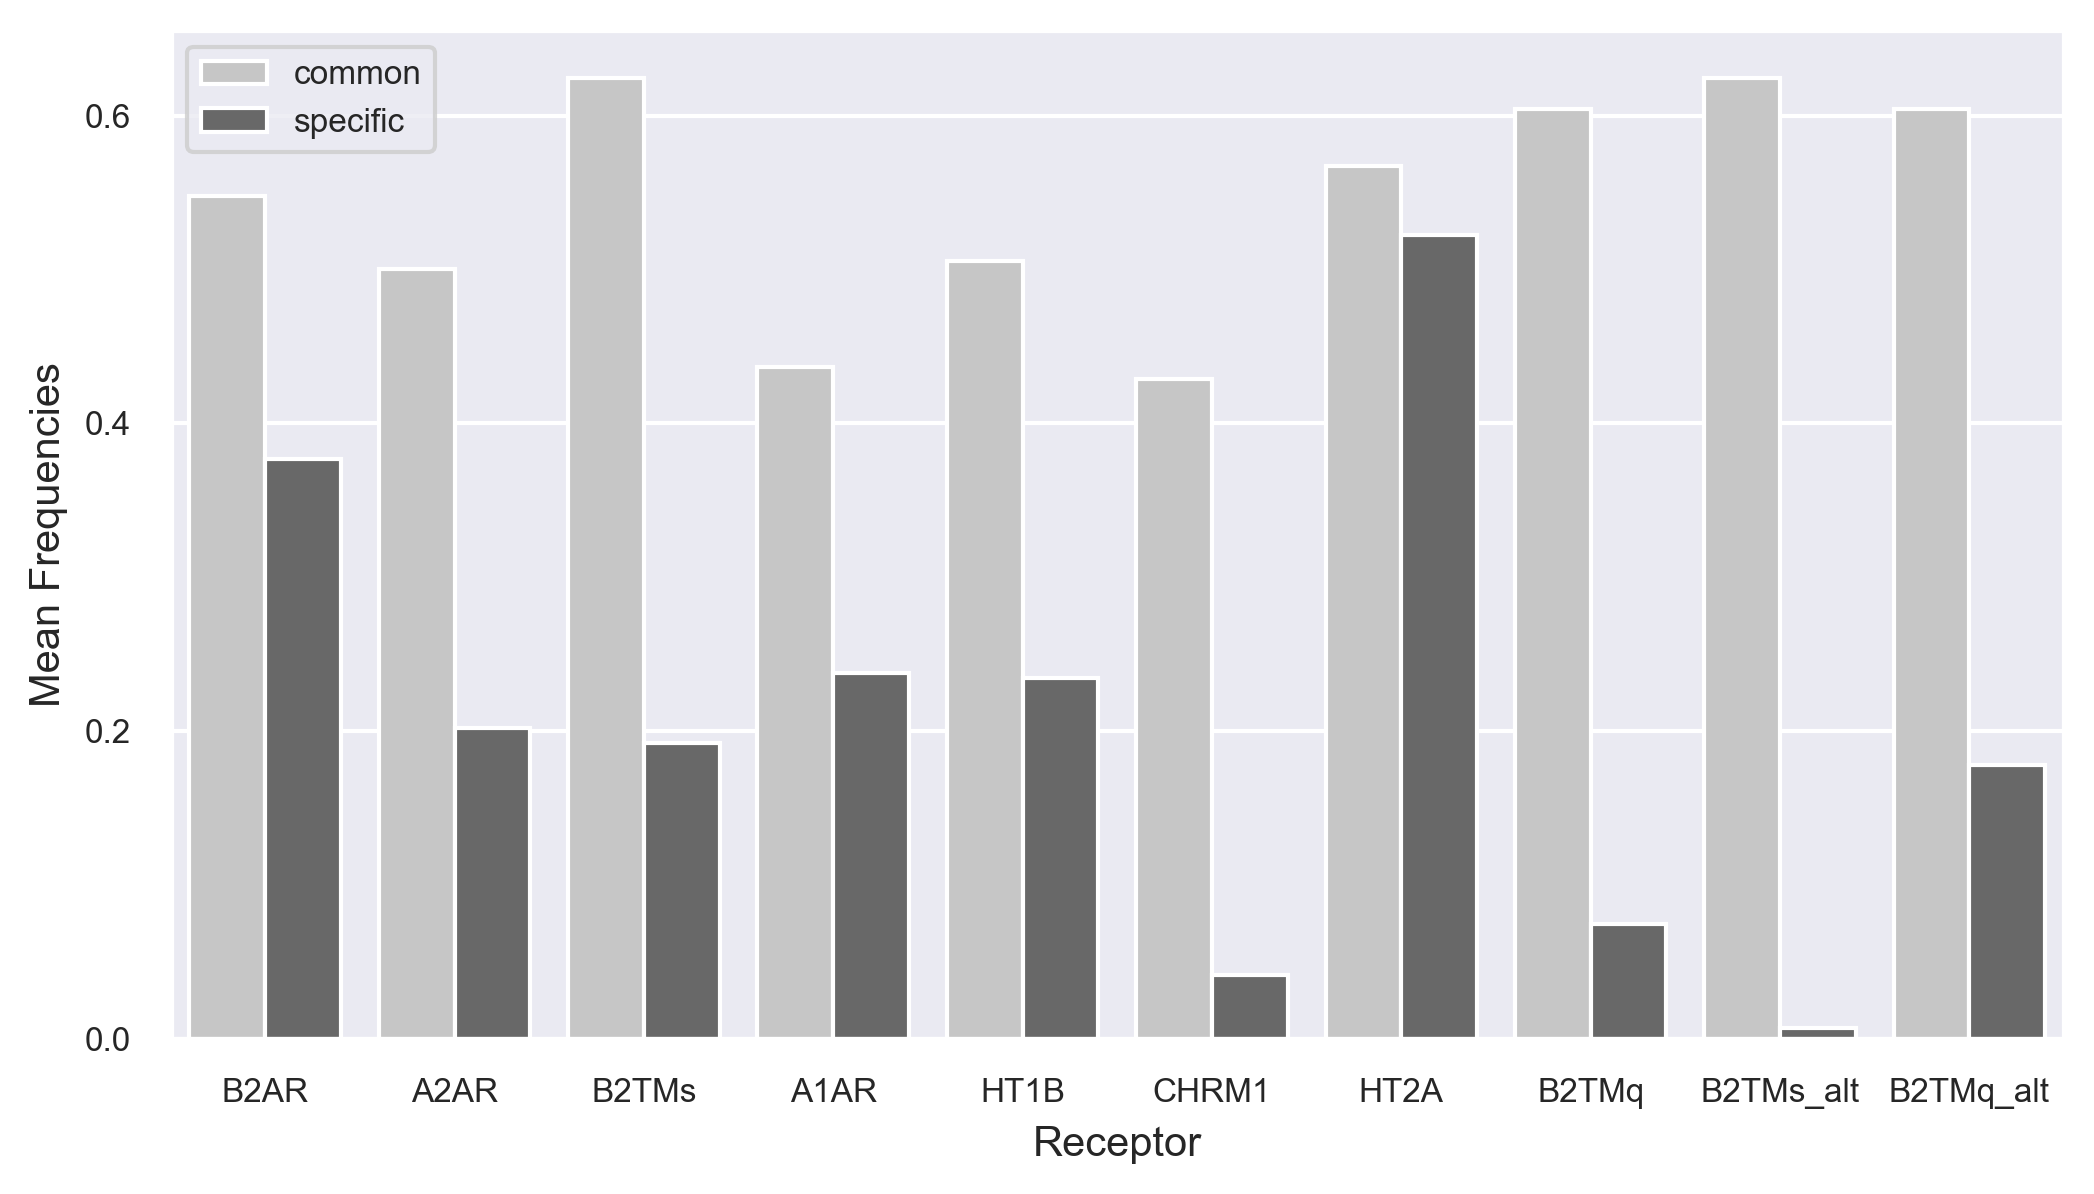

In [211]:
# Set the figure size
plt.figure(figsize=(7.5, 4.5), dpi=300)

# grouped barplot
sns.barplot(x="name", y="mean", hue="condition", data=meansdf, ci="std", palette='Greys');
plt.xlabel("Receptor", size=10)
plt.ylabel("Mean Frequencies", size=10)
plt.xticks(size=8)
plt.yticks(size=8)
plt.legend(loc='best',prop={'size': 8})
plt.tight_layout()
#plt.grid(color="black", linewidth=0.5)
plt.savefig("common_v_specific_contacts_mean_frequencies.pdf", transparent=True)

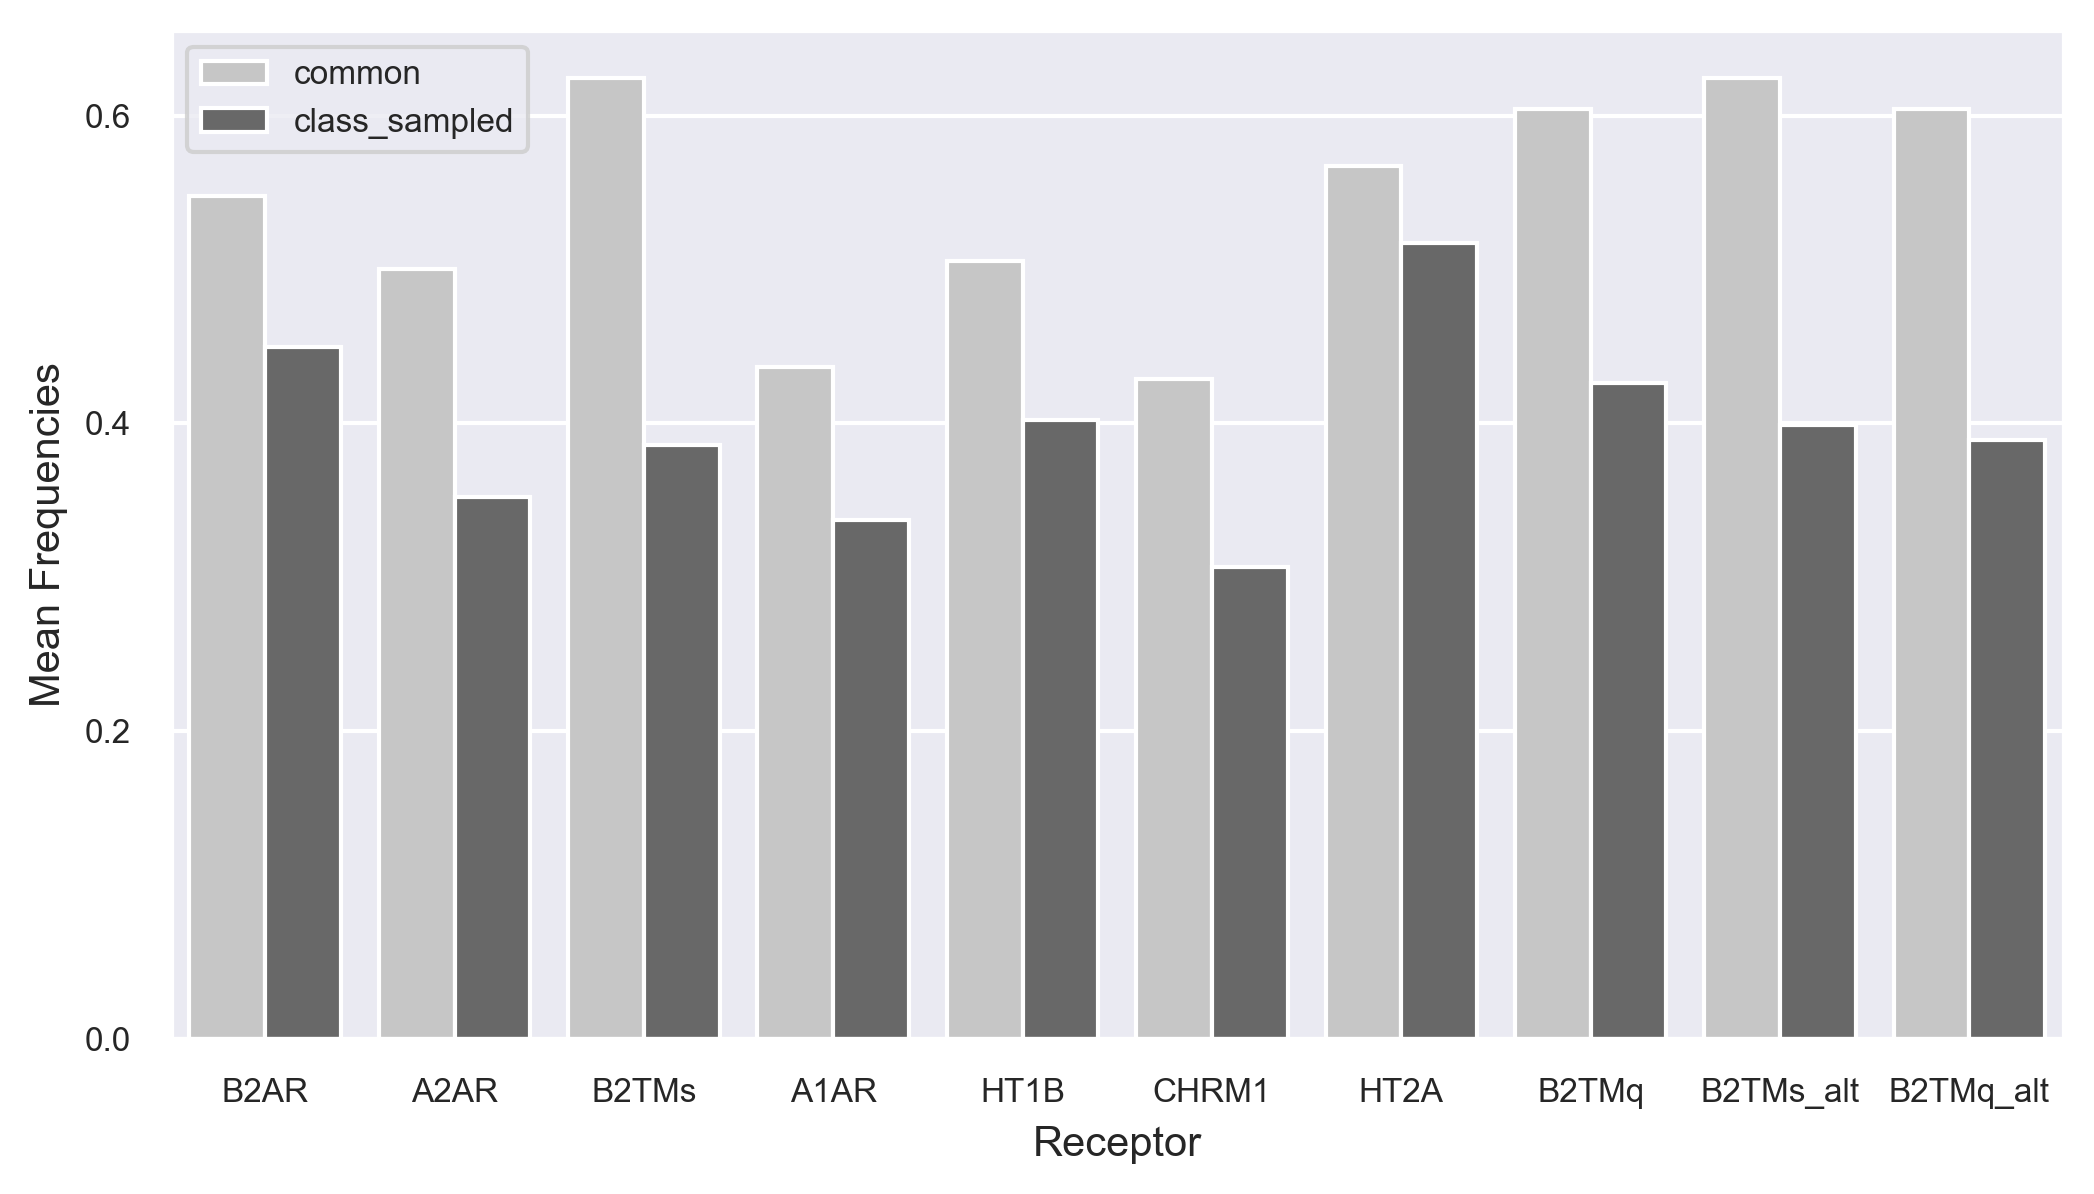

In [212]:
# Set the figure size
plt.figure(figsize=(7.5, 4.5), dpi=300)

# grouped barplot
sns.barplot(x="name", y="mean", hue="condition", data=allcont_meansdf, ci="std", palette='Greys');
plt.xlabel("Receptor", size=10)
plt.ylabel("Mean Frequencies", size=10)
plt.xticks(size=8)
plt.yticks(size=8)
plt.legend(loc='best',prop={'size': 8})
plt.tight_layout()
#plt.grid(color="black", linewidth=0.5)
plt.savefig("common_v_allGprotclass_contacts_mean_frequencies.pdf", transparent=True)